# Track OTs

In [1]:
%pylab inline

import pandas as pd
import glob
import os

import numpy as np
import pandas as pd

import trackpy as tp
from copy import deepcopy
import pyproj

import xarray as xr
import cartopy.crs as ccrs

dem_files = sorted(glob.glob('/data/accp/a/snesbitt/relampago/srtm/*.tif'))

ds_list = []
for file in dem_files:
    ds_list.append(xr.open_rasterio(file).isel(band=0))
import scipy
from shapely import wkt
import geopandas as gpd

ota_bins = np.arange(0, 225, 25)
otd_bins = np.arange(0, 4, .2)
dur_bins = np.arange(3, 16, 1)

Populating the interactive namespace from numpy and matplotlib


## 10 November Case

In [76]:
df = pd.concat([pd.read_csv(f) for f in sorted(glob.glob('ot_output/20181110/20181110*'))], ignore_index = True).drop(columns='Unnamed: 0')

In [77]:
df['geometry'] = df['geometry'].apply(wkt.loads)
geo_df = gpd.GeoDataFrame(df, geometry='geometry')

In [78]:
df = geo_df

In [79]:
df['ot_depth'] = df['cloudtop_height'] - df['tropopause_height']

In [80]:
df['diff'] = pd.to_datetime(df['time']) - pd.datetime(2018,11,1)
df['frame'] = df['diff'].dt.days*86400+df['diff'].dt.seconds
df['frame'] = df['frame'] - df['frame'].min()

/data/keeling/a/mgrover4/a/miniconda3/envs/xesmf_env/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """Entry point for launching an IPython kernel.


In [81]:
df['time'] = pd.to_datetime(df.time)

In [82]:
df['hour'] = df.time.dt.hour
df['minute'] = df.time.dt.minute

In [83]:
df = df[df.prob > .8]

In [84]:
good_ind = df['lat'].apply(lambda x: pd.to_numeric(x, errors='coerce')).index

In [85]:
df = df[df.index == good_ind]

In [86]:
df_track = deepcopy(df)
#df_track.rename(columns={'lon':'x', 'lat':'y'}, inplace=True)
#df_track['z'] = 0
df_track['states'] = 0
df_track['label'] = 0

radius=6371228.

globe = ccrs.Globe(ellipse=None, semimajor_axis=radius, 
                   semiminor_axis=radius)

projection=ccrs.LambertAzimuthalEqualArea(central_latitude=-32.,
                                          central_longitude=-62.,globe=globe)

prj=pyproj.Proj(projection.proj4_init)

df_track['x'], df_track['y'] = prj(df_track['lon'].values, df_track['lat'].values)


df_track.to_csv('test.csv')

In [87]:
v_max=60.
stubs=2
order=1
extrapolate=1
memory=1
adaptive_stop=0.01
adaptive_step=0.99
subnetwork_size=100
method_linking= 'predict'
cell_number_start=1
dt = 60.
dxy = 2000.

search_range=dt*v_max

features_linking=deepcopy(df_track)

pred = tp.predict.NearestVelocityPredict(span=1)
trajectories_unfiltered = pred.link_df(features_linking, search_range=search_range, memory=memory,
                                 pos_columns=['x','y'],
                                 t_column='frame',
                                 neighbor_strategy='KDTree', link_strategy='auto',
                                 adaptive_step=adaptive_step,adaptive_stop=adaptive_stop
#                                 copy_features=False, diagnostics=False,
#                                 hash_size=None, box_size=None, verify_integrity=True,
#                                 retain_index=False
                                 )

trajectories_unfiltered['cell']=None
for i_particle,particle in enumerate(pd.Series.unique(trajectories_unfiltered['particle'])):
    cell=int(i_particle+cell_number_start)
    trajectories_unfiltered.loc[trajectories_unfiltered['particle']==particle,'cell']=cell
trajectories_unfiltered.drop(columns=['particle'],inplace=True)

trajectories_bycell=trajectories_unfiltered.groupby('cell')

num_stubs = 0

for cell,trajectories_cell in trajectories_bycell:
#    logging.debug("cell: "+str(cell))
#    logging.debug("feature: "+str(trajectories_cell['feature'].values))
#    logging.debug("trajectories_cell.shape[0]: "+ str(trajectories_cell.shape[0]))


    if trajectories_cell.shape[0] < stubs:
#        print("cell" + str(cell)+ "  is a stub ("+str(trajectories_cell.shape[0])+ "), setting cell number to Nan..")
        trajectories_unfiltered.loc[trajectories_unfiltered['cell']==cell,'cell']=np.nan
        num_stubs = num_stubs + 1

print('found this many stubs: {}'.format(num_stubs))

Frame 27841: 5 trajectories present.
found this many stubs: 116


In [88]:
trajectories_filtered=trajectories_unfiltered.dropna(subset=['area_polygon', 'ot_depth'])

In [89]:
cells_grouped = trajectories_filtered.groupby('cell')

In [90]:
trajectories_filtered.time = pd.to_datetime(trajectories_filtered.time)

In [91]:
supercell = trajectories_filtered[trajectories_filtered.cell == 93]

<AxesSubplot:>

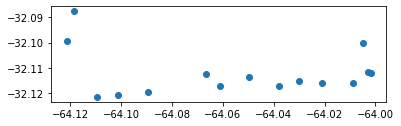

In [97]:
supercell.centroid.plot()

In [115]:
ota = supercell.area_polygon.values
mintb = supercell.mintb.values
hgt = supercell.ot_depth.values

In [116]:
times = pd.to_datetime(supercell.time)

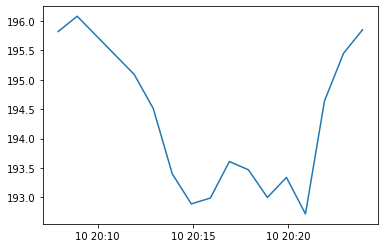

In [117]:
plt.plot(times, mintb)

In [114]:
plt.plot(times, np.gradient(hgt)*16.6667)

NameError: name 'times' is not defined

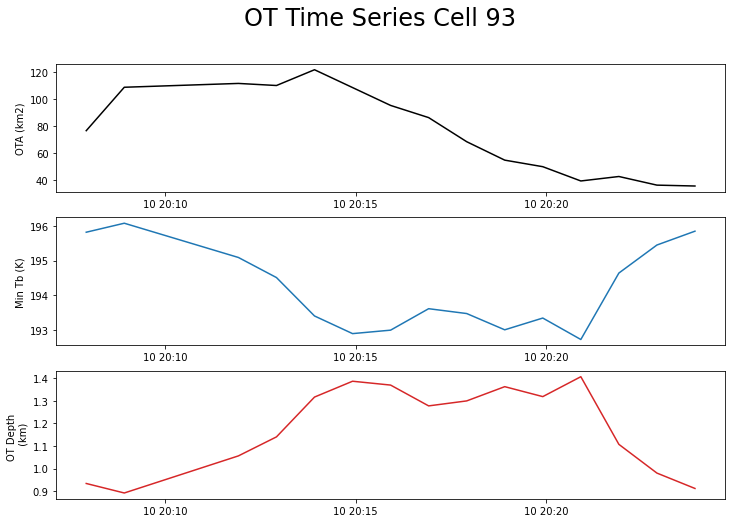

In [125]:
plt.figure(figsize=(12, 8))

ax = plt.subplot(311)
ax.plot(times, ota, color='black')
plt.ylabel('OTA (km2)')

ax = plt.subplot(312)
ax.plot(times, mintb, color='tab:blue')
plt.ylabel('Min Tb (K)')

ax = plt.subplot(313)
ax.plot(times, hgt, color='tab:red')
plt.ylabel('OT Depth \n (km)')

plt.suptitle('OT Time Series Cell 93', fontsize=24)

plt.savefig('cell93_timeseries.png', dpi=300)

In [22]:
duration = cells_grouped.count().area_polygon.values
max_depth = cells_grouped.max().ot_depth.values
mean_depth = cells_grouped.mean().ot_depth.values
max_otarea = cells_grouped.max().area_polygon.values
mean_otarea = cells_grouped.mean().area_polygon.values

In [23]:
df_max = cells_grouped.max()
df_max['duration']= cells_grouped.count().area_polygon

#cells_grouped.count().area_polygon

<AxesSubplot:ylabel='Frequency'>

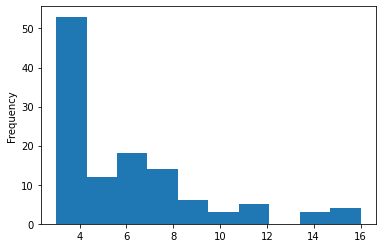

In [25]:
df_max[df_max.duration >2].duration.plot.hist()

In [26]:
def plot_regression(x, y, xlabel='OT Duration (minutes)', ylabel='OT Area ($km^{2}$)', plot_label = 'OT Duration 10 November 2018 \n 1500 - 2359 UTC (Count = 179)'):
    slope, intercept, r, p, stderr = scipy.stats.linregress(x, y)
    
    line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'
    
    plt.figure(figsize=(10,8))
    ax = plt.subplot(111)
    ax.scatter(x, y)
    ax.plot(np.array(x), intercept + slope * np.array(x), label=line, color='black')

    plt.ylabel(ylabel, fontsize=12)
    plt.xlabel(xlabel, fontsize=12)

    plt.legend(loc='upper right', fontsize=12)

    plt.title(plot_label, fontsize=16)

In [41]:
ota_bins = np.arange(0, 225, 25)
otd_bins = np.arange(0, 4, .2)
dur_bins = np.arange(3, 16, 1)

Text(0, 0.5, 'Frequency')

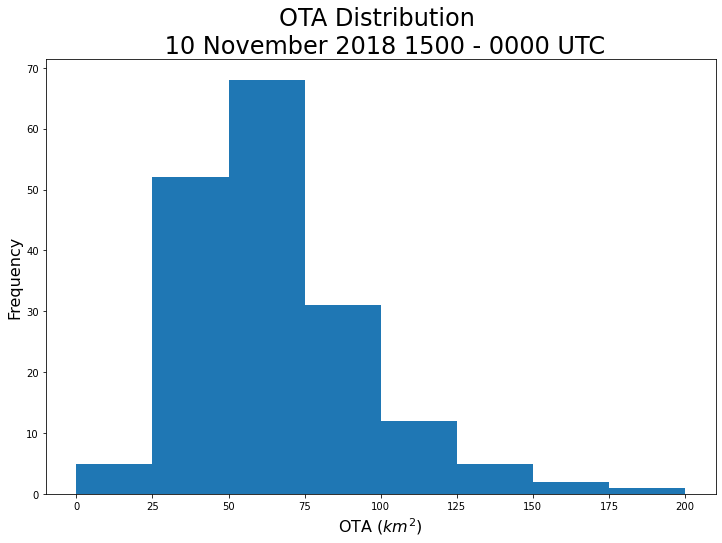

In [34]:
fig = plt.figure(figsize=(12,8))
plt.hist(df_max.area_polygon, bins=ota_bins)

plt.title('OTA Distribution \n 10 November 2018 1500 - 0000 UTC', fontsize=24)

plt.xlabel('OTA ($km^2$)', fontsize=16)
plt.ylabel('Frequency', fontsize=16)

Text(0, 0.5, 'Frequency')

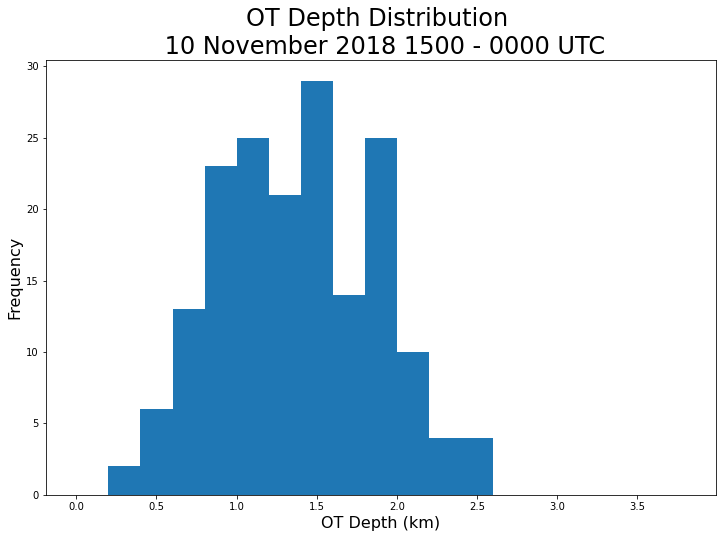

In [35]:
fig = plt.figure(figsize=(12,8))
plt.hist(df_max.ot_depth, bins=otd_bins)

plt.title('OT Depth Distribution \n 10 November 2018 1500 - 0000 UTC', fontsize=24)

plt.xlabel('OT Depth (km)', fontsize=16)
plt.ylabel('Frequency', fontsize=16)

Text(0, 0.5, 'Frequency')

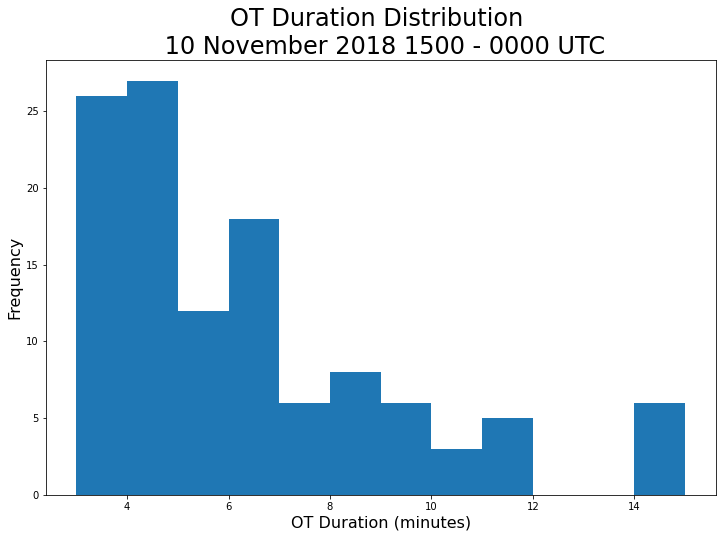

In [36]:
fig = plt.figure(figsize=(12,8))
plt.hist(df_max.duration, bins=dur_bins)

plt.title('OT Duration Distribution \n 10 November 2018 1500 - 0000 UTC', fontsize=24)

plt.xlabel('OT Duration (minutes)', fontsize=16)
plt.ylabel('Frequency', fontsize=16)

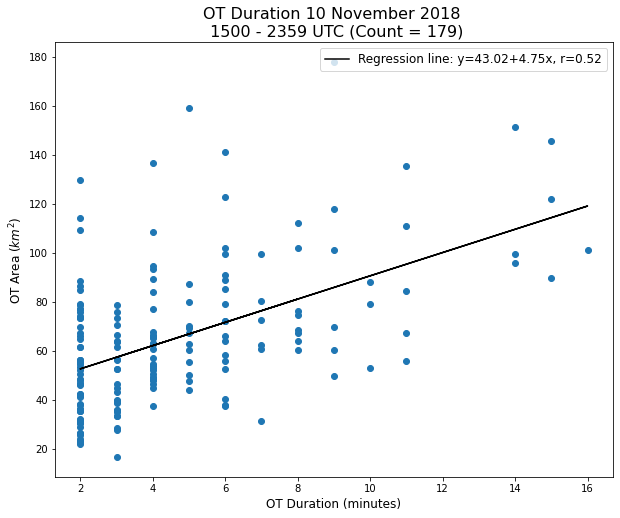

In [38]:
plot_regression(df_max.duration, df_max.area_polygon)

In [188]:
slope, intercept, r, p, stderr = scipy.stats.linregress(duration, max_otarea)

In [189]:
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'
line

'Regression line: y=43.19+4.73x, r=0.52'

In [190]:
slope, intercept, r, p, stderr = scipy.stats.linregress(duration, mean_otarea)
r

0.35167524403770134

In [191]:
len(duration)

177

Text(0.5, 1.0, 'OT Duration 10 November 2018 \n 1500 - 2359 UTC (Count = 179)')

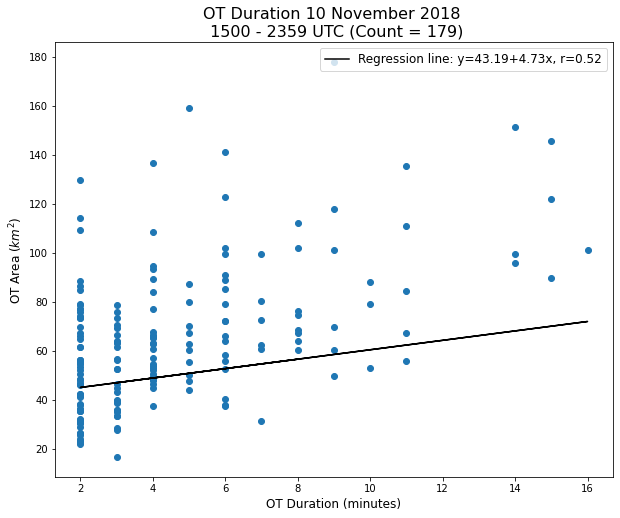

In [192]:
plt.figure(figsize=(10,8))
ax = plt.subplot(111)
ax.scatter(duration, max_otarea)
ax.plot(np.array(duration), intercept + slope * np.array(duration), label=line, color='black')

plt.ylabel('OT Area ($km^{2}$)', fontsize=12)
plt.xlabel('OT Duration (minutes)', fontsize=12)

plt.legend(loc='upper right', fontsize=12)

plt.title('OT Duration 10 November 2018 \n 1500 - 2359 UTC (Count = 179)', fontsize=16)

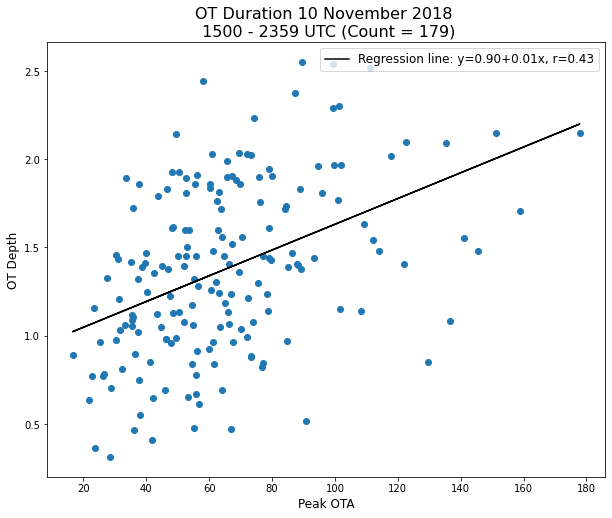

In [198]:
plot_regression(max_otarea, max_depth, xlabel='Peak OTA', ylabel='OT Depth')

(array([ 7., 10., 25., 27., 30., 26., 19., 22.,  6.,  5.]),
 array([0.31200027, 0.5361002 , 0.76020012, 0.98430004, 1.20839996,
        1.43249989, 1.65659981, 1.88069973, 2.10479965, 2.32889957,
        2.5529995 ]),
 <BarContainer object of 10 artists>)

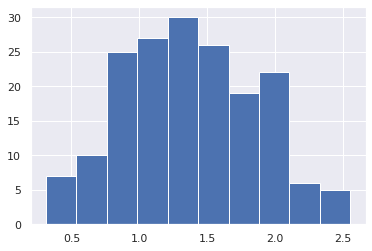

In [202]:
import seaborn as sns
sns.set()
plt.hist(max_depth)

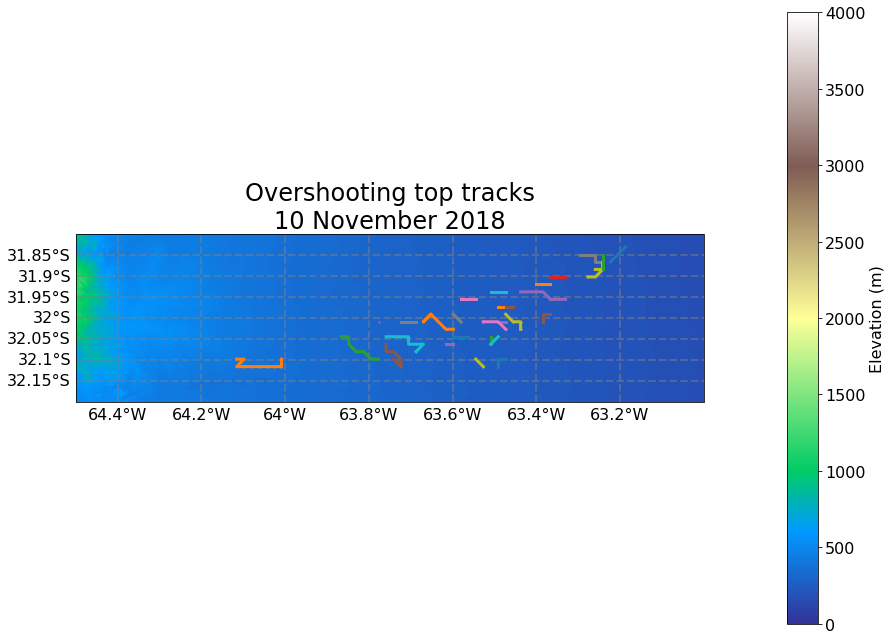

In [124]:
llcrnr=[-32.2, -64.5]
urcrnr=[-31.8, -63.]

# Set extent of maps created in the following cells:
axis_extent=[llcrnr[1],urcrnr[1],llcrnr[0],urcrnr[0]]    

# Plot map with all individual tracks:
import cartopy.crs as ccrs
fig_map,ax_map=plt.subplots(figsize=(15,15),subplot_kw={'projection': ccrs.PlateCarree()})

ax_map.coastlines()

ax_map.set_extent(axis_extent)

for ds in ds_list:
#    cm = ax.contourf(ds.x.values[::5], ds.y.values[::5], ds.values[::5,::5], levs, cmap='terrain', transform=ccrs.PlateCarree())
    cm = ax_map.imshow(ds.values, extent =[ds.x.min(),ds.x.max(),ds.y.min(),ds.y.max()], transform=ccrs.PlateCarree(), vmin=0, vmax=4000, cmap='terrain')

gl = ax_map.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')

gl.top_labels = False
gl.left_labels= True
gl.right_labels = False
gl.xlabel_style = {'size': 16, 'color': 'k'}
gl.ylabel_style = {'size': 16, 'color': 'k'}

for name, group in cells_grouped:
#    print(group.x,group.y)
    plt.plot(group.lon,group.lat,"-o",markersize=1, linewidth=3)

cb = plt.colorbar(cm,label='Elevation (m)',shrink=0.75, pad=0.1)
cb.ax.tick_params(labelsize=16)
cb.set_label('Elevation (m)', fontsize=16)

ax_map.set_title('Overshooting top tracks\n10 November 2018', fontsize=24)
plt.savefig('ot_10_nov.png', dpi=300)

Text(0.5, 1.0, 'Overshooting top tracks\n10 November 2018')

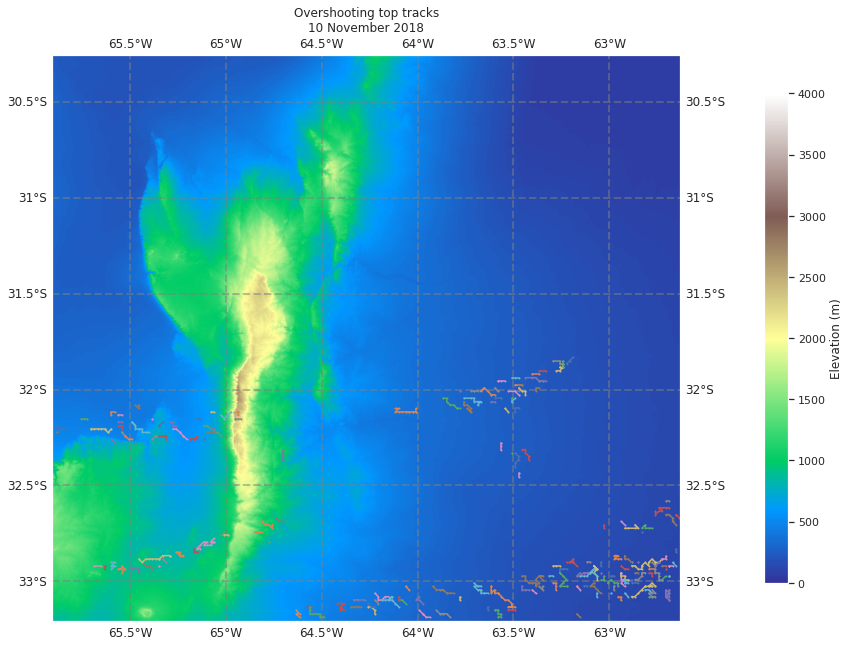

In [203]:
llcrnr=[-33.206342, -65.906586]
urcrnr=[-30.255825, -62.630553]

# Set extent of maps created in the following cells:
axis_extent=[llcrnr[1],urcrnr[1],llcrnr[0],urcrnr[0]]    

# Plot map with all individual tracks:
import cartopy.crs as ccrs
fig_map,ax_map=plt.subplots(figsize=(15,15),subplot_kw={'projection': ccrs.PlateCarree()})

ax_map.coastlines()

ax_map.set_extent(axis_extent)

for ds in ds_list:
#    cm = ax.contourf(ds.x.values[::5], ds.y.values[::5], ds.values[::5,::5], levs, cmap='terrain', transform=ccrs.PlateCarree())
    cm = ax_map.imshow(ds.values, extent =[ds.x.min(),ds.x.max(),ds.y.min(),ds.y.max()], transform=ccrs.PlateCarree(), vmin=0, vmax=4000, cmap='terrain')

gl = ax_map.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')

for name, group in cells_grouped:
#    print(group.x,group.y)
    plt.plot(group.lon,group.lat,"-o",markersize=1)

plt.colorbar(cm,label='Elevation (m)',shrink=0.6, pad=0.1)

ax_map.set_title('Overshooting top tracks\n10 November 2018')

Text(0.5, 1.0, 'Overshooting top tracks\n10 November 2018')

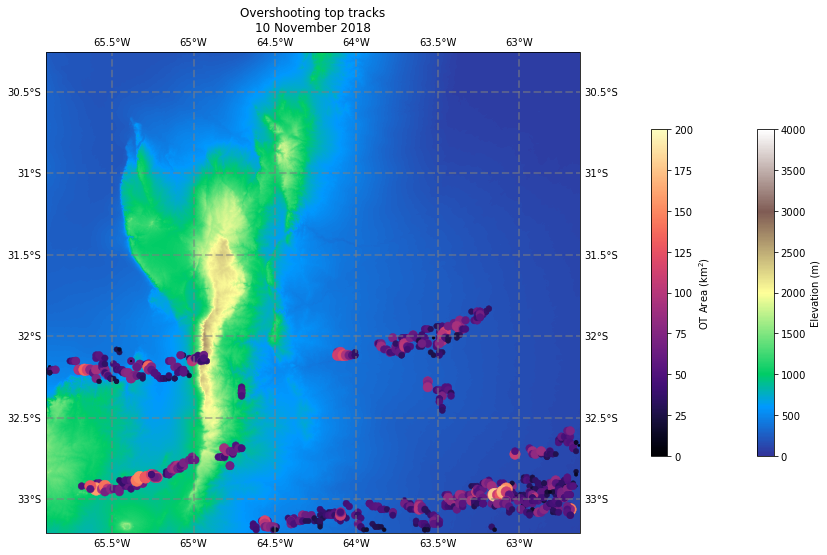

In [171]:
llcrnr=[-33.206342, -65.906586]
urcrnr=[-30.255825, -62.630553]

# Set extent of maps created in the following cells:
axis_extent=[llcrnr[1],urcrnr[1],llcrnr[0],urcrnr[0]]    

# Plot map with all individual tracks:
import cartopy.crs as ccrs
fig_map,ax_map=plt.subplots(figsize=(15,15),subplot_kw={'projection': ccrs.PlateCarree()})

ax_map.coastlines()

ax_map.set_extent(axis_extent)

for ds in ds_list:
#    cm = ax.contourf(ds.x.values[::5], ds.y.values[::5], ds.values[::5,::5], levs, cmap='terrain', transform=ccrs.PlateCarree())
    cm = ax_map.imshow(ds.values, extent =[ds.x.min(),ds.x.max(),ds.y.min(),ds.y.max()], transform=ccrs.PlateCarree(), vmin=0, vmax=4000, cmap='terrain')

gl = ax_map.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')

for name, group in cells_grouped:
#    print(group.x,group.y)
    cm2 = plt.scatter(group.lon,group.lat,c=group.area_polygon,vmin=0.,vmax=200.,s=group.area_polygon,
                     facecolors='none',cmap='magma',linewidth=0.5)

plt.colorbar(cm,label='Elevation (m)',shrink=0.4, pad=0.0)
plt.colorbar(cm2,label='OT Area (km$^2$)',shrink=0.4, pad=0.1)



ax_map.set_title('Overshooting top tracks\n10 November 2018')

---
## 12 November Case

In [49]:
df = pd.concat([pd.read_csv(f) for f in sorted(glob.glob('ot_output/20181112/20181112*'))], ignore_index = True).drop(columns='Unnamed: 0')

In [50]:
df['geometry'] = df['geometry'].apply(wkt.loads)
geo_df = gpd.GeoDataFrame(df, geometry='geometry')

df = geo_df

df['diff'] = pd.to_datetime(df['time']) - pd.datetime(2018,11,1)
df['frame'] = df['diff'].dt.days*86400+df['diff'].dt.seconds
df['frame'] = df['frame'] - df['frame'].min()
df['ot_depth'] = df['cloudtop_height'] - df['tropopause_height']

df = df[df.ot_depth > 0]

/data/keeling/a/mgrover4/a/miniconda3/envs/xesmf_env/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  


In [51]:
df = df[df.prob > .7]

df_track = deepcopy(df)
#df_track.rename(columns={'lon':'x', 'lat':'y'}, inplace=True)
#df_track['z'] = 0
df_track['states'] = 0
df_track['label'] = 0

radius=6371228.

globe = ccrs.Globe(ellipse=None, semimajor_axis=radius, 
                   semiminor_axis=radius)

projection=ccrs.LambertAzimuthalEqualArea(central_latitude=-32.,
                                          central_longitude=-62.,globe=globe)

prj=pyproj.Proj(projection.proj4_init)

df_track['x'], df_track['y'] = prj(df_track['lon'].values, df_track['lat'].values)


df_track.to_csv('test.csv')

In [52]:
v_max=60.
stubs=2
order=1
extrapolate=1
memory=1
adaptive_stop=0.01
adaptive_step=0.99
subnetwork_size=100
method_linking= 'predict'
cell_number_start=1
dt = 60.
dxy = 2000.

search_range=dt*v_max

features_linking=deepcopy(df_track)

pred = tp.predict.NearestVelocityPredict(span=1)
trajectories_unfiltered = pred.link_df(features_linking, search_range=search_range, memory=memory,
                                 pos_columns=['x','y'],
                                 t_column='frame',
                                 neighbor_strategy='KDTree', link_strategy='auto',
                                 adaptive_step=adaptive_step,adaptive_stop=adaptive_stop
#                                 copy_features=False, diagnostics=False,
#                                 hash_size=None, box_size=None, verify_integrity=True,
#                                 retain_index=False
                                 )

trajectories_unfiltered['cell']=None
for i_particle,particle in enumerate(pd.Series.unique(trajectories_unfiltered['particle'])):
    cell=int(i_particle+cell_number_start)
    trajectories_unfiltered.loc[trajectories_unfiltered['particle']==particle,'cell']=cell
trajectories_unfiltered.drop(columns=['particle'],inplace=True)

trajectories_bycell=trajectories_unfiltered.groupby('cell')

num_stubs = 0

for cell,trajectories_cell in trajectories_bycell:
#    logging.debug("cell: "+str(cell))
#    logging.debug("feature: "+str(trajectories_cell['feature'].values))
#    logging.debug("trajectories_cell.shape[0]: "+ str(trajectories_cell.shape[0]))


    if trajectories_cell.shape[0] < stubs:
#        print("cell" + str(cell)+ "  is a stub ("+str(trajectories_cell.shape[0])+ "), setting cell number to Nan..")
        trajectories_unfiltered.loc[trajectories_unfiltered['cell']==cell,'cell']=np.nan
        num_stubs = num_stubs + 1

print('found this many stubs: {}'.format(num_stubs))

trajectories_filtered=trajectories_unfiltered.dropna()

Frame 15720: 1 trajectories present.
found this many stubs: 142


In [47]:
len(trajectories_filtered)

346

In [54]:
cells_grouped = trajectories_filtered.groupby('cell')
df_max = cells_grouped.max()
df_max['duration']= cells_grouped.count().area_polygon

df_max = df_max[df_max.duration > 2]

Text(0.5, 1.0, 'OT Duration 12 November 2018 \n 0000 - 0600 UTC (Count = 563)')

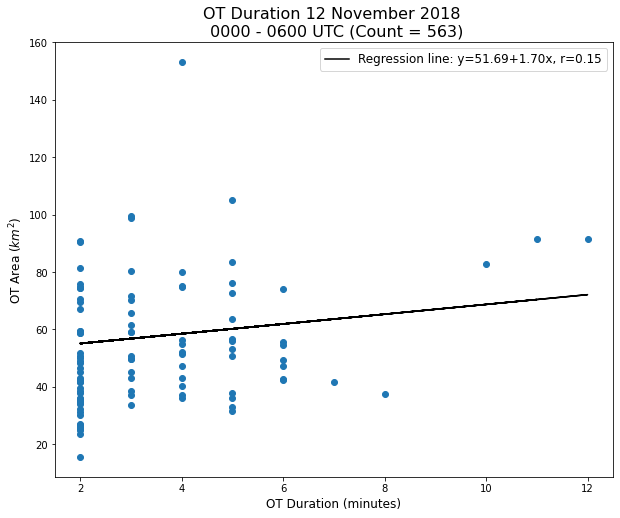

In [56]:


duration = cells_grouped.count().area_polygon.values
max_depth = cells_grouped.max().ot_depth.values
mean_depth = cells_grouped.mean().ot_depth.values
max_otarea = cells_grouped.max().area_polygon.values
mean_otarea = cells_grouped.mean().area_polygon.values

slope, intercept, r, p, stderr = scipy.stats.linregress(df_max.duration, df_max.area_polygon)

line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

plt.figure(figsize=(10,8))
ax = plt.subplot(111)
ax.scatter(duration, max_otarea)
ax.plot(np.array(duration), intercept + slope * np.array(duration), label=line, color='black')

plt.ylabel('OT Area ($km^{2}$)', fontsize=12)
plt.xlabel('OT Duration (minutes)', fontsize=12)

plt.legend(loc='upper right', fontsize=12)

plt.title('OT Duration 12 November 2018 \n 0000 - 0600 UTC (Count = 563)', fontsize=16)

Text(0, 0.5, 'Frequency')

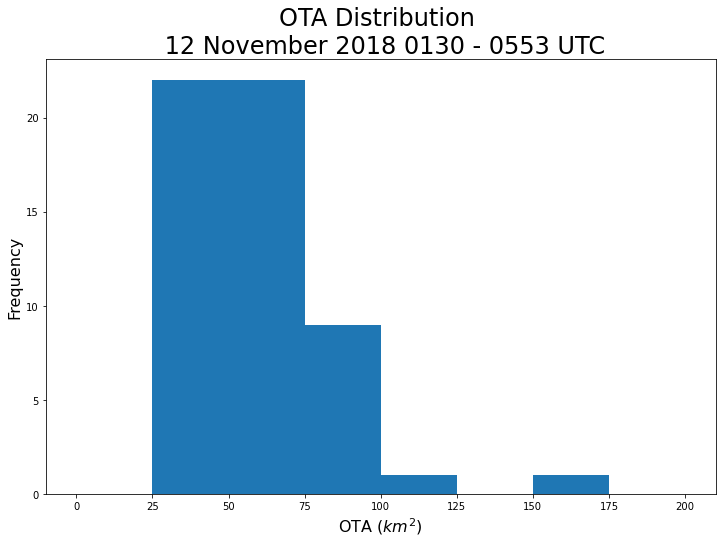

In [57]:
fig = plt.figure(figsize=(12,8))
plt.hist(df_max.area_polygon, bins=ota_bins)

plt.title('OTA Distribution \n 12 November 2018 0130 - 0553 UTC', fontsize=24)

plt.xlabel('OTA ($km^2$)', fontsize=16)
plt.ylabel('Frequency', fontsize=16)

Text(0, 0.5, 'Frequency')

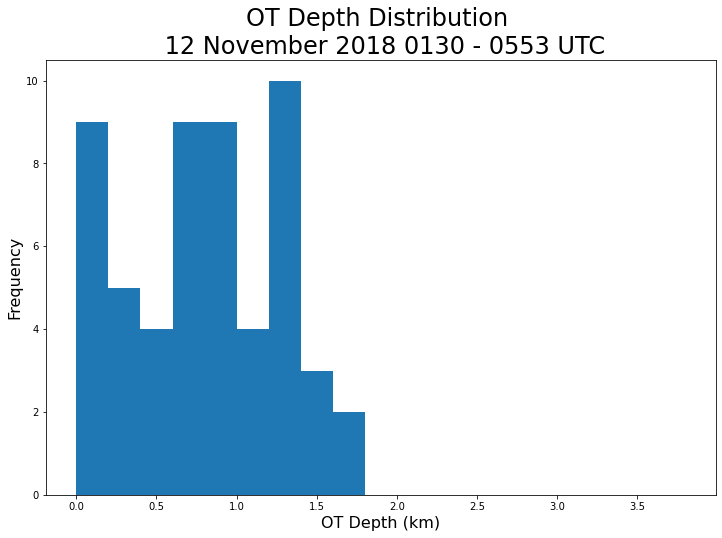

In [58]:
fig = plt.figure(figsize=(12,8))
plt.hist(df_max.ot_depth, bins=otd_bins)

plt.title('OT Depth Distribution \n 12 November 2018 0130 - 0553 UTC', fontsize=24)

plt.xlabel('OT Depth (km)', fontsize=16)
plt.ylabel('Frequency', fontsize=16)

Text(0, 0.5, 'Frequency')

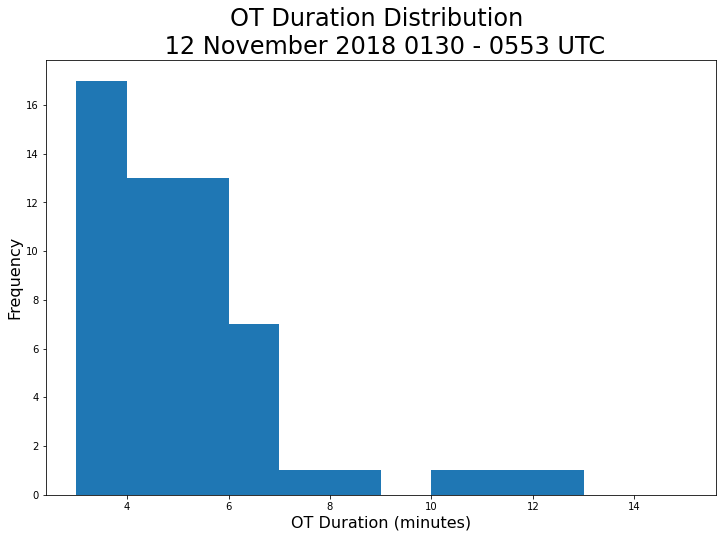

In [59]:
fig = plt.figure(figsize=(12,8))
plt.hist(df_max.duration, bins=dur_bins)

plt.title('OT Duration Distribution \n 12 November 2018 0130 - 0553 UTC', fontsize=24)

plt.xlabel('OT Duration (minutes)', fontsize=16)
plt.ylabel('Frequency', fontsize=16)

In [217]:
df_track['Time'] = pd.to_datetime(df_track.time)

In [218]:
from datetime import datetime

In [219]:
df = df_track[(df_track['Time'] > datetime(2018, 11, 12, 2, 30))][(df_track.Time < datetime(2018, 11, 12, 2, 34))]

/data/keeling/a/mgrover4/a/miniconda3/envs/xesmf_env/lib/python3.7/site-packages/geopandas/geodataframe.py:546: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super(GeoDataFrame, self).__getitem__(key)


In [220]:
df.columns

Index(['area_polygon', 'cloudtop_height', 'e_radial', 'e_radial_del2', 'e_tb',
       'geometry', 'lat', 'lat_corr', 'lon', 'lon_corr', 'mintb', 'n_radial',
       'n_radial_del2', 'n_tb', 'ne_radial', 'ne_radial_del2', 'ne_tb',
       'nw_radial', 'nw_radial_del2', 'nw_tb', 'otid', 'prob', 's_radial',
       's_radial_del2', 's_tb', 'se_radial', 'se_radial_del2', 'se_tb',
       'sw_radial', 'sw_radial_del2', 'sw_tb', 'time', 'tropopause_height',
       'tropopause_pressure', 'tropopause_temperature', 'w_radial',
       'w_radial_del2', 'w_tb', 'diff', 'frame', 'states', 'label', 'x', 'y',
       'Time'],
      dtype='object')

<AxesSubplot:>

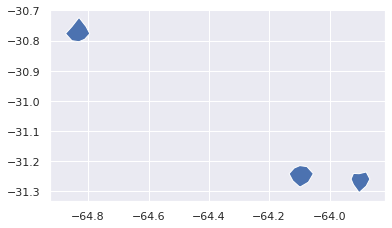

In [221]:
df[(df.lat > -31.4) & (df.lon < -63.8)].plot()

Text(0.5, 1.0, 'Overshooting top tracks\n12 November 2018')

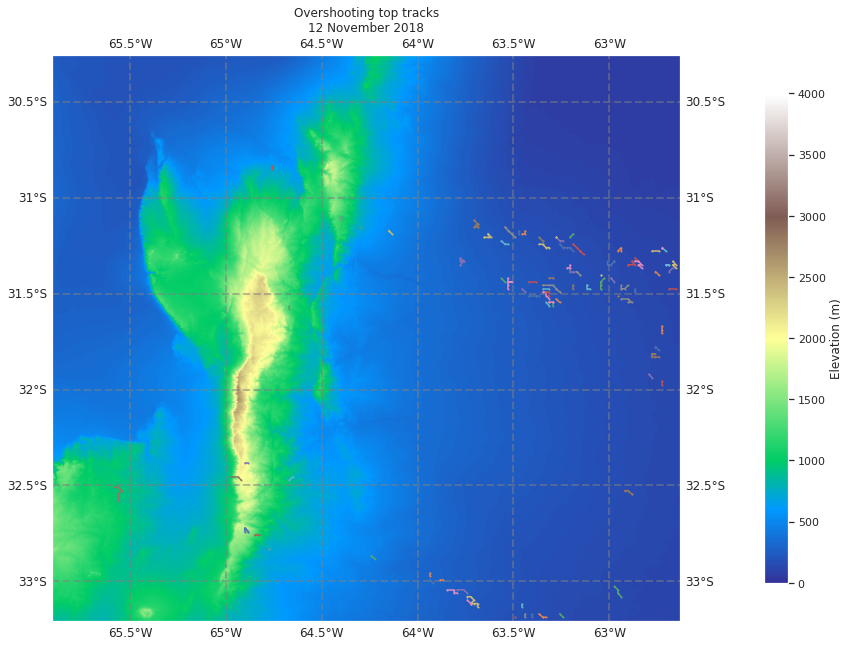

In [222]:
llcrnr=[-33.206342, -65.906586]
urcrnr=[-30.255825, -62.630553]

# Set extent of maps created in the following cells:
axis_extent=[llcrnr[1],urcrnr[1],llcrnr[0],urcrnr[0]]    

# Plot map with all individual tracks:
import cartopy.crs as ccrs
fig_map,ax_map=plt.subplots(figsize=(15,15),subplot_kw={'projection': ccrs.PlateCarree()})

ax_map.coastlines()

ax_map.set_extent(axis_extent)

for ds in ds_list:
#    cm = ax.contourf(ds.x.values[::5], ds.y.values[::5], ds.values[::5,::5], levs, cmap='terrain', transform=ccrs.PlateCarree())
    cm = ax_map.imshow(ds.values, extent =[ds.x.min(),ds.x.max(),ds.y.min(),ds.y.max()], transform=ccrs.PlateCarree(), vmin=0, vmax=4000, cmap='terrain')

gl = ax_map.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')

for name, group in cells_grouped:
#    print(group.x,group.y)
    plt.plot(group.lon,group.lat,"-o",markersize=1)

plt.colorbar(cm,label='Elevation (m)',shrink=0.6, pad=0.1)

ax_map.set_title('Overshooting top tracks\n12 November 2018')

Text(0.5, 1.0, 'Overshooting top tracks\n12 November 2018')

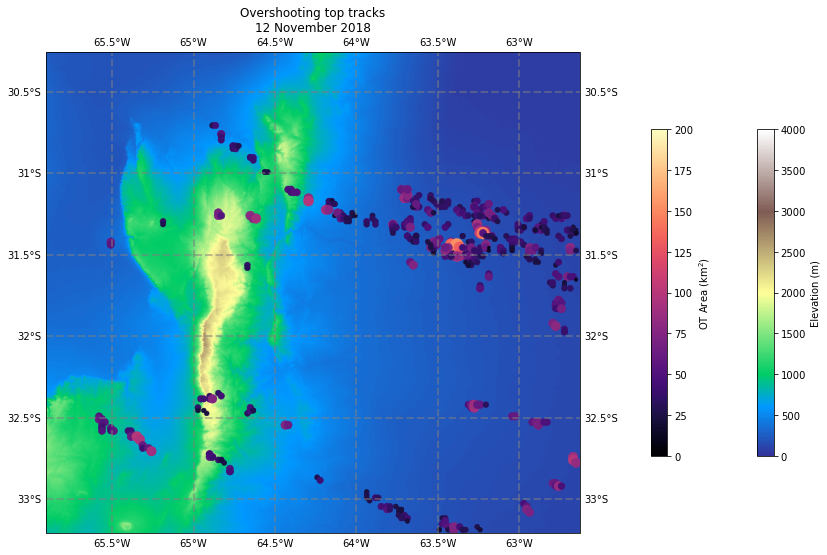

In [242]:
llcrnr=[-33.206342, -65.906586]
urcrnr=[-30.255825, -62.630553]

# Set extent of maps created in the following cells:
axis_extent=[llcrnr[1],urcrnr[1],llcrnr[0],urcrnr[0]]    

# Plot map with all individual tracks:
import cartopy.crs as ccrs
fig_map,ax_map=plt.subplots(figsize=(15,15),subplot_kw={'projection': ccrs.PlateCarree()})

ax_map.coastlines()

ax_map.set_extent(axis_extent)

for ds in ds_list:
#    cm = ax.contourf(ds.x.values[::5], ds.y.values[::5], ds.values[::5,::5], levs, cmap='terrain', transform=ccrs.PlateCarree())
    cm = ax_map.imshow(ds.values, extent =[ds.x.min(),ds.x.max(),ds.y.min(),ds.y.max()], transform=ccrs.PlateCarree(), vmin=0, vmax=4000, cmap='terrain')

gl = ax_map.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')

for name, group in cells_grouped:
#    print(group.x,group.y)
    cm2 = plt.scatter(group.lon,group.lat,c=group.area_polygon,vmin=0.,vmax=200.,s=group.area_polygon,
                     facecolors='none',cmap='magma',linewidth=0.5)

plt.colorbar(cm,label='Elevation (m)',shrink=0.4, pad=0.0)
plt.colorbar(cm2,label='OT Area (km$^2$)',shrink=0.4, pad=0.1)



ax_map.set_title('Overshooting top tracks\n12 November 2018')

## 14 December Case

In [21]:
df = pd.concat([pd.read_csv(f) for f in sorted(glob.glob('ot_output/20181214/20181214*'))], ignore_index = True).drop(columns='Unnamed: 0')

In [22]:
df['geometry'] = df['geometry'].apply(wkt.loads)
geo_df = gpd.GeoDataFrame(df, geometry='geometry')

df['ot_depth'] = df['cloudtop_height'] - df['tropopause_height']
df = df[df.ot_depth > 0]

df = geo_df

df['diff'] = pd.to_datetime(df['time']) - pd.datetime(2018,11,1)
df['frame'] = df['diff'].dt.days*86400+df['diff'].dt.seconds
df['frame'] = df['frame'] - df['frame'].min()

df = df[df.prob > .7]

df_track = deepcopy(df)
#df_track.rename(columns={'lon':'x', 'lat':'y'}, inplace=True)
#df_track['z'] = 0
df_track['states'] = 0
df_track['label'] = 0

radius=6371228.

globe = ccrs.Globe(ellipse=None, semimajor_axis=radius, 
                   semiminor_axis=radius)

projection=ccrs.LambertAzimuthalEqualArea(central_latitude=-32.,
                                          central_longitude=-62.,globe=globe)

prj=pyproj.Proj(projection.proj4_init)

df_track['x'], df_track['y'] = prj(df_track['lon'].values, df_track['lat'].values)


df_track.to_csv('test.csv')

v_max=60.
stubs=2
order=1
extrapolate=1
memory=1
adaptive_stop=0.01
adaptive_step=0.99
subnetwork_size=100
method_linking= 'predict'
cell_number_start=1
dt = 60.
dxy = 2000.

search_range=dt*v_max

features_linking=deepcopy(df_track)

pred = tp.predict.NearestVelocityPredict(span=1)
trajectories_unfiltered = pred.link_df(features_linking, search_range=search_range, memory=memory,
                                 pos_columns=['x','y'],
                                 t_column='frame',
                                 neighbor_strategy='KDTree', link_strategy='auto',
                                 adaptive_step=adaptive_step,adaptive_stop=adaptive_stop
#                                 copy_features=False, diagnostics=False,
#                                 hash_size=None, box_size=None, verify_integrity=True,
#                                 retain_index=False
                                 )

trajectories_unfiltered['cell']=None
for i_particle,particle in enumerate(pd.Series.unique(trajectories_unfiltered['particle'])):
    cell=int(i_particle+cell_number_start)
    trajectories_unfiltered.loc[trajectories_unfiltered['particle']==particle,'cell']=cell
trajectories_unfiltered.drop(columns=['particle'],inplace=True)

trajectories_bycell=trajectories_unfiltered.groupby('cell')

num_stubs = 0

for cell,trajectories_cell in trajectories_bycell:
#    logging.debug("cell: "+str(cell))
#    logging.debug("feature: "+str(trajectories_cell['feature'].values))
#    logging.debug("trajectories_cell.shape[0]: "+ str(trajectories_cell.shape[0]))


    if trajectories_cell.shape[0] < stubs:
#        print("cell" + str(cell)+ "  is a stub ("+str(trajectories_cell.shape[0])+ "), setting cell number to Nan..")
        trajectories_unfiltered.loc[trajectories_unfiltered['cell']==cell,'cell']=np.nan
        num_stubs = num_stubs + 1

print('found this many stubs: {}'.format(num_stubs))

trajectories_filtered=trajectories_unfiltered.dropna()

Frame 23700: 1 trajectories present.
found this many stubs: 988


In [23]:
trajectories_filtered.time.max()

'2018-12-14 06:35:25.000000512'

In [24]:
cells_grouped = trajectories_filtered.groupby('cell')
df_max = cells_grouped.max()
df_max['duration']= cells_grouped.count().area_polygon

df_max = df_max[df_max.duration > 2]

Text(0.5, 1.0, 'OT Duration 14 December 2018 \n 0000 - 0635 UTC (Count = 710)')

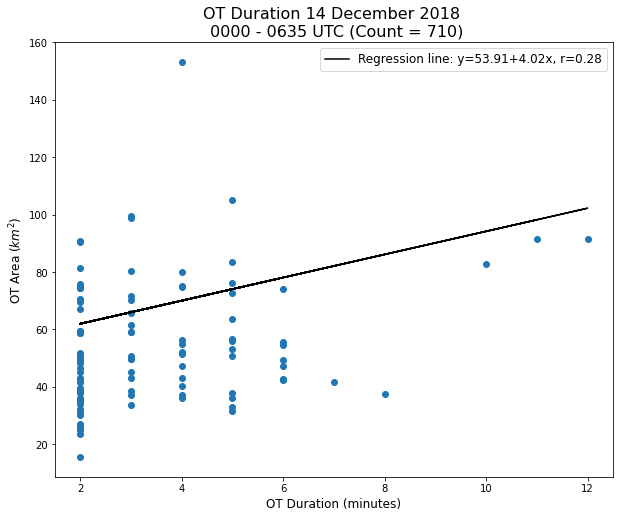

In [66]:
slope, intercept, r, p, stderr = scipy.stats.linregress(df_max.duration, df_max.area_polygon)

line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

plt.figure(figsize=(10,8))
ax = plt.subplot(111)
ax.scatter(duration, max_otarea)
ax.plot(np.array(duration), intercept + slope * np.array(duration), label=line, color='black')

plt.ylabel('OT Area ($km^{2}$)', fontsize=12)
plt.xlabel('OT Duration (minutes)', fontsize=12)

plt.legend(loc='upper right', fontsize=12)

plt.title('OT Duration 14 December 2018 \n 0000 - 0635 UTC (Count = 710)', fontsize=16)

Text(0, 0.5, 'Frequency')

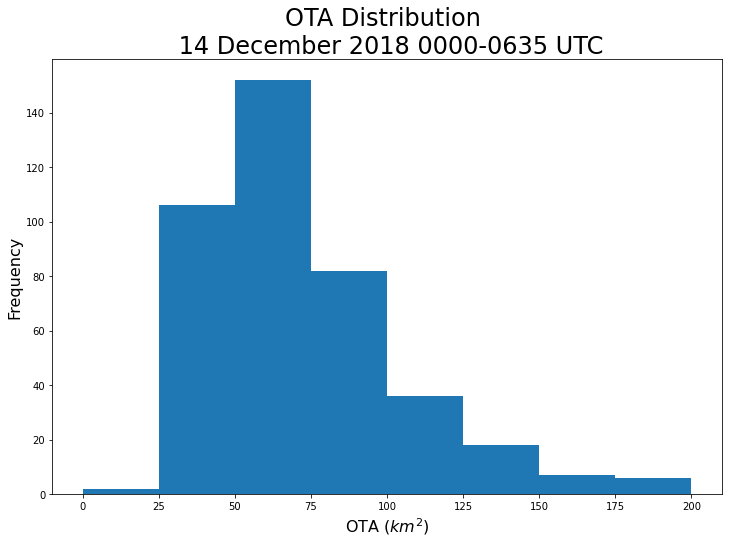

In [67]:
fig = plt.figure(figsize=(12,8))
plt.hist(df_max.area_polygon, bins=ota_bins)

plt.title('OTA Distribution \n 14 December 2018 0000-0635 UTC', fontsize=24)

plt.xlabel('OTA ($km^2$)', fontsize=16)
plt.ylabel('Frequency', fontsize=16)

Text(0, 0.5, 'Frequency')

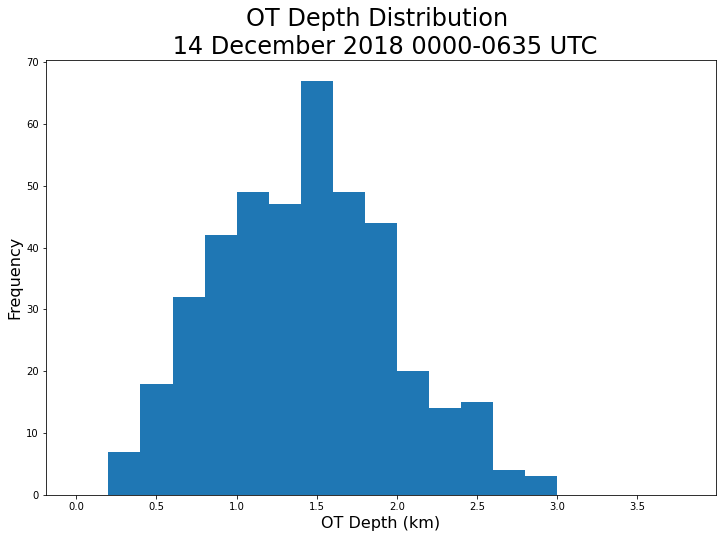

In [69]:
fig = plt.figure(figsize=(12,8))
plt.hist(df_max.ot_depth, bins=otd_bins)

plt.title('OT Depth Distribution \n 14 December 2018 0000-0635 UTC', fontsize=24)

plt.xlabel('OT Depth (km)', fontsize=16)
plt.ylabel('Frequency', fontsize=16)

Text(0, 0.5, 'Frequency')

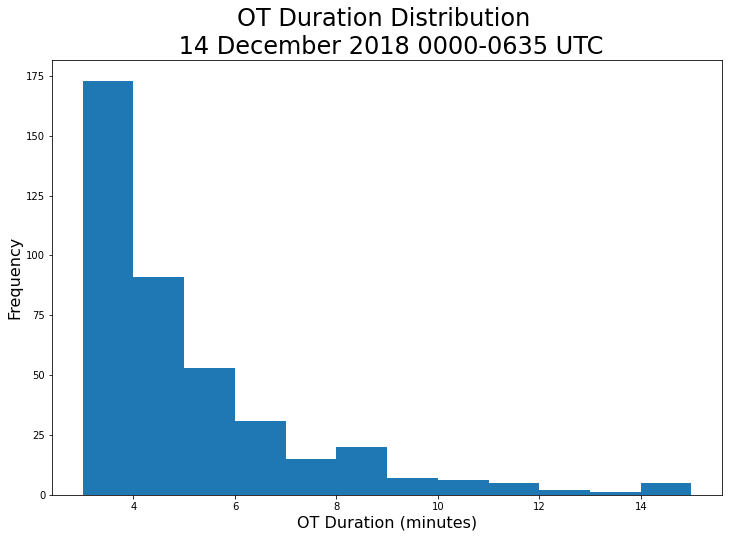

In [70]:
fig = plt.figure(figsize=(12,8))
plt.hist(df_max.duration, bins=dur_bins)

plt.title('OT Duration Distribution \n 14 December 2018 0000-0635 UTC', fontsize=24)

plt.xlabel('OT Duration (minutes)', fontsize=16)
plt.ylabel('Frequency', fontsize=16)

Text(0.5, 1.0, 'Overshooting top tracks\n14 December 2018')

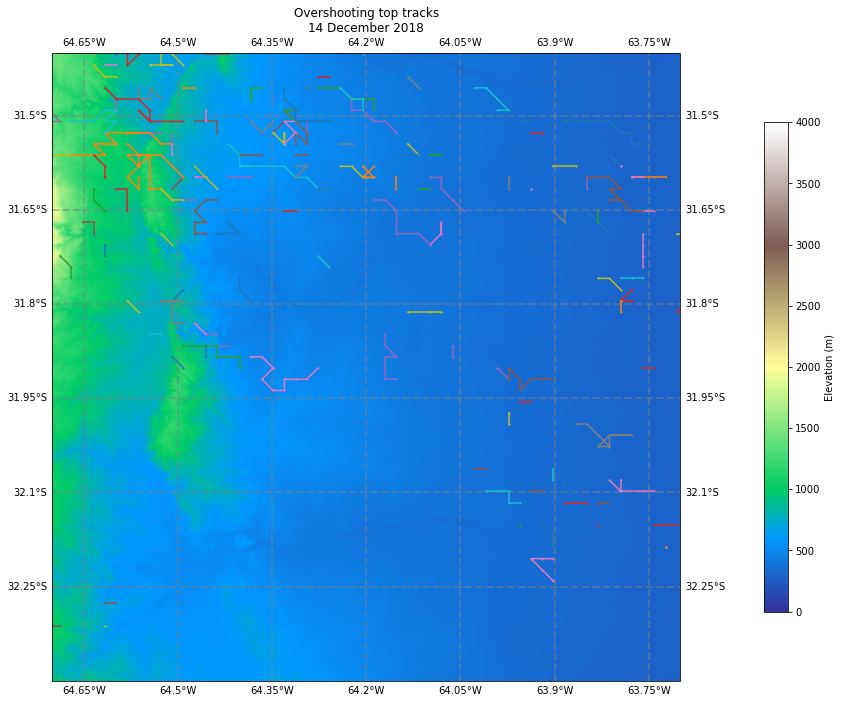

In [25]:
llcrnr=[-33.206342, -65.906586]
urcrnr=[-30.255825, -62.630553]

# Set extent of maps created in the following cells:
#axis_extent=[llcrnr[1],urcrnr[1],llcrnr[0],urcrnr[0]]
axis_extent=[-64.7, -63.7, -32.4, -31.4]  

# Plot map with all individual tracks:
import cartopy.crs as ccrs
fig_map,ax_map=plt.subplots(figsize=(15,15),subplot_kw={'projection': ccrs.PlateCarree()})

ax_map.coastlines()

ax_map.set_extent(axis_extent)

for ds in ds_list:
#    cm = ax.contourf(ds.x.values[::5], ds.y.values[::5], ds.values[::5,::5], levs, cmap='terrain', transform=ccrs.PlateCarree())
    cm = ax_map.imshow(ds.values, extent =[ds.x.min(),ds.x.max(),ds.y.min(),ds.y.max()], transform=ccrs.PlateCarree(), vmin=0, vmax=4000, cmap='terrain')

gl = ax_map.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')

for name, group in cells_grouped:
#    print(group.x,group.y)
    plt.plot(group.lon,group.lat,"-o",markersize=1)

plt.colorbar(cm,label='Elevation (m)',shrink=0.6, pad=0.1)

ax_map.set_title('Overshooting top tracks\n14 December 2018')

Text(0.5, 1.0, 'Overshooting top tracks\n14 December 2018')

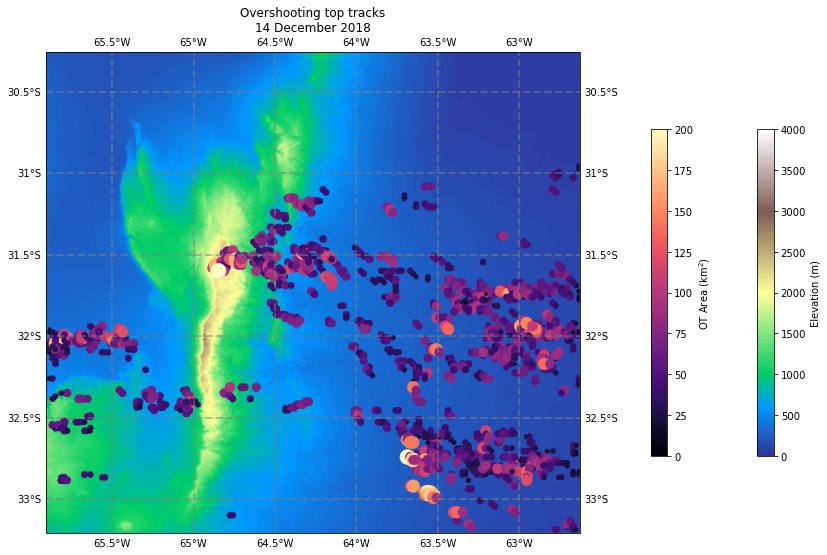

In [251]:
llcrnr=[-33.206342, -65.906586]
urcrnr=[-30.255825, -62.630553]

# Set extent of maps created in the following cells:
axis_extent=[llcrnr[1],urcrnr[1],llcrnr[0],urcrnr[0]]    

# Plot map with all individual tracks:
import cartopy.crs as ccrs
fig_map,ax_map=plt.subplots(figsize=(15,15),subplot_kw={'projection': ccrs.PlateCarree()})

ax_map.coastlines()

ax_map.set_extent(axis_extent)

for ds in ds_list:
#    cm = ax.contourf(ds.x.values[::5], ds.y.values[::5], ds.values[::5,::5], levs, cmap='terrain', transform=ccrs.PlateCarree())
    cm = ax_map.imshow(ds.values, extent =[ds.x.min(),ds.x.max(),ds.y.min(),ds.y.max()], transform=ccrs.PlateCarree(), vmin=0, vmax=4000, cmap='terrain')

gl = ax_map.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')

for name, group in cells_grouped:
#    print(group.x,group.y)
    cm2 = plt.scatter(group.lon,group.lat,c=group.area_polygon,vmin=0.,vmax=200.,s=group.area_polygon,
                     facecolors='none',cmap='magma',linewidth=0.5)

plt.colorbar(cm,label='Elevation (m)',shrink=0.4, pad=0.0)
plt.colorbar(cm2,label='OT Area (km$^2$)',shrink=0.4, pad=0.1)



ax_map.set_title('Overshooting top tracks\n14 December 2018')

---
## All OTs 

In [2]:
df = pd.concat([pd.read_csv(f) for f in sorted(glob.glob('ot_output/*/*'))], ignore_index = True).drop(columns='Unnamed: 0')

In [3]:
df['geometry'] = df['geometry'].apply(wkt.loads)
geo_df = gpd.GeoDataFrame(df, geometry='geometry')

df = geo_df
df['ot_depth'] = df.cloudtop_height - df.tropopause_height
df['btd'] = df.mintb - df.tropopause_temperature

df = df[df.ot_depth > 0]

df['diff'] = pd.to_datetime(df['time']) - pd.datetime(2018,11,1)
df['frame'] = df['diff'].dt.days*86400+df['diff'].dt.seconds
df['frame'] = df['frame'] - df['frame'].min()

df = df[df.prob > .8]

df_track = deepcopy(df)
#df_track.rename(columns={'lon':'x', 'lat':'y'}, inplace=True)
#df_track['z'] = 0
df_track['states'] = 0
df_track['label'] = 0

radius=6371228.

globe = ccrs.Globe(ellipse=None, semimajor_axis=radius, 
                   semiminor_axis=radius)

projection=ccrs.LambertAzimuthalEqualArea(central_latitude=-32.,
                                          central_longitude=-62.,globe=globe)

prj=pyproj.Proj(projection.proj4_init)

df_track['x'], df_track['y'] = prj(df_track['lon'].values, df_track['lat'].values)


df_track.to_csv('test.csv')

v_max=60.
stubs=2
order=1
extrapolate=1
memory=1
adaptive_stop=0.01
adaptive_step=0.99
subnetwork_size=100
method_linking= 'predict'
cell_number_start=1
dt = 60.
dxy = 2000.

search_range=dt*v_max

features_linking=deepcopy(df_track)

pred = tp.predict.NearestVelocityPredict(span=1)
trajectories_unfiltered = pred.link_df(features_linking, search_range=search_range, memory=memory,
                                 pos_columns=['x','y'],
                                 t_column='frame',
                                 neighbor_strategy='KDTree', link_strategy='auto',
                                 adaptive_step=adaptive_step,adaptive_stop=adaptive_stop
#                                 copy_features=False, diagnostics=False,
#                                 hash_size=None, box_size=None, verify_integrity=True,
#                                 retain_index=False
                                 )

trajectories_unfiltered['cell']=None
for i_particle,particle in enumerate(pd.Series.unique(trajectories_unfiltered['particle'])):
    cell=int(i_particle+cell_number_start)
    trajectories_unfiltered.loc[trajectories_unfiltered['particle']==particle,'cell']=cell
trajectories_unfiltered.drop(columns=['particle'],inplace=True)

trajectories_bycell=trajectories_unfiltered.groupby('cell')

num_stubs = 0

for cell,trajectories_cell in trajectories_bycell:
#    logging.debug("cell: "+str(cell))
#    logging.debug("feature: "+str(trajectories_cell['feature'].values))
#    logging.debug("trajectories_cell.shape[0]: "+ str(trajectories_cell.shape[0]))


    if trajectories_cell.shape[0] < stubs:
#        print("cell" + str(cell)+ "  is a stub ("+str(trajectories_cell.shape[0])+ "), setting cell number to Nan..")
        trajectories_unfiltered.loc[trajectories_unfiltered['cell']==cell,'cell']=np.nan
        num_stubs = num_stubs + 1

print('found this many stubs: {}'.format(num_stubs))

trajectories_filtered=trajectories_unfiltered.dropna(subset=['area_polygon', 'cell'])

Frame 2902710: 1 trajectories present.
found this many stubs: 974


In [4]:
df = trajectories_filtered

df['time'] = pd.to_datetime(trajectories_filtered.time)
df['day'] = df.time.dt.day
df['month'] = df.time.dt.month

/data/keeling/a/mgrover4/a/miniconda3/envs/xesmf_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/data/keeling/a/mgrover4/a/miniconda3/envs/xesmf_env/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/data/keeling/a/mgrover4/a/miniconda3/envs/xesmf_env/lib/python3.7/site-packages/ipykernel

In [5]:
cells_grouped = df.groupby('cell')
df_max = cells_grouped.max()
df_min = cells_grouped.min()

df_max['duration']= cells_grouped.count().area_polygon
df_min['duration'] = cells_grouped.count().area_polygon

df_max = df_max[df_max.duration > 2]
df_min = df_min[df_min.duration > 2]

In [6]:
df_max['day'] = df_min.day

In [7]:
nov_10 = df_max[(df_max.day == 10) | (df_max.day == 11)]
nov_12 = df_max[df_max.day == 12]
dec_14 = df_max[(df_max.day == 14) | (df_max.day == 13)]

In [14]:
nov_10 = df[df.day == 10]
nov_12 = df[df.day == 12]
dec_14 = df[df.day == 14]

/data/keeling/a/mgrover4/a/miniconda3/envs/xesmf_env/lib/python3.7/site-packages/ipykernel_launcher.py:31: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.


Text(0.5, 1.0, 'Peak OTA \n 14 December 2018')

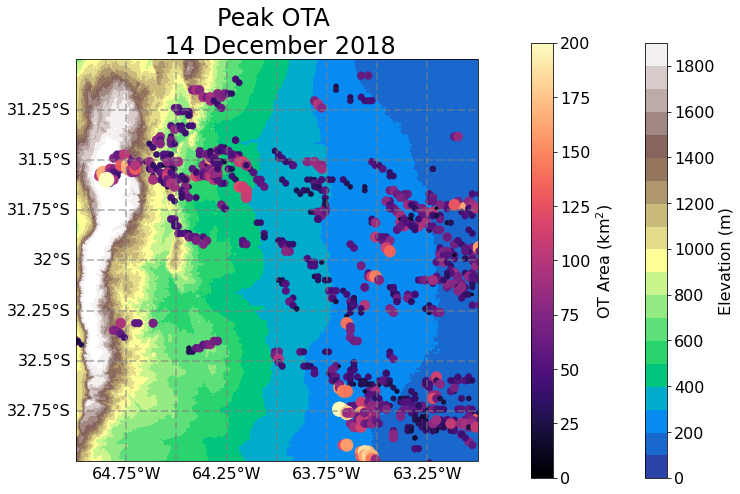

In [15]:
llcrnr=[-33.206342, -65.906586]
urcrnr=[-30.255825, -62.630553]

# Set extent of maps created in the following cells:
axis_extent=[-65, -63, -33, -31]     

# Plot map with all individual tracks:
import cartopy.crs as ccrs
fig_map,ax_map=plt.subplots(figsize=(12,8),subplot_kw={'projection': ccrs.PlateCarree()})
levs = np.arange(0, 2000, 100)

ax_map.coastlines()

ax_map.set_extent(axis_extent)

for ds in ds_list:
    cm = ax_map.contourf(ds.x.values[::5], ds.y.values[::5], ds.values[::5, ::5], levs, cmap='terrain', transform=ccrs.PlateCarree())


gl = ax_map.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.left_labels= True
gl.right_labels = False
gl.xlabel_style = {'size': 16, 'color': 'k'}
gl.ylabel_style = {'size': 16, 'color': 'k'}

cm2 = plt.scatter(dec_14.lon.values,dec_14.lat.values,c=dec_14.area_polygon.values,vmin=0.,vmax=200.,s=dec_14.area_polygon,
                     facecolors='none',cmap='magma',linewidth=0.5)

cbar = plt.colorbar(cm, extend='both', label='Elevation (m)')
cbar.set_label(label='Elevation (m)', fontsize=16)
cbar.ax.tick_params(labelsize=16)

cbar2 = plt.colorbar(cm2,label='OT Area (km$^2$)', pad=0.1)
cbar2.set_label(label='OT Area (km$^2$)', fontsize=16)
cbar2.ax.tick_params(labelsize=16)



ax_map.set_title('Peak OTA \n 14 December 2018', fontsize=24)

/data/keeling/a/mgrover4/a/miniconda3/envs/xesmf_env/lib/python3.7/site-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.


Text(0.5, 1.0, 'OT Duration \n 14 December 2018')

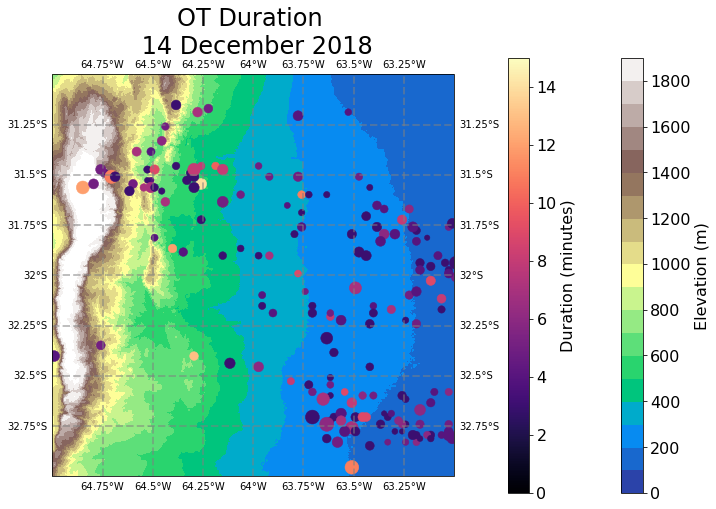

In [89]:
llcrnr=[-33.206342, -65.906586]
urcrnr=[-30.255825, -62.630553]

# Set extent of maps created in the following cells:
axis_extent=[-65, -63, -33, -31]      

# Plot map with all individual tracks:
import cartopy.crs as ccrs
fig_map,ax_map=plt.subplots(figsize=(12,8),subplot_kw={'projection': ccrs.PlateCarree()})
levs = np.arange(0, 2000, 100)

ax_map.coastlines()

ax_map.set_extent(axis_extent)

for ds in ds_list:
    cm = ax_map.contourf(ds.x.values[::5], ds.y.values[::5], ds.values[::5, ::5], levs, cmap='terrain', transform=ccrs.PlateCarree())


gl = ax_map.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')

cm2 = plt.scatter(dec_14.lon.values,dec_14.lat.values,c=dec_14.duration.values,vmin=0.,vmax=15.,s=dec_14.area_polygon,
                     facecolors='none',cmap='magma',linewidth=0.5)

cbar = plt.colorbar(cm, extend='both', label='Elevation (m)')
cbar.set_label(label='Elevation (m)', fontsize=16)
cbar.ax.tick_params(labelsize=16)

cbar2 = plt.colorbar(cm2,label='OT Area (km$^2$)', pad=0.1)
cbar2.set_label(label='Duration (minutes)', fontsize=16)
cbar2.ax.tick_params(labelsize=16)



ax_map.set_title('OT Duration \n 14 December 2018', fontsize=24)

/data/keeling/a/mgrover4/a/miniconda3/envs/xesmf_env/lib/python3.7/site-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.


Text(0.5, 1.0, 'Peak OT Depth \n 14 December 2018')

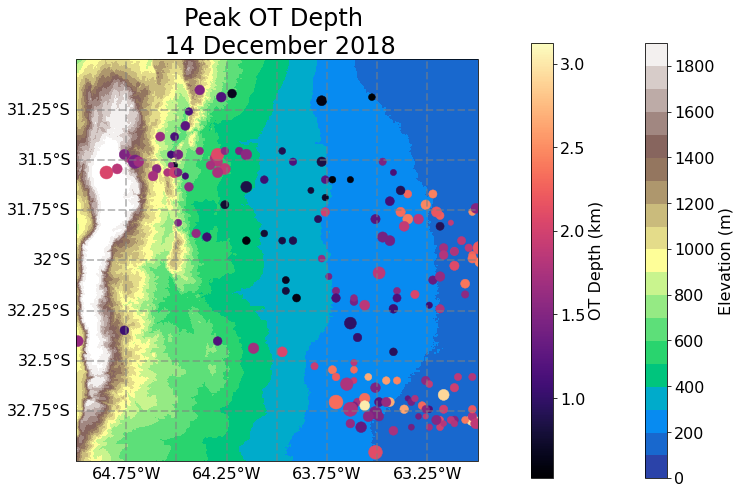

In [90]:
llcrnr=[-33.206342, -65.906586]
urcrnr=[-30.255825, -62.630553]

# Plot map with all individual tracks:
import cartopy.crs as ccrs
fig_map,ax_map=plt.subplots(figsize=(12,8),subplot_kw={'projection': ccrs.PlateCarree()})
levs = np.arange(0, 2000, 100)

ax_map.coastlines()

ax_map.set_extent(axis_extent)

for ds in ds_list:
    cm = ax_map.contourf(ds.x.values[::5], ds.y.values[::5], ds.values[::5, ::5], levs, cmap='terrain', transform=ccrs.PlateCarree())


gl = ax_map.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.left_labels= True
gl.right_labels = False
gl.xlabel_style = {'size': 16, 'color': 'k'}
gl.ylabel_style = {'size': 16, 'color': 'k'}

cm2 = plt.scatter(dec_14.lon.values,dec_14.lat.values,c=dec_14.ot_depth.values,s=dec_14.area_polygon,
                     facecolors='none',cmap='magma',linewidth=0.5)

cbar = plt.colorbar(cm, extend='both', label='Elevation (m)')
cbar.set_label(label='Elevation (m)', fontsize=16)
cbar.ax.tick_params(labelsize=16)

cbar2 = plt.colorbar(cm2,label='OT Area (km$^2$)', pad=0.1)
cbar2.set_label(label='OT Depth (km)', fontsize=16)
cbar2.ax.tick_params(labelsize=16)



ax_map.set_title('Peak OT Depth \n 14 December 2018', fontsize=24)

/data/keeling/a/mgrover4/a/miniconda3/envs/xesmf_env/lib/python3.7/site-packages/ipykernel_launcher.py:32: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
/data/keeling/a/mgrover4/a/miniconda3/envs/xesmf_env/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator


Text(0.5, 1.0, 'OT Events \n 13-14 December 2018')

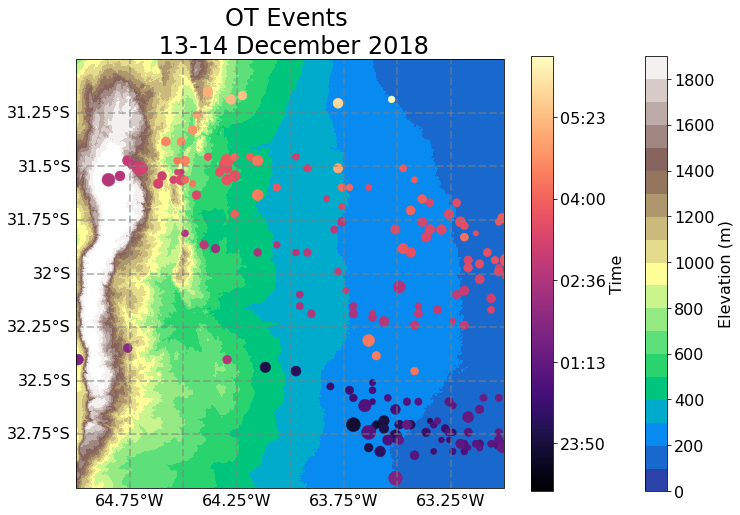

In [105]:
llcrnr=[-33.206342, -65.906586]
urcrnr=[-30.255825, -62.630553]

# Plot map with all individual tracks:
import cartopy.crs as ccrs
fig_map,ax_map=plt.subplots(figsize=(12,8),subplot_kw={'projection': ccrs.PlateCarree()})
levs = np.arange(0, 2000, 100)

ax_map.coastlines()

ax_map.set_extent(axis_extent)

for ds in ds_list:
    cm = ax_map.contourf(ds.x.values[::5], ds.y.values[::5], ds.values[::5, ::5], levs, cmap='terrain', transform=ccrs.PlateCarree())


gl = ax_map.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.left_labels= True
gl.right_labels = False
gl.xlabel_style = {'size': 16, 'color': 'k'}
gl.ylabel_style = {'size': 16, 'color': 'k'} 

cm2 = plt.scatter(dec_14.lon.values,dec_14.lat.values,c=dec_14.time.values,s=dec_14.area_polygon,
                     facecolors='none',cmap='magma',linewidth=0.5)


# Change the numeric ticks into ones that match the x-axis


cbar = plt.colorbar(cm, extend='both', label='Elevation (m)')
cbar.set_label(label='Elevation (m)', fontsize=16)
cbar.ax.tick_params(labelsize=16)

cbar2 = plt.colorbar(cm2,label='OT Area (km$^2$)')
cbar2.set_label(label='Time', fontsize=16)
cbar2.ax.tick_params(labelsize=16)
cbar2.ax.set_yticklabels(pd.to_datetime(cbar2.get_ticks()).strftime(date_format='%H:%M'))



ax_map.set_title('OT Events \n 13-14 December 2018', fontsize=24)

/data/keeling/a/mgrover4/a/miniconda3/envs/xesmf_env/lib/python3.7/site-packages/ipykernel_launcher.py:31: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.


Text(0.5, 1.0, 'Peak OTA from OT Tracks \n 10 November 2018')

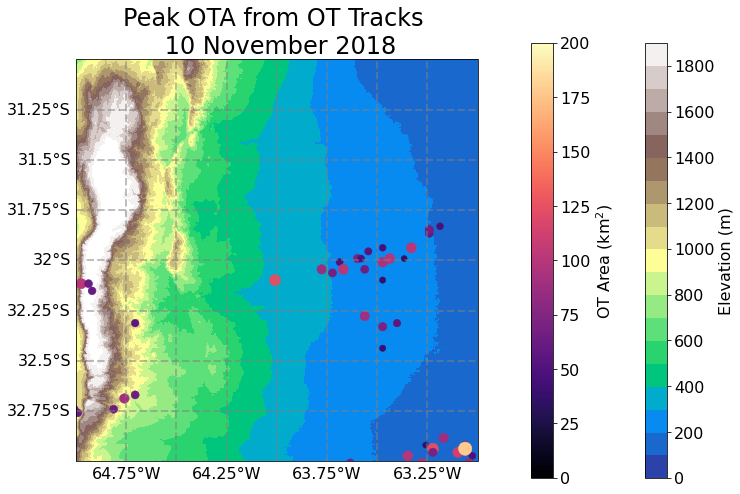

In [82]:
llcrnr=[-33.206342, -65.906586]
urcrnr=[-30.255825, -62.630553]

# Set extent of maps created in the following cells:
axis_extent=[-65, -63, -33, -31]    

# Plot map with all individual tracks:
import cartopy.crs as ccrs
fig_map,ax_map=plt.subplots(figsize=(12,8),subplot_kw={'projection': ccrs.PlateCarree()})
levs = np.arange(0, 2000, 100)

ax_map.coastlines()

ax_map.set_extent(axis_extent)

for ds in ds_list:
    cm = ax_map.contourf(ds.x.values[::5], ds.y.values[::5], ds.values[::5, ::5], levs, cmap='terrain', transform=ccrs.PlateCarree())


gl = ax_map.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.left_labels= True
gl.right_labels = False
gl.xlabel_style = {'size': 16, 'color': 'k'}
gl.ylabel_style = {'size': 16, 'color': 'k'}

cm2 = plt.scatter(nov_10.lon.values,nov_10.lat.values,c=nov_10.area_polygon.values,vmin=0.,vmax=200.,s=nov_10.area_polygon,
                     facecolors='none',cmap='magma',linewidth=0.5)

cbar = plt.colorbar(cm, extend='both', label='Elevation (m)')
cbar.set_label(label='Elevation (m)', fontsize=16)
cbar.ax.tick_params(labelsize=16)

cbar2 = plt.colorbar(cm2,label='OT Area (km$^2$)', pad=0.1)
cbar2.set_label(label='OT Area (km$^2$)', fontsize=16)
cbar2.ax.tick_params(labelsize=16)



ax_map.set_title('Peak OTA from OT Tracks \n 10 November 2018', fontsize=24)

/data/keeling/a/mgrover4/a/miniconda3/envs/xesmf_env/lib/python3.7/site-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.


Text(0.5, 1.0, 'OT Duration \n 10 November 2018')

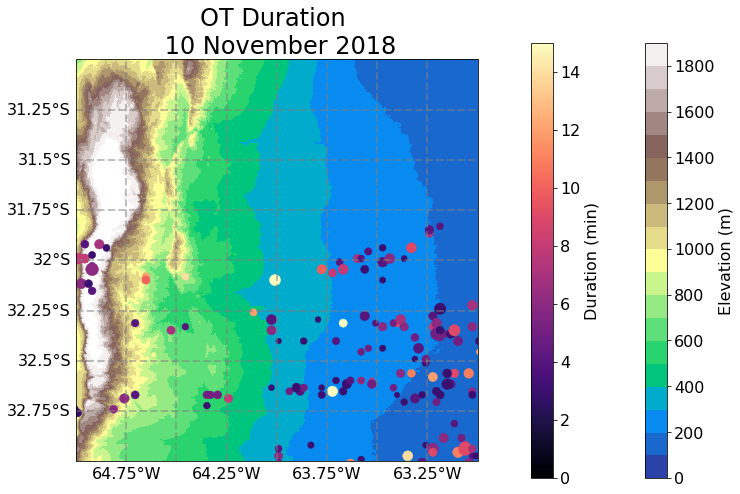

In [119]:
llcrnr=[-33.206342, -65.906586]
urcrnr=[-30.255825, -62.630553] 

# Plot map with all individual tracks:
import cartopy.crs as ccrs
fig_map,ax_map=plt.subplots(figsize=(12,8),subplot_kw={'projection': ccrs.PlateCarree()})
levs = np.arange(0, 2000, 100)

ax_map.coastlines()

ax_map.set_extent(axis_extent)

for ds in ds_list:
    cm = ax_map.contourf(ds.x.values[::5], ds.y.values[::5], ds.values[::5, ::5], levs, cmap='terrain', transform=ccrs.PlateCarree())


gl = ax_map.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.left_labels= True
gl.right_labels = False
gl.xlabel_style = {'size': 16, 'color': 'k'}
gl.ylabel_style = {'size': 16, 'color': 'k'}

cm2 = plt.scatter(nov_10.lon.values,nov_10.lat.values,c=nov_10.duration.values,vmin=0.,vmax=15.,s=nov_10.area_polygon,
                     facecolors='none',cmap='magma',linewidth=0.5)

cbar = plt.colorbar(cm, extend='both', label='Elevation (m)')
cbar.set_label(label='Elevation (m)', fontsize=16)
cbar.ax.tick_params(labelsize=16)

cbar2 = plt.colorbar(cm2,label='OT Area (km$^2$)', pad=0.1)
cbar2.set_label(label='Duration (min)', fontsize=16)
cbar2.ax.tick_params(labelsize=16)



ax_map.set_title('OT Duration \n 10 November 2018', fontsize=24)

/data/keeling/a/mgrover4/a/miniconda3/envs/xesmf_env/lib/python3.7/site-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
/data/keeling/a/mgrover4/a/miniconda3/envs/xesmf_env/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator


Text(0.5, 1.0, 'OT Events \n 10 November 2018')

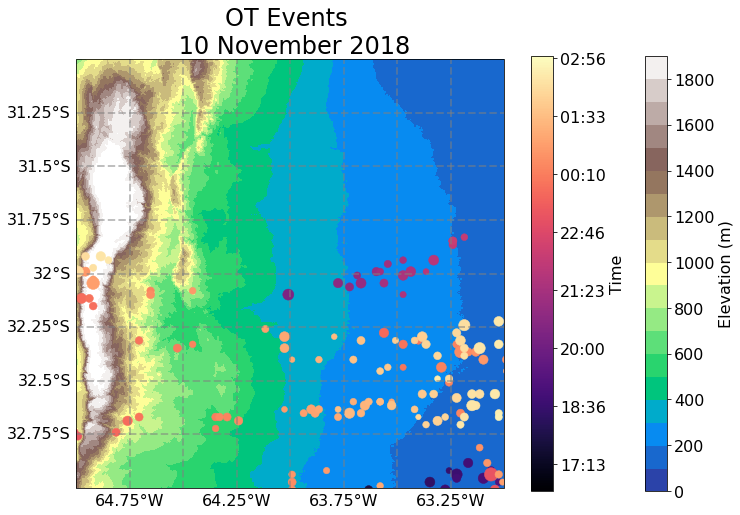

In [118]:
llcrnr=[-33.206342, -65.906586]
urcrnr=[-30.255825, -62.630553] 

# Plot map with all individual tracks:
import cartopy.crs as ccrs
fig_map,ax_map=plt.subplots(figsize=(12,8),subplot_kw={'projection': ccrs.PlateCarree()})
levs = np.arange(0, 2000, 100)

ax_map.coastlines()

ax_map.set_extent(axis_extent)

for ds in ds_list:
    cm = ax_map.contourf(ds.x.values[::5], ds.y.values[::5], ds.values[::5, ::5], levs, cmap='terrain', transform=ccrs.PlateCarree())


gl = ax_map.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.left_labels= True
gl.right_labels = False
gl.xlabel_style = {'size': 16, 'color': 'k'}
gl.ylabel_style = {'size': 16, 'color': 'k'}

cm2 = plt.scatter(nov_10.lon.values,nov_10.lat.values,c=nov_10.time.values,s=nov_10.area_polygon,
                     facecolors='none',cmap='magma',linewidth=0.5)

cbar = plt.colorbar(cm, extend='both', label='Elevation (m)')
cbar.set_label(label='Elevation (m)', fontsize=16)
cbar.ax.tick_params(labelsize=16)

cbar2 = plt.colorbar(cm2,label='OT Area (km$^2$)')
cbar2.set_label(label='Time', fontsize=16)
cbar2.ax.tick_params(labelsize=16)
cbar2.ax.set_yticklabels(pd.to_datetime(cbar2.get_ticks()).strftime(date_format='%H:%M'))



ax_map.set_title('OT Events \n 10 November 2018', fontsize=24)

/data/keeling/a/mgrover4/a/miniconda3/envs/xesmf_env/lib/python3.7/site-packages/ipykernel_launcher.py:29: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.


Text(0.5, 1.0, 'Peak OT Depth \n 10 November 2018')

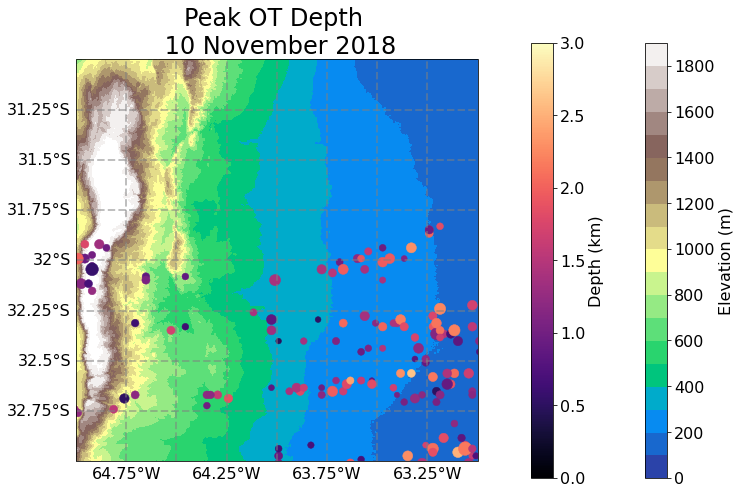

In [120]:
llcrnr=[-33.206342, -65.906586]
urcrnr=[-30.255825, -62.630553]
 

# Plot map with all individual tracks:
import cartopy.crs as ccrs
fig_map,ax_map=plt.subplots(figsize=(12,8),subplot_kw={'projection': ccrs.PlateCarree()})
levs = np.arange(0, 2000, 100)

ax_map.coastlines()

ax_map.set_extent(axis_extent)

for ds in ds_list:
    cm = ax_map.contourf(ds.x.values[::5], ds.y.values[::5], ds.values[::5, ::5], levs, cmap='terrain', transform=ccrs.PlateCarree())


gl = ax_map.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.left_labels= True
gl.right_labels = False
gl.xlabel_style = {'size': 16, 'color': 'k'}
gl.ylabel_style = {'size': 16, 'color': 'k'}

cm2 = plt.scatter(nov_10.lon.values,nov_10.lat.values,c=nov_10.ot_depth.values,vmin=0.,vmax=3.,s=nov_10.area_polygon,
                     facecolors='none',cmap='magma',linewidth=0.5)

cbar = plt.colorbar(cm, extend='both', label='Elevation (m)')
cbar.set_label(label='Elevation (m)', fontsize=16)
cbar.ax.tick_params(labelsize=16)

cbar2 = plt.colorbar(cm2,label='OT Area (km$^2$)', pad=0.1)
cbar2.set_label(label='Depth (km)', fontsize=16)
cbar2.ax.tick_params(labelsize=16)



ax_map.set_title('Peak OT Depth \n 10 November 2018', fontsize=24)

In [17]:
dec_14

area_polygon  cloudtop_height  e_radial  \
4353     27.820872        17.008001  2.512100   
4354     45.744502        17.170000  5.021842   
4356     35.420817        17.276001  3.344912   
4357     33.917275        16.268002  3.335197   
4358     57.817719        17.937000  4.996009   
...            ...              ...       ...   
7837     45.825843        16.686001  5.000000   
7840     24.486986        17.549002  3.000000   
7843     30.263209        17.159000  3.000000   
7856     59.017049        16.591002  4.000000   
7858     61.092856        16.749001  4.000000   

                                          e_radial_del2  \
4353  [ 0.15357971  0.16321182  0.05794525 -0.138183...   
4354  [ 0.26845551  0.35186768  0.3476181   0.193073...   
4356  [ 0.41732788  0.53477859  0.48075867  0.159931...   
4357  [ 0.2013855   0.27927017  0.29254532  0.144180...   
4358  [ 2.07168579e-01  2.75302887e-01  2.85362244e-...   
...                                                 ...   
7837  [ 0.16270447  0.23226547  0.25936508  0.153068...   
7840  [94.7826767  94.7826767  47.39133835  0.      ...   
7843  [95.89810181 95.89810181 47.9490509   0.      ...   
7856  [ 0.10934448  0.14450455  0.13109207  0.027835...   
7858  [ 0.13513947  0.17360687  0.14691925  0.013507...   

                                                   e_tb  \
4353  [197.50794983 198.54685974 199.89292908 201.27...   
4354  [196.36286926 195.73219299 195.63842773 195.87...   
4356  [196.95626831 197.06828308 198.01495361 199.43...   
4357  [203.81013489 203.84004211 204.27272034 205.01...   
4358  [191.43812561 191.50009155 191.97639465 192.72...   
...                                                 ...   
7837  [195.18452454 195.12481689 195.39051819 195.93...   
7840  [189.56535339   0.           0.           0.  ...   
7843  [191.79620361   0.           0.           0.  ...   
7856  [195.60501099 195.75       196.11367798 196.61...   
7858  [194.45181274 194.74206543 195.30259705 196.01...   

                                               geometry        lat   lat_corr  \
4353  POLYGON ((-63.41965 -32.72321, -63.40088 -32.7... -32.687500 -32.564499   
4354  POLYGON ((-63.63393 -32.76786, -63.60579 -32.7... -32.723213 -32.599213   
4356  POLYGON ((-63.63393 -32.85714, -63.60109 -32.8... -32.812500 -32.687500   
4357  POLYGON ((-65.06250 -33.10714, -65.04374 -33.0... -33.080357 -32.962357   
4358  POLYGON ((-62.77679 -33.19926, -62.76740 -33.1... -33.187500 -33.055500   
...                                                 ...        ...        ...   
7837  POLYGON ((-67.61607 -27.00000, -67.58793 -26.9... -31.205359 -26.955357   
7840  POLYGON ((-66.72322 -26.75000, -66.70914 -26.7... -30.973215 -26.723215   
7843  POLYGON ((-66.72322 -26.74107, -66.70914 -26.7... -30.955357 -26.705357   
7856  POLYGON ((-67.66964 -26.87500, -67.64619 -26.8... -31.080357 -26.830359   
7858  POLYGON ((-67.63393 -26.88393, -67.61048 -26.8... -31.080357 -26.830359   

            lon   lon_corr  ...        btd                       diff  \
4353 -63.419647 -63.465649  ...  -7.050003 43 days 00:00:25.000000512   
4354 -63.633930 -63.679932  ...  -8.329987 43 days 00:00:25.000000512   
4356 -63.633930 -63.679932  ...  -9.210007 43 days 00:00:25.000000512   
4357 -65.062500 -65.100502  ...  -5.000000 43 days 00:00:25.000000512   
4358 -62.776787 -62.828785  ... -12.600006 43 days 00:00:25.000000512   
...         ...        ...  ...        ...                        ...   
7837 -63.526783 -67.616074  ...  -2.039993 43 days 06:25:25.000000512   
7840 -62.633926 -66.723221  ...  -7.099991 43 days 06:27:25.000000512   
7843 -62.633926 -66.723221  ...  -4.589996 43 days 06:28:25.000000512   
7856 -63.580360 -67.669640  ...  -1.300003 43 days 06:32:25.000000512   
7858 -63.544643 -67.633926  ...  -2.339996 43 days 06:34:24.999999488   

        frame states  label              x              y  cell day month  
4353  2879071      0      0 -132858.256112  -77325.241389   958  14    12

## Linear Regression

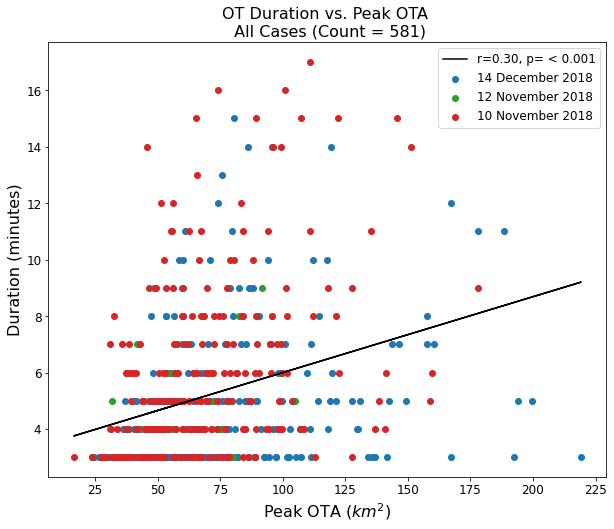

In [9]:
slope, intercept, r, p, stderr = scipy.stats.linregress(df_max.area_polygon, df_max.duration)

line = f'r={r:.2f}, p= < 0.001'

plt.figure(figsize=(10,8))
ax = plt.subplot(111)

#max_depth_nov_10 = max_depth[max_depth.day == 10]
ax.scatter(dec_14.area_polygon, dec_14.duration, color='tab:blue', label='14 December 2018')
ax.scatter(nov_12.area_polygon, nov_12.duration, color='tab:green', label='12 November 2018')
ax.scatter(nov_10.area_polygon, nov_10.duration, color='tab:red', label='10 November 2018')

#ax.scatter(np.median(dec_14.duration), np.median(dec_14.area_polygon), color='blue', s=100)
#ax.scatter(np.median(nov_10.duration), np.median(nov_10.area_polygon), color='red', s=100)
#ax.scatter(np.median(nov_12.duration), np.median(nov_12.area_polygon), color='green', s=100)

#ax.scatter(np.mean(dec_14.duration), np.mean(dec_14.area_polygon), color='blue', s=100)
#ax.scatter(np.mean(nov_10.duration), np.mean(nov_10.area_polygon), color='red', s=100)
#ax.scatter(np.mean(nov_12.duration), np.mean(nov_12.area_polygon), color='green', s=100)



ax.plot(np.array(df_max.area_polygon), intercept + slope * np.array(df_max.area_polygon), label=line, color='black')

plt.ylabel('Duration (minutes)', fontsize=16)
plt.xlabel('Peak OTA ($km^{2}$)', fontsize=16)

plt.legend(loc='upper right', fontsize=12)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.title(f'OT Duration vs. Peak OTA \n All Cases (Count = {len(df_max)})', fontsize=16)

plt.savefig('OT_duration_Peak_OTA.png', dpi=300)

In [94]:
from sklearn.metrics import r2_score
x = df_max.area_polygon
y = df_max.duration

mymodel = numpy.poly1d(np.polyfit(x, y, 3))
linmodel = numpy.poly1d(np.polyfit(x, y, 1))

r_poly = np.sqrt(r2_score(y, mymodel(x)))
r_lin = np.sqrt(r2_score(y, linmodel(x)))

Text(0, 0.5, 'Peak OT Duration ($minutes$)')

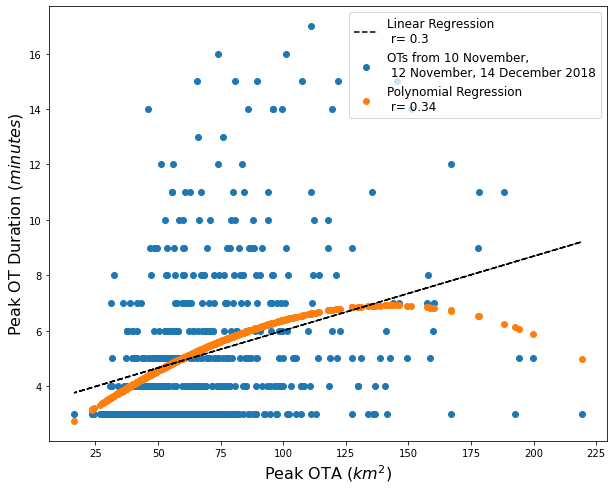

In [96]:
fig = plt.figure(figsize=(10, 8))
plt.scatter(x, y, label='OTs from 10 November, \n 12 November, 14 December 2018')
plt.scatter(x, mymodel(x), label=f'Polynomial Regression \n r= {round(r_poly, 2)}')
plt.plot(x, linmodel(x), linestyle='--', color='k', label=f'Linear Regression \n r= {round(r_lin, 2)}')
plt.legend(loc='upper right', fontsize=12)

plt.xlabel('Peak OTA ($km^2$)', fontsize=16)
plt.ylabel('Peak OT Duration ($minutes$)', fontsize=16)

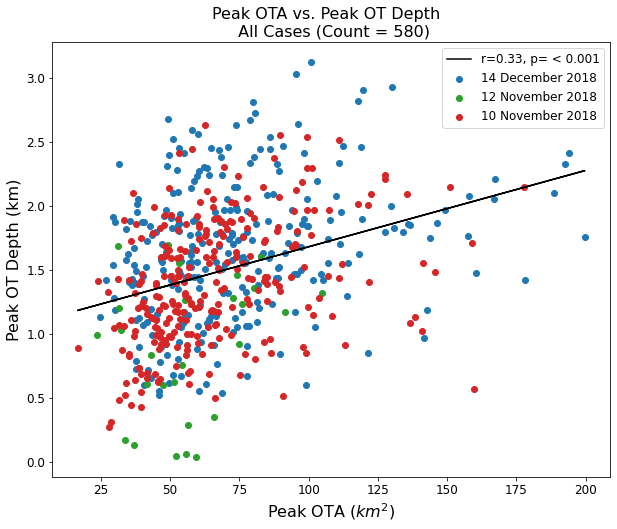

In [21]:
slope, intercept, r, p, stderr = scipy.stats.linregress(df_max.area_polygon, df_max.ot_depth)

line = f'r={r:.2f}, p= < 0.001'

plt.figure(figsize=(10,8))
ax = plt.subplot(111)

#max_depth_nov_10 = max_depth[max_depth.day == 10]
ax.scatter(dec_14.area_polygon, dec_14.ot_depth, color='tab:blue', label='14 December 2018')
ax.scatter(nov_12.area_polygon, nov_12.ot_depth, color='tab:green', label='12 November 2018')
ax.scatter(nov_10.area_polygon, nov_10.ot_depth, color='tab:red', label='10 November 2018')

#ax.scatter(np.median(dec_14.area_polygon), np.median(dec_14.ot_depth), color='blue', s=100)
#ax.scatter(np.median(nov_10.area_polygon), np.median(nov_10.ot_depth), color='red', s=100)
#ax.scatter(np.median(nov_12.area_polygon), np.median(nov_12.ot_depth), color='green', s=100)

ax.plot(np.array(df_max.area_polygon), intercept + slope * np.array(df_max.area_polygon), label=line, color='black')

plt.xlabel('Peak OTA ($km^{2}$)', fontsize=16)
plt.ylabel('Peak OT Depth (km)', fontsize=16)

plt.legend(loc='upper right', fontsize=12)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.title(f'Peak OTA vs. Peak OT Depth  \n All Cases (Count = {len(df_max)})', fontsize=16)
plt.savefig('OTA_OT_Depth.png', dpi=300)

In [22]:
slope, intercept, r, p, stderr = scipy.stats.linregress(df_max.area_polygon, df_max.ot_depth)

In [23]:
nov_10_min = df_min[df_min.day == 10]
nov_12_min = df_min[df_min.day == 12]
dec_14_min = df_min[df_min.day == 14]

ValueError: x and y must be the same size

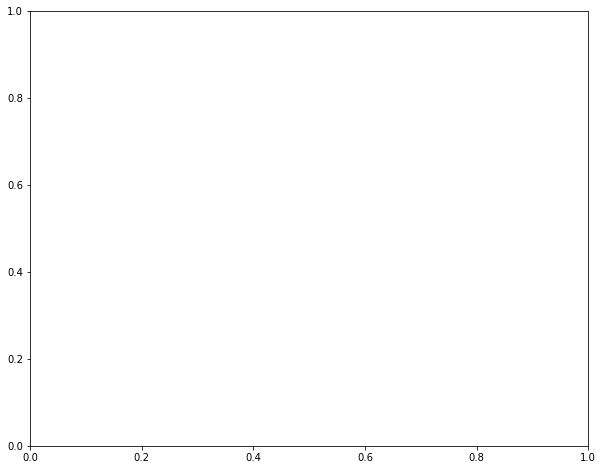

In [24]:
slope, intercept, r, p, stderr = scipy.stats.linregress(df_min.btd, df_max.ot_depth)

line = f'r={r:.2f}'

plt.figure(figsize=(10,8))
ax = plt.subplot(111)
#max_depth_nov_10 = max_depth[max_depth.day == 10]
ax.scatter(dec_14_min.btd, dec_14.ot_depth, color='tab:blue', label='14 December 2018')
ax.scatter(nov_12_min.btd, nov_12.ot_depth, color='tab:green', label='12 November 2018')
ax.scatter(nov_10_min.btd, nov_10.ot_depth, color='tab:red', label='10 November 2018')

ax.scatter(np.median(dec_14_min.btd), np.median(dec_14.ot_depth), color='blue', s=100)
ax.scatter(np.median(nov_10_min.btd), np.median(nov_10.ot_depth), color='red', s=100)
ax.scatter(np.median(nov_12_min.btd), np.median(nov_12.ot_depth), color='green', s=100)

ax.plot(np.array(df_min.btd), intercept + slope * np.array(df_min.btd), label=line, color='black')

plt.xlabel('BTD (IR Temp - Trop Temp) (K)', fontsize=12)
plt.ylabel('OT Depth (km)', fontsize=12)

plt.legend(loc='upper right', fontsize=12)

plt.title('OT BTD vs. OT Depth  \n 10 November, 12 November, 14 December 2018 UTC (Count = 579)', fontsize=16)

In [25]:
def calc_r(area, scale=0.412):
    
    return np.sqrt(area*scale/np.pi) 

In [26]:
df['mid_ur_50'] = calc_r(df['area_polygon'], 0.72)
df['mid_ur_60'] = calc_r(df['area_polygon'], 0.58)
df['mid_ur_70'] = calc_r(df['area_polygon'], 0.41)
df['mid_ur_80'] = calc_r(df['area_polygon'], 0.32)
df['mid_ur_90'] = calc_r(df['area_polygon'], 0.11)
df['mid_ur_95'] = calc_r(df['area_polygon'], 0.04)
df['mid_ud'] = calc_r(df['area_polygon']) * 2

/data/keeling/a/mgrover4/a/miniconda3/envs/xesmf_env/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/data/keeling/a/mgrover4/a/miniconda3/envs/xesmf_env/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/data/keeling/a/mgrover4/a/miniconda3/envs/xesmf_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set 

(array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

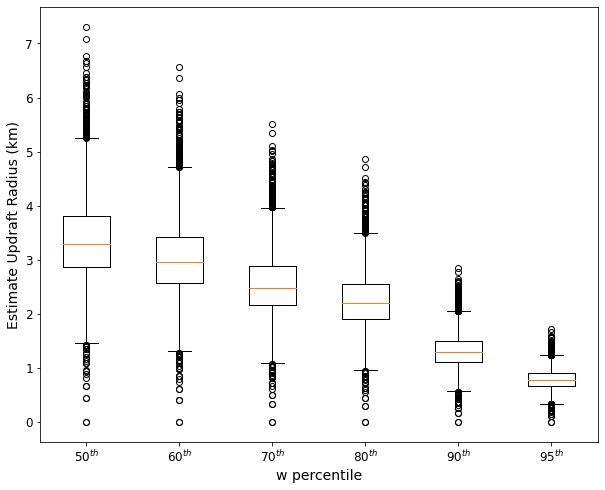

In [27]:
figure = plt.figure(figsize=(10,8))
plt.boxplot([df.mid_ur_50, df.mid_ur_60, df.mid_ur_70, df.mid_ur_80, df.mid_ur_90, df.mid_ur_95])
plt.xticks([1, 2, 3, 4, 5, 6], ['$50^{th}$', '$60^{th}$', '$70^{th}$', '$80^{th}$', '$90^{th}$', '$95^{th}$'], fontsize=12)

plt.ylabel('Estimate Updraft Radius (km)', fontsize=14)
plt.xlabel('w percentile', fontsize=14)

plt.yticks(fontsize=12)

In [28]:
p

0.0

In [29]:
np.median(df.mid_ur_60)

2.9573037952551773

In [30]:
np.median(df.mid_ur_70)

2.486416460368345

In [31]:
np.median(df.mid_ur_80)

2.196630113408756

In [32]:
np.median(df.mid_ur_90) * 2

2.5757771256087896

In [33]:
np.median(df.mid_ur_95) * 2

1.5532520489499064

In [34]:
plt.hist()

TypeError: hist() missing 1 required positional argument: 'x'

In [35]:
df['est_wmax'] = df['ot_depth'] * 34.234

/data/keeling/a/mgrover4/a/miniconda3/envs/xesmf_env/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [36]:
nov_10 = df[df.day == 10]
nov_12 = df[df.day == 12]
dec_14 = df[df.day == 14]

df_mean = df.groupby('cell').mean()
df_max = df.groupby('cell').max()

df_max['duration']= cells_grouped.count().area_polygon
df_mean['duration'] = cells_grouped.count().area_polygon

df_max = df_max[df_max.duration > 2]
df_mean = df_mean[df_mean.duration > 2]

nov_10_mean = df_mean[df_mean.day == 10]
nov_12_mean = df_mean[df_mean.day == 12]
dec_14_mean = df_mean[df_mean.day == 14]

nov_10_max = df_max[df_max.day == 10]
nov_12_max = df_max[df_max.day == 12]
dec_14_max = df_max[df_max.day == 14]

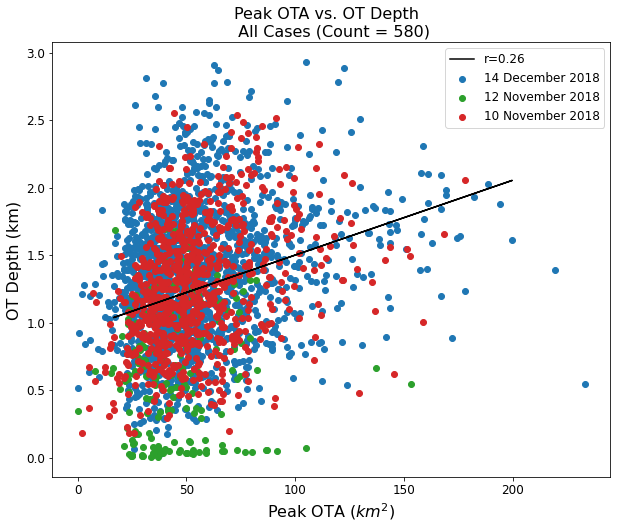

In [37]:
slope, intercept, r, p, stderr = scipy.stats.linregress(df.area_polygon, df.ot_depth)

line = f'r={r:.2f}'

plt.figure(figsize=(10,8))
ax = plt.subplot(111)

#max_depth_nov_10 = max_depth[max_depth.day == 10]
ax.scatter(dec_14.area_polygon, dec_14.ot_depth, color='tab:blue', label='14 December 2018')
ax.scatter(nov_12.area_polygon, nov_12.ot_depth, color='tab:green', label='12 November 2018')
ax.scatter(nov_10.area_polygon, nov_10.ot_depth, color='tab:red', label='10 November 2018')

#ax.scatter(np.median(dec_14.area_polygon), np.median(dec_14.ot_depth), color='blue', s=100)
#ax.scatter(np.median(nov_10.area_polygon), np.median(nov_10.ot_depth), color='red', s=100)
#ax.scatter(np.median(nov_12.area_polygon), np.median(nov_12.ot_depth), color='green', s=100)

ax.plot(np.array(df_max.area_polygon), intercept + slope * np.array(df_max.area_polygon), label=line, color='black')

plt.xlabel('Peak OTA ($km^{2}$)', fontsize=16)
plt.ylabel('OT Depth (km)', fontsize=16)

plt.legend(loc='upper right', fontsize=12)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.title(f'Peak OTA vs. OT Depth  \n All Cases (Count = {len(df_max)})', fontsize=16)
plt.savefig('OTA_OT_Depth.png', dpi=300)

In [38]:
nov_10_max.duration.mean()

5.948717948717949

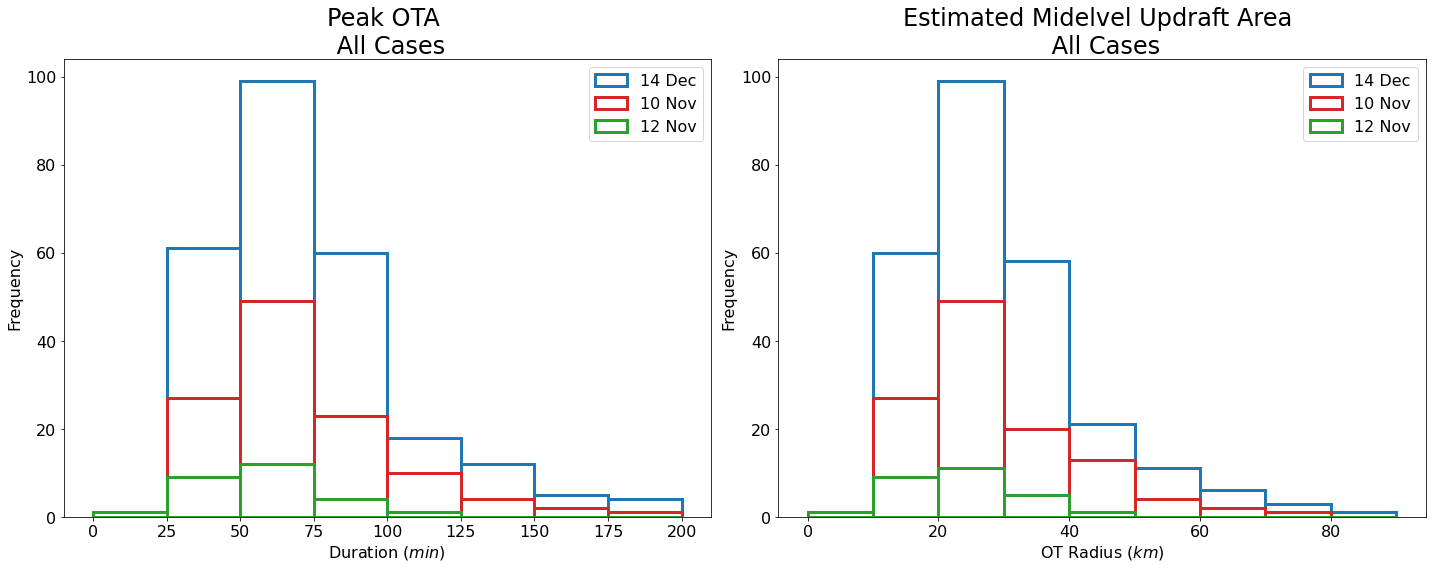

In [61]:
u_core_bins = np.arange(0, 6.25, .25)
ua_bins = np.arange(0, 100, 10)
otw_bins = np.arange(0, 10.5, .5)

fig = plt.figure(figsize=(20,8))


ax = plt.subplot(121)
ax.hist(dec_14_max.area_polygon, ota_bins, label='14 Dec', color='white',
        edgecolor='tab:blue', linewidth=3)
ax.hist(nov_10_max.area_polygon, ota_bins, label='10 Nov', color='white',
        edgecolor='tab:red', linewidth=3)
ax.hist(nov_12_max.area_polygon, ota_bins, label='12 Nov', color='white',
        edgecolor='tab:green', linewidth=3)


plt.title('Peak OTA \n All Cases', fontsize=24)

plt.xlabel('Duration ($min$)', fontsize=16)
plt.ylabel('Frequency', fontsize=16)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc='upper right', fontsize=16)

ax2 = plt.subplot(122)
#plt.hist(df_max.area_polygon * 0.4032)



ax2.hist((dec_14_max.area_polygon* 0.4032), ua_bins, label='14 Dec', color='white',
         edgecolor='tab:blue', linewidth=3)
ax2.hist((nov_10_max.area_polygon * 0.4032), ua_bins, label='10 Nov', color='white',
         edgecolor='tab:red', linewidth=3)
ax2.hist((nov_12_max.area_polygon * 0.4032), ua_bins, label='12 Nov', color='white',
         edgecolor='tab:green', linewidth=3)


plt.title('Estimated Midelvel Updraft Area \n All Cases', fontsize=24)

plt.xlabel('OT Radius ($km$)', fontsize=16)
plt.ylabel('Frequency', fontsize=16)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.legend(loc='upper right', fontsize=16)

plt.tight_layout()
plt.savefig('OTA_Radius.png', dpi=300)

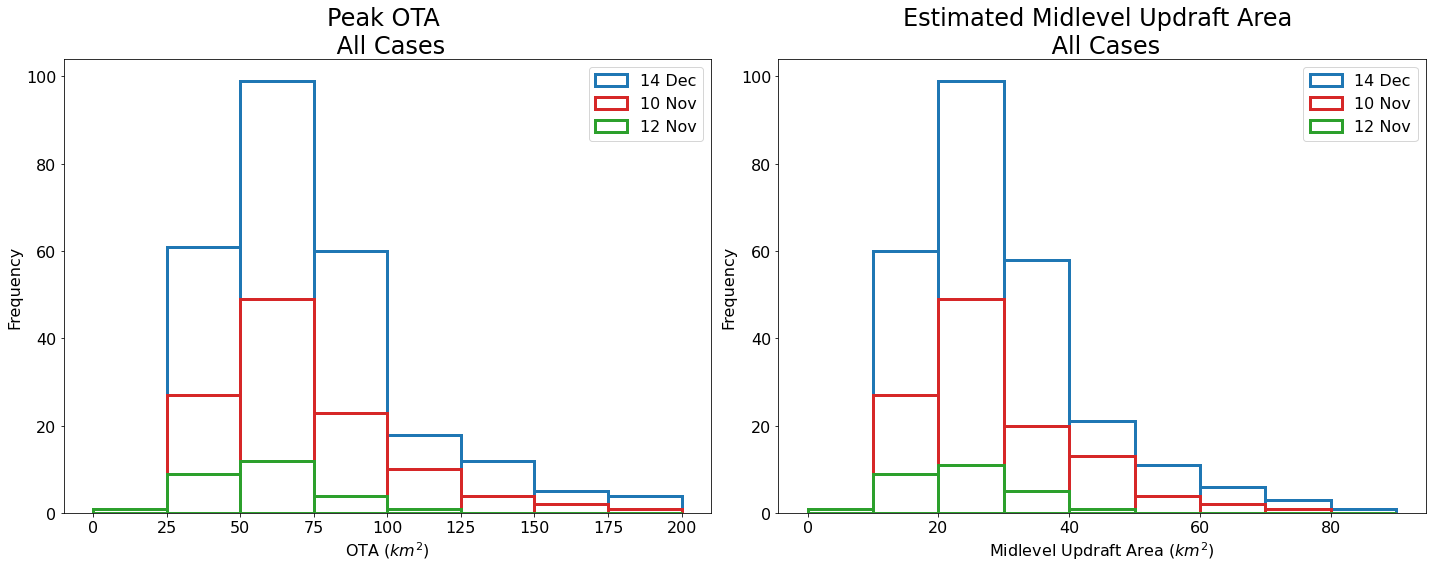

In [64]:
u_core_bins = np.arange(0, 6.25, .25)
ua_bins = np.arange(0, 100, 10)
otw_bins = np.arange(0, 10.5, .5)

fig = plt.figure(figsize=(20,8))


ax = plt.subplot(121)
ax.hist(dec_14_max.area_polygon, ota_bins, label='14 Dec', color='white',
        edgecolor='tab:blue', linewidth=3)
ax.hist(nov_10_max.area_polygon, ota_bins, label='10 Nov', color='white',
        edgecolor='tab:red', linewidth=3)
ax.hist(nov_12_max.area_polygon, ota_bins, label='12 Nov', color='white',
        edgecolor='tab:green', linewidth=3)


plt.title('Peak OTA \n All Cases', fontsize=24)

plt.xlabel('OTA ($km^2$)', fontsize=16)
plt.ylabel('Frequency', fontsize=16)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc='upper right', fontsize=16)

ax2 = plt.subplot(122)
#plt.hist(df_max.area_polygon * 0.4032)



ax2.hist((dec_14_max.area_polygon* 0.4032), ua_bins, label='14 Dec', color='white',
         edgecolor='tab:blue', linewidth=3)
ax2.hist((nov_10_max.area_polygon * 0.4032), ua_bins, label='10 Nov', color='white',
         edgecolor='tab:red', linewidth=3)
ax2.hist((nov_12_max.area_polygon * 0.4032), ua_bins, label='12 Nov', color='white',
         edgecolor='tab:green', linewidth=3)


plt.title('Estimated Midlevel Updraft Area \n All Cases', fontsize=24)

plt.xlabel('Midlevel Updraft Area ($km^2$)', fontsize=16)
plt.ylabel('Frequency', fontsize=16)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.legend(loc='upper right', fontsize=16)

plt.tight_layout()
plt.savefig('OTA_Radius.png', dpi=300)

In [69]:
ota_ua_scale = 0.4032

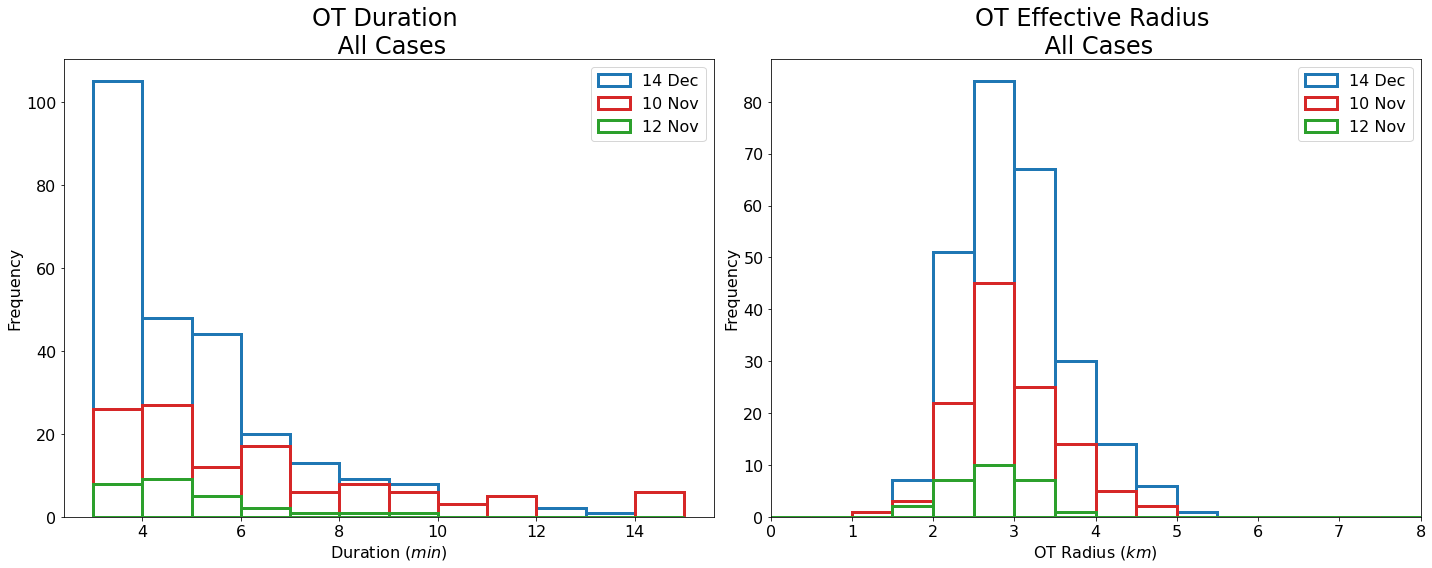

In [71]:
u_core_bins = np.arange(0, 6.25, .25)
ua_bins = np.arange(0, 100, 10)
otw_bins = np.arange(0, 10.5, .5)

fig = plt.figure(figsize=(20,8))


ax = plt.subplot(121)
ax.hist(dec_14_max.duration, dur_bins, label='14 Dec', color='white',
        edgecolor='tab:blue', linewidth=3)
ax.hist(nov_10_max.duration, dur_bins, label='10 Nov', color='white',
        edgecolor='tab:red', linewidth=3)
ax.hist(nov_12_max.duration, dur_bins, label='12 Nov', color='white',
        edgecolor='tab:green', linewidth=3)


plt.title('OT Duration \n All Cases', fontsize=24)

plt.xlabel('Duration ($min$)', fontsize=16)
plt.ylabel('Frequency', fontsize=16)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc='upper right', fontsize=16)

ax2 = plt.subplot(122)
#plt.hist(df_max.area_polygon * 0.4032)



ax2.hist(calc_r(dec_14_max.area_polygon,ota_ua_scale), otw_bins, label='14 Dec', color='white',
         edgecolor='tab:blue', linewidth=3)
ax2.hist(calc_r(nov_10_max.area_polygon,ota_ua_scale), otw_bins, label='10 Nov', color='white',
         edgecolor='tab:red', linewidth=3)
ax2.hist(calc_r(nov_12_max.area_polygon,ota_ua_scale), otw_bins, label='12 Nov', color='white',
         edgecolor='tab:green', linewidth=3)

plt.xlim(0, 8)


plt.title('OT Effective Radius \n All Cases', fontsize=24)

plt.xlabel('OT Radius ($km$)', fontsize=16)
plt.ylabel('Frequency', fontsize=16)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.legend(loc='upper right', fontsize=16)

plt.tight_layout()
plt.savefig('OT_Duration_Radius.png', dpi=300)

In [24]:
np.median(df.area_polygon * 0.4032)

19.10004031090206

In [25]:
np.median(df.area_polygon * 0.44)

20.84329795832566

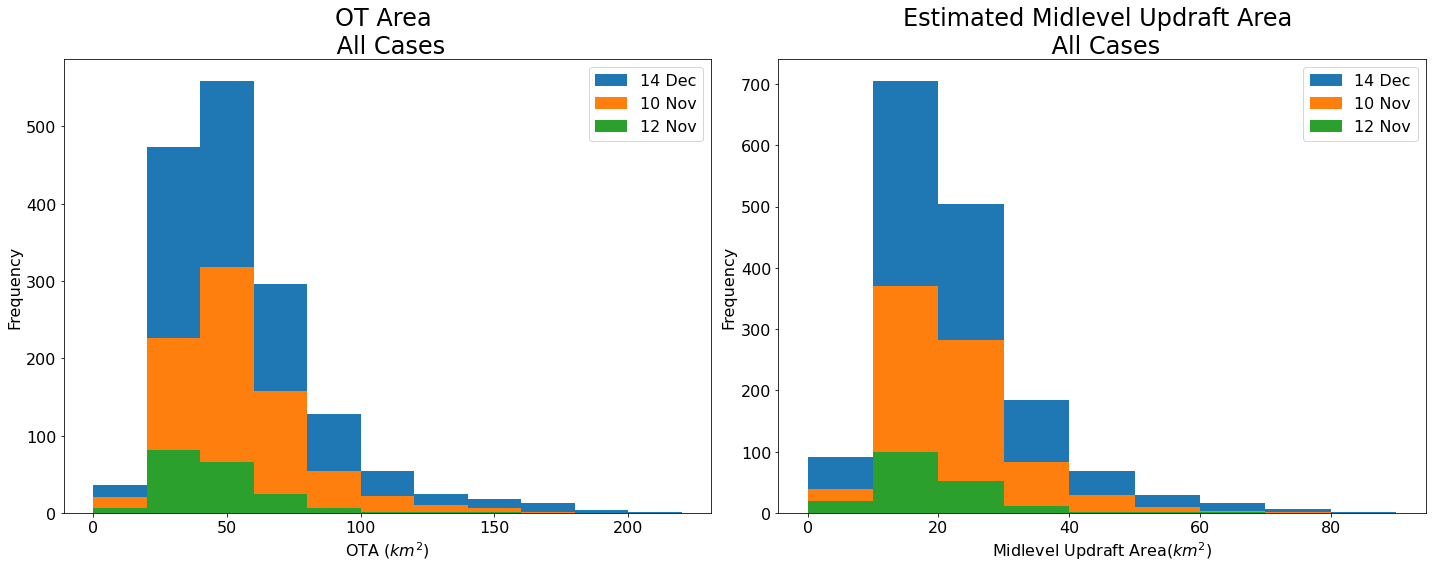

In [76]:
area_bins = np.arange(0, 240, 20)
ua_bins = np.arange(0, 100, 10)
fig = plt.figure(figsize=(20,8))

ax = plt.subplot(121)
ax.hist(dec_14.area_polygon, area_bins, label='14 Dec')
ax.hist(nov_10.area_polygon, area_bins, label='10 Nov')
ax.hist(nov_12.area_polygon, area_bins, label='12 Nov')


plt.title('OT Area \n All Cases', fontsize=24)

plt.xlabel('OTA ($km^2$)', fontsize=16)
plt.ylabel('Frequency', fontsize=16)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc='upper right', fontsize=16)

ax2 = plt.subplot(122)
#plt.hist(df_max.area_polygon * 0.4032)

ax2.hist(dec_14.area_polygon * 0.4032, ua_bins, label='14 Dec')
ax2.hist(nov_10.area_polygon * 0.4032, ua_bins, label='10 Nov')
ax2.hist(nov_12.area_polygon * 0.4032, ua_bins, label='12 Nov')


plt.title('Estimated Midlevel Updraft Area \n All Cases', fontsize=24)

plt.xlabel('Midlevel Updraft Area($km^2$)', fontsize=16)
plt.ylabel('Frequency', fontsize=16)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.legend(loc='upper right', fontsize=16)

plt.tight_layout()
plt.savefig('ota_updraft_area.png', dpi=300)

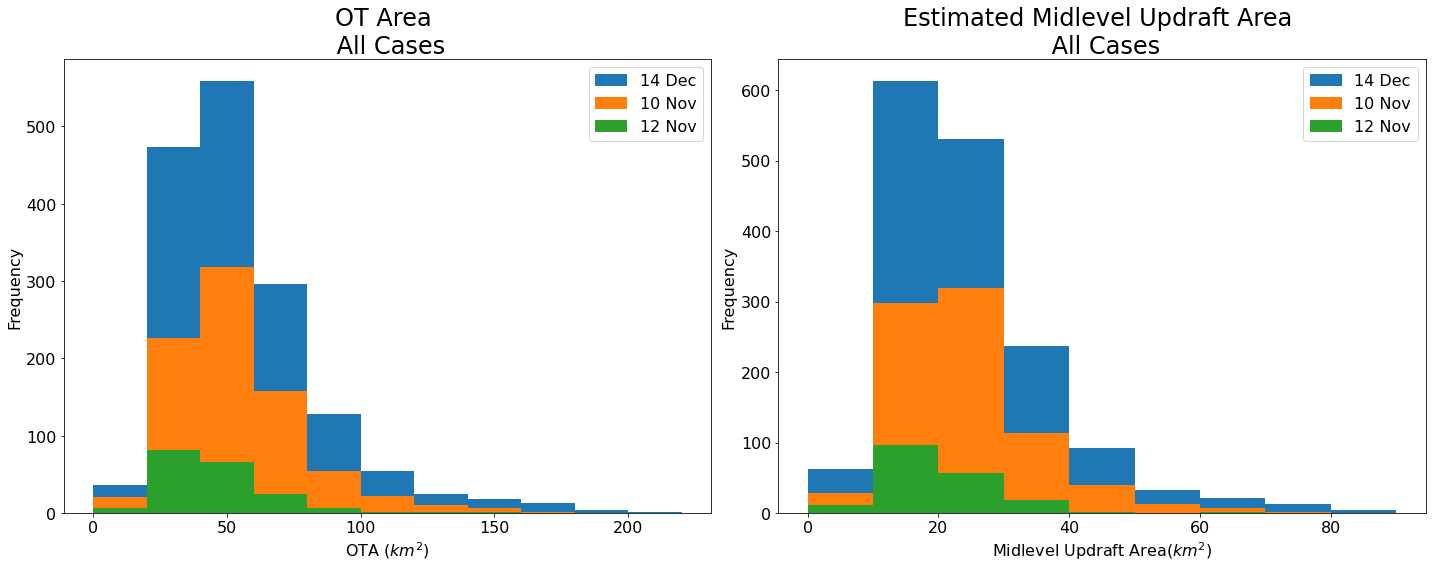

In [21]:
### NEW METHOD - using max ua and max ota from each case --> scaling from there (subsitute 0.44 for scaling factor now)
area_bins = np.arange(0, 240, 20)
ua_bins = np.arange(0, 100, 10)
fig = plt.figure(figsize=(20,8))

ax = plt.subplot(121)
ax.hist(dec_14.area_polygon, area_bins, label='14 Dec')
ax.hist(nov_10.area_polygon, area_bins, label='10 Nov')
ax.hist(nov_12.area_polygon, area_bins, label='12 Nov')


plt.title('OT Area \n All Cases', fontsize=24)

plt.xlabel('OTA ($km^2$)', fontsize=16)
plt.ylabel('Frequency', fontsize=16)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc='upper right', fontsize=16)

ax2 = plt.subplot(122)
#plt.hist(df_max.area_polygon * 0.4032)

ax2.hist(dec_14.area_polygon * 0.44, ua_bins, label='14 Dec')
ax2.hist(nov_10.area_polygon * 0.44, ua_bins, label='10 Nov')
ax2.hist(nov_12.area_polygon * 0.44, ua_bins, label='12 Nov')


plt.title('Estimated Midlevel Updraft Area \n All Cases', fontsize=24)

plt.xlabel('Midlevel Updraft Area($km^2$)', fontsize=16)
plt.ylabel('Frequency', fontsize=16)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.legend(loc='upper right', fontsize=16)

plt.tight_layout()
plt.savefig('ota_updraft_area.png', dpi=300)

In [12]:
np.median(calc_r(df.area_polygon, 0.44))

2.5760505730140073

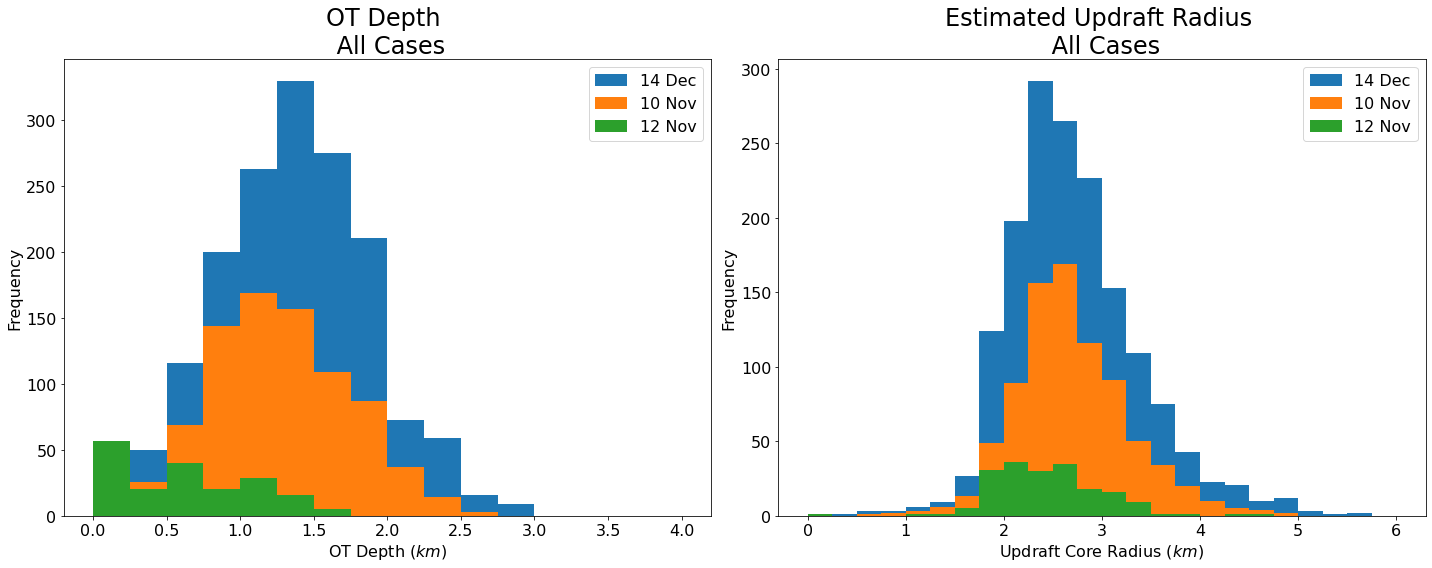

In [30]:
depth_bins = np.arange(0, 4.25, .25)
fig = plt.figure(figsize=(20,8))

ax = plt.subplot(121)
ax.hist(dec_14.ot_depth, depth_bins, label='14 Dec')
ax.hist(nov_10.ot_depth, depth_bins, label='10 Nov')
ax.hist(nov_12.ot_depth, depth_bins, label='12 Nov')


plt.title('OT Depth \n All Cases', fontsize=24)

plt.xlabel('OT Depth ($km$)', fontsize=16)
plt.ylabel('Frequency', fontsize=16)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc='upper right', fontsize=16)

ax = plt.subplot(122)
ax.hist(calc_r(dec_14.area_polygon, 0.44), u_core_bins, label='14 Dec')
ax.hist(calc_r(nov_10.area_polygon, 0.44), u_core_bins, label='10 Nov')
ax.hist(calc_r(nov_12.area_polygon, 0.44), u_core_bins, label='12 Nov')


plt.title('Estimated Updraft Radius \n All Cases', fontsize=24)

plt.xlabel('Updraft Core Radius ($km$)', fontsize=16)
plt.ylabel('Frequency', fontsize=16)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc='upper right', fontsize=16)
plt.tight_layout()
plt.savefig('ot_depth_radius', dpi=300)

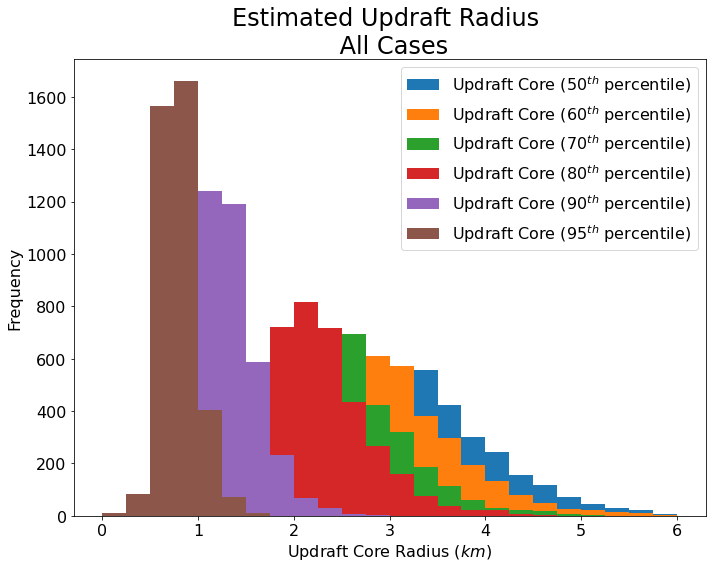

In [15]:

plt.figure(figsize=(10,8))
ax = plt.subplot(111)
ax.hist(df.mid_ur_50, u_core_bins, label='Updraft Core ($50^{th}$ percentile)')
ax.hist(df.mid_ur_60, u_core_bins, label='Updraft Core ($60^{th}$ percentile)')
ax.hist(df.mid_ur_70, u_core_bins, label='Updraft Core ($70^{th}$ percentile)')
ax.hist(df.mid_ur_80, u_core_bins, label='Updraft Core ($80^{th}$ percentile)')
ax.hist(df.mid_ur_90, u_core_bins, label='Updraft Core ($90^{th}$ percentile)')
ax.hist(df.mid_ur_95, u_core_bins, label='Updraft Core ($95^{th}$ percentile)')

plt.title('Estimated Updraft Radius \n All Cases', fontsize=24)

plt.xlabel('Updraft Core Radius ($km$)', fontsize=16)
plt.ylabel('Frequency', fontsize=16)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc='upper right', fontsize=16)
plt.tight_layout()

plt.savefig('threshold_test_radii.png', dpi=300)

In [31]:
np.median(df.est_wmax)

41.76545649337769

In [32]:
np.nanpercentile(dec_14.est_wmax, 50)

47.2942793579101

In [115]:
np.median(df.est_wmax * 0.386)

16.121478808605172

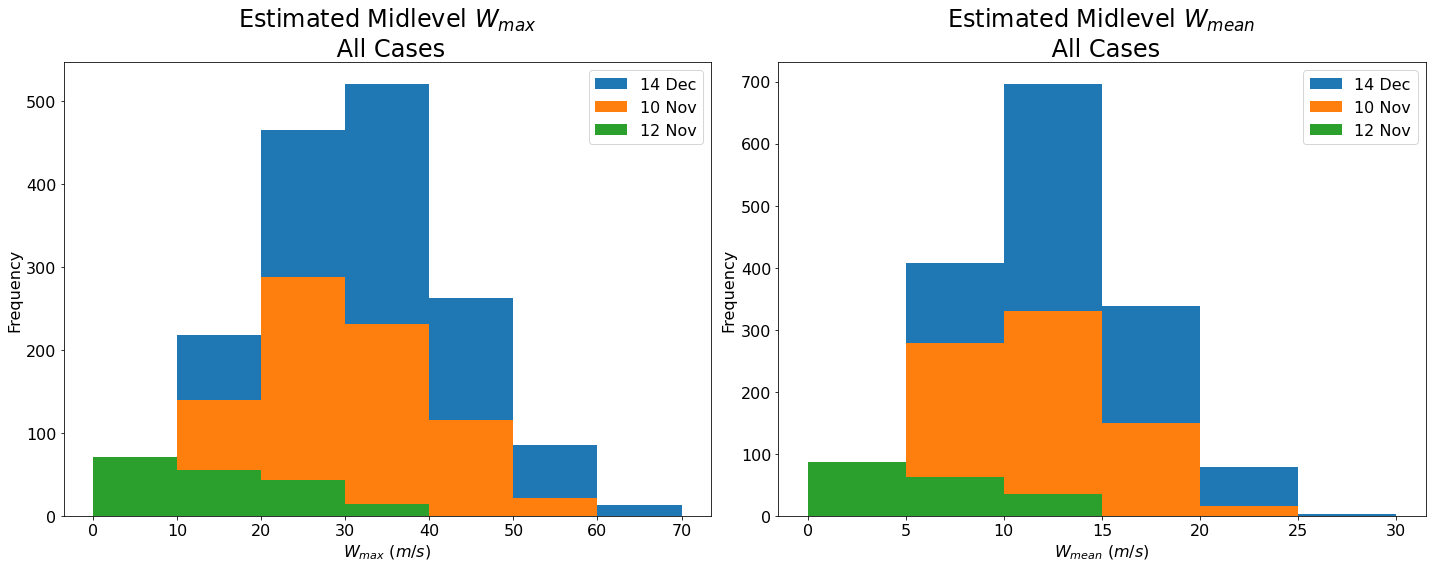

In [71]:
wmax_bins = np.arange(0, 80, 10)
wmean_bins = np.arange(0,35,5)

fig = plt.figure(figsize=(20,8))

ax = plt.subplot(121)
ax.hist(dec_14.ot_depth * 22.78, wmax_bins, label='14 Dec')
ax.hist(nov_10.ot_depth * 22.78, wmax_bins, label='10 Nov')
ax.hist(nov_12.ot_depth * 22.78, wmax_bins, label='12 Nov')


plt.title('Estimated Midlevel $W_{max}$ \n All Cases', fontsize=24)

plt.xlabel('$W_{max}$ ($m/s$)', fontsize=16)
plt.ylabel('Frequency', fontsize=16)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc='upper right', fontsize=16)


ax = plt.subplot(122)
ax.hist(dec_14.ot_depth * 8.89, wmean_bins, label='14 Dec')
ax.hist(nov_10.ot_depth * 8.89, wmean_bins, label='10 Nov')
ax.hist(nov_12.ot_depth * 8.89, wmean_bins, label='12 Nov')


plt.title('Estimated Midlevel $W_{mean}$ \n All Cases', fontsize=24)

plt.xlabel('$W_{mean}$ ($m/s$)', fontsize=16)
plt.ylabel('Frequency', fontsize=16)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc='upper right', fontsize=16)

plt.tight_layout()
plt.savefig('Estimated_wmax_wmean.png', dpi=300)

In [75]:
np.median(df.ot_depth * 8.89)

10.845793895721421

In [39]:
np.median(dec_14.est_wmax * 0.386)

18.2555918321533

In [40]:
np.median(df.ot_depth * wmean_scale)

10.857993888854981

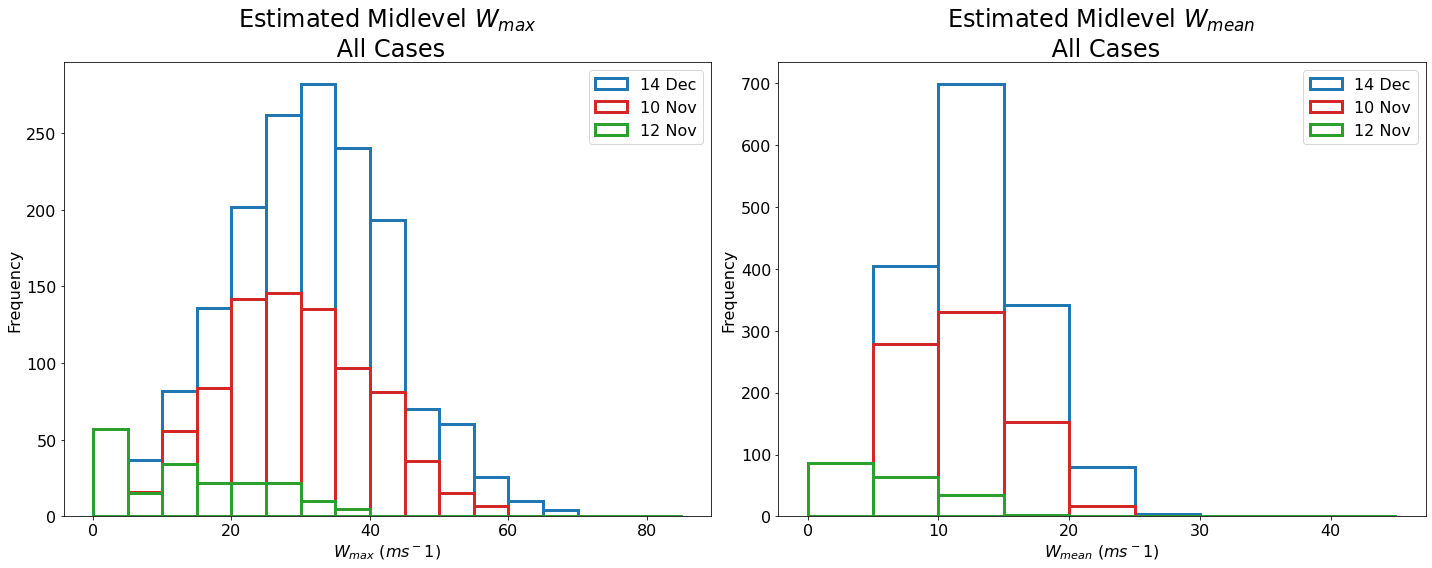

In [67]:
wmax_scale = 22.8
wmean_scale = 8.9

wmax_bins = np.arange(0, 90, 5)
wmean_bins = np.arange(0,50,5)

fig = plt.figure(figsize=(20,8))

ax = plt.subplot(121)
ax.hist(dec_14.ot_depth * wmax_scale, wmax_bins, label='14 Dec',
        color='white', edgecolor='tab:blue', linewidth=3)
ax.hist(nov_10.ot_depth * wmax_scale, wmax_bins, label='10 Nov',
        color='white', edgecolor='tab:red', linewidth=3)
ax.hist(nov_12.ot_depth * wmax_scale, wmax_bins, label='12 Nov',
        color='white', edgecolor='tab:green', linewidth=3)


plt.title('Estimated Midlevel $W_{max}$ \n All Cases', fontsize=24)

plt.xlabel('$W_{max}$ ($ms^-1$)', fontsize=16)
plt.ylabel('Frequency', fontsize=16)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc='upper right', fontsize=16)


ax = plt.subplot(122)
ax.hist(dec_14.ot_depth * wmean_scale, wmean_bins, label='14 Dec',
        color='white', edgecolor='tab:blue', linewidth=3)
ax.hist(nov_10.ot_depth * wmean_scale, wmean_bins, label='10 Nov',
        color='white', edgecolor='tab:red', linewidth=3)
ax.hist(nov_12.ot_depth * wmean_scale, wmean_bins, label='12 Nov',
        color='white', edgecolor='tab:green', linewidth=3)


plt.title('Estimated Midlevel $W_{mean}$ \n All Cases', fontsize=24)

plt.xlabel('$W_{mean}$ ($ms^-1$)', fontsize=16)
plt.ylabel('Frequency', fontsize=16)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc='upper right', fontsize=16)

plt.tight_layout()
plt.savefig('Estimated_wmax_wmean.png', dpi=300)

In [48]:
np.max(df.ot_depth * wmax_scale)

71.16473251342774

In [47]:
np.sqrt(2 * 2900)

76.15773105863909

In [ ]:
u_core_bins = np.arange(0, 6.25, .25)
ua_bins = np.arange(0, 100, 10)
fig = plt.figure(figsize=(20,8))

ax = plt.subplot(121)
ax.hist(calc_r(dec_14.area_polygon), u_core_bins, label='14 Dec')
ax.hist(calc_r(nov_10.area_polygon), u_core_bins, label='10 Nov')
ax.hist(calc_r(nov_12.area_polygon), u_core_bins, label='12 Nov')


plt.title('Estimated Updraft Radius \n All Cases', fontsize=24)

plt.xlabel('Updraft Core Radius ($km$)', fontsize=16)
plt.ylabel('Frequency', fontsize=16)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc='upper right', fontsize=16)

ax2 = plt.subplot(122)
#plt.hist(df_max.area_polygon * 0.4032)



ax2.hist(dec_14.area_polygon * 0.4032, ua_bins, label='14 Dec')
ax2.hist(nov_10.area_polygon * 0.4032, ua_bins, label='10 Nov')
ax2.hist(nov_12.area_polygon * 0.4032, ua_bins, label='12 Nov')


plt.title('Estimated Updraft Area \n All Cases', fontsize=24)

plt.xlabel('Updraft Core Area($km^2$)', fontsize=16)
plt.ylabel('Frequency', fontsize=16)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.legend(loc='upper right', fontsize=16)

plt.savefig('Updraft_Radius_Area.png', dpi=400)

<AxesSubplot:ylabel='Frequency'>

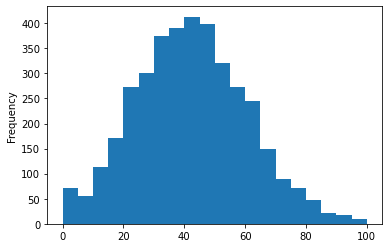

In [22]:
wmax_bins = np.arange(0, 105, 5)
df.est_wmax.plot.hist(bins=wmax_bins)

<AxesSubplot:ylabel='Frequency'>

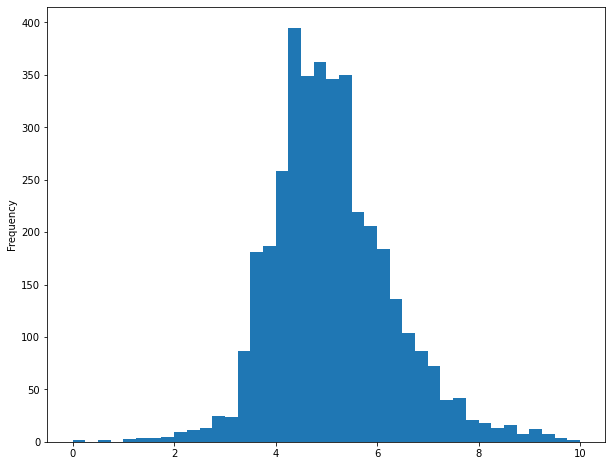

In [35]:
plt.figure(figsize=(10,8))
bins = np.arange(0, 10.25, .25)
df.mid_ud.plot.hist(bins=bins)

In [41]:
df['est_wmax'] = df.ot_depth * 34.238

/data/keeling/a/mgrover4/a/miniconda3/envs/xesmf_env/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


<AxesSubplot:ylabel='Frequency'>

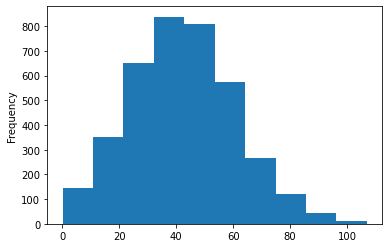

In [44]:
df.est_wmax.plot.hist()

In [19]:
df['lat_rounded'] = np.round(df.lat, 0)
df['lon_rounded'] = np.round(df.lon, 0)

/data/keeling/a/mgrover4/a/miniconda3/envs/xesmf_env/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/data/keeling/a/mgrover4/a/miniconda3/envs/xesmf_env/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [22]:
nov_10_all = df[df.day == 10]
nov_12_all = df[df.day == 12]
dec_14_all = df[df.day == 14]

In [23]:
u_core_bins * 2

NameError: name 'u_core_bins' is not defined

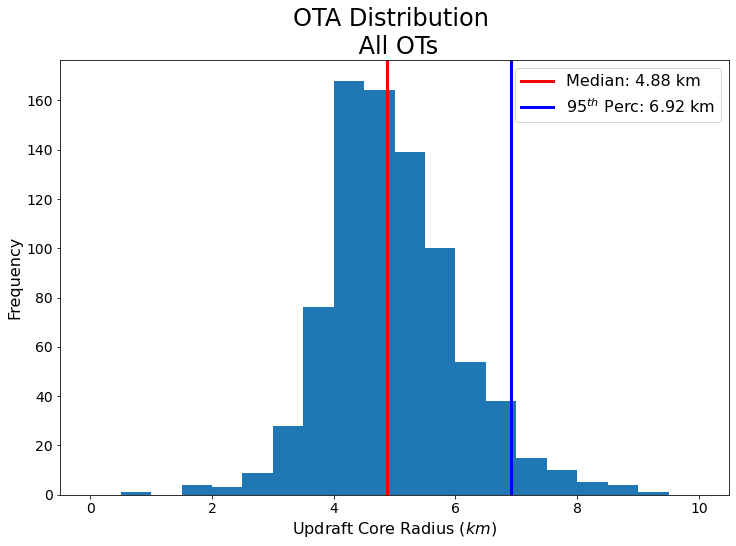

In [141]:
ur = calc_r(nov_10_all.area_polygon)
med = np.median(ur) * 2
top_perc = np.percentile(ur, 95) * 2

fig = plt.figure(figsize=(12,8))
plt.hist(ur * 2, u_core_bins * 2)

plt.axvline(med, color='r', linewidth=3, label=f'Median: {np.round(med,2)} km')
plt.axvline(top_perc, color='b', linewidth=3, label='$95^{th}$' + f' Perc: {np.round(top_perc, 2)} km')

plt.title('OTA Distribution \n All OTs', fontsize=24)

plt.xlabel('Updraft Core Radius ($km$)', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16)

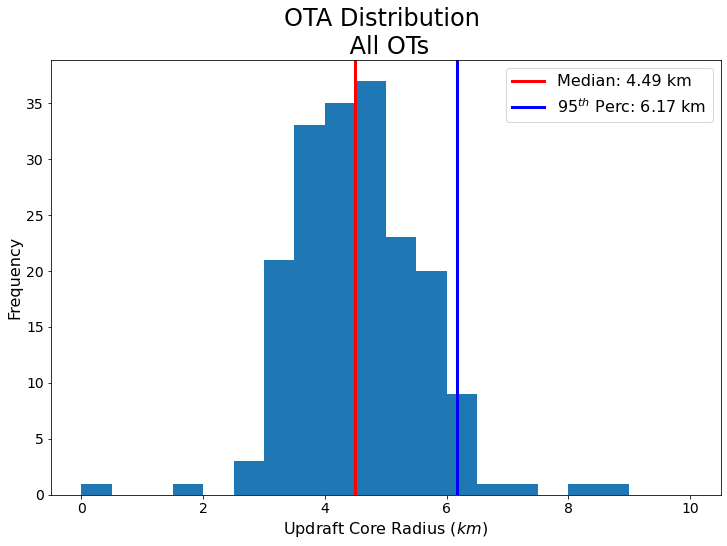

In [142]:
ur = calc_r(nov_12_all.area_polygon)
med = np.median(ur) * 2
top_perc = np.percentile(ur, 95) * 2

fig = plt.figure(figsize=(12,8))
plt.hist(ur * 2, u_core_bins * 2)

plt.axvline(med, color='r', linewidth=3, label=f'Median: {np.round(med,2)} km')
plt.axvline(top_perc, color='b', linewidth=3, label='$95^{th}$' + f' Perc: {np.round(top_perc, 2)} km')

plt.title('OTA Distribution \n All OTs', fontsize=24)

plt.xlabel('Updraft Core Radius ($km$)', fontsize=16)
plt.ylabel('Frequency', fontsize=16)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16)

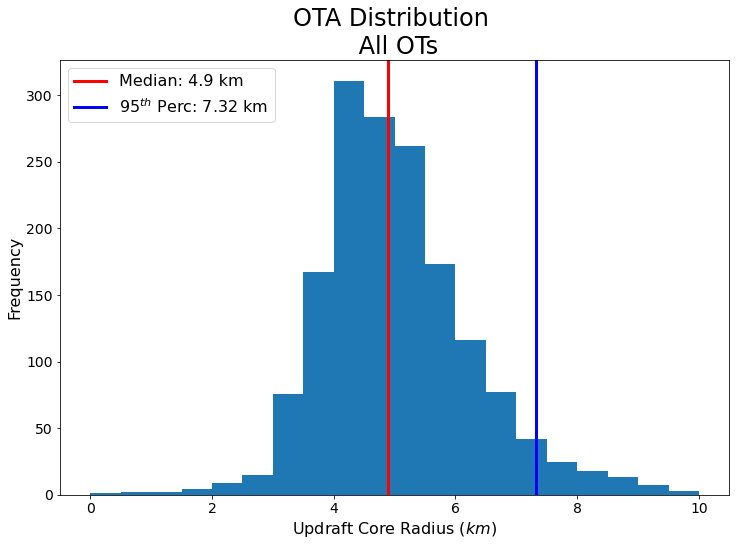

In [144]:
ur = calc_r(dec_14_all.area_polygon)
med = np.median(ur) * 2
top_perc = np.percentile(ur, 95) * 2

fig = plt.figure(figsize=(12,8))
plt.hist(ur * 2, u_core_bins * 2)

plt.axvline(med, color='r', linewidth=3, label=f'Median: {np.round(med,2)} km')
plt.axvline(top_perc, color='b', linewidth=3, label='$95^{th}$' + f' Perc: {np.round(top_perc, 2)} km')

plt.title('OTA Distribution \n All OTs', fontsize=24)

plt.xlabel('Updraft Core Radius ($km$)', fontsize=16)
plt.ylabel('Frequency', fontsize=16)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16)

Text(0.5, 1.0, 'Overshooting top tracks\n14 December 2018')

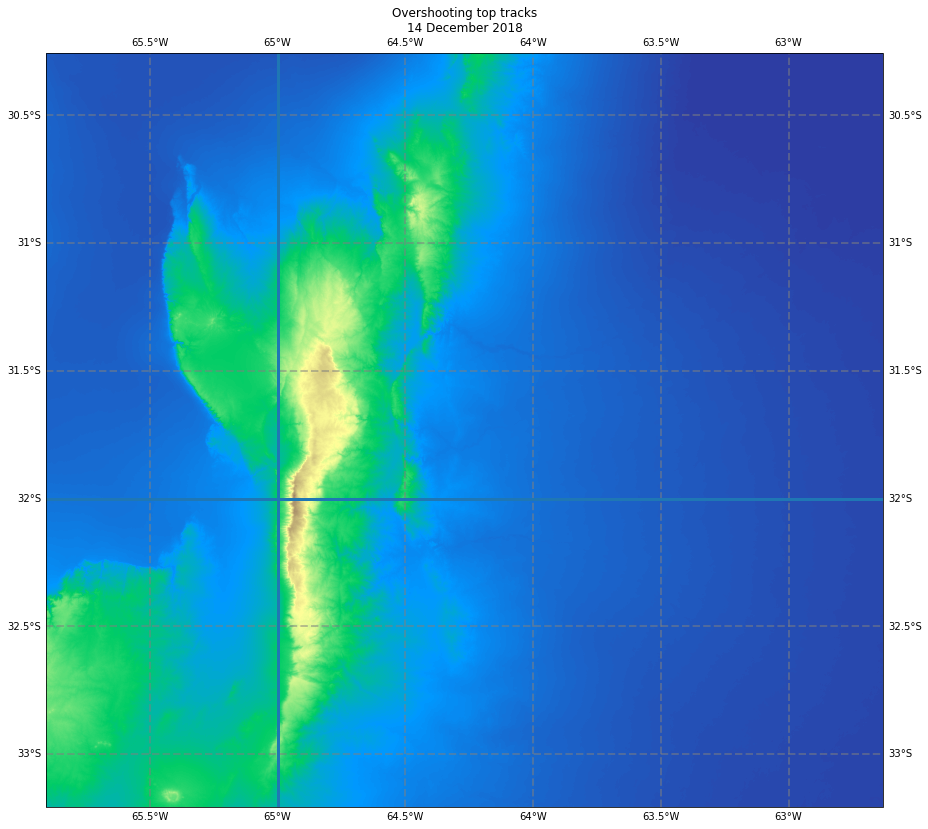

In [105]:
llcrnr=[-33.206342, -65.906586]
urcrnr=[-30.255825, -62.630553]

# Set extent of maps created in the following cells:
axis_extent=[llcrnr[1],urcrnr[1],llcrnr[0],urcrnr[0]]    

# Plot map with all individual tracks:
import cartopy.crs as ccrs
fig_map,ax_map=plt.subplots(figsize=(15,15),subplot_kw={'projection': ccrs.PlateCarree()})

ax_map.coastlines()

ax_map.set_extent(axis_extent)

for ds in ds_list:
#    cm = ax.contourf(ds.x.values[::5], ds.y.values[::5], ds.values[::5,::5], levs, cmap='terrain', transform=ccrs.PlateCarree())
    cm = ax_map.imshow(ds.values, extent =[ds.x.min(),ds.x.max(),ds.y.min(),ds.y.max()], transform=ccrs.PlateCarree(), vmin=0, vmax=4000, cmap='terrain')

gl = ax_map.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')

#for name, group in cells_grouped:
#    print(group.x,group.y)
#    cm2 = plt.scatter(group.lon,group.lat,c=group.area_polygon,vmin=0.,vmax=200.,s=group.area_polygon,
#                     facecolors='none',cmap='magma',linewidth=0.5)

#plt.colorbar(cm,label='Elevation (m)',shrink=0.4, pad=0.0)
#plt.colorbar(cm2,label='OT Area (km$^2$)',shrink=0.4, pad=0.1)

ax.add_feature(cfeature.STATES, linestyle=":")

plt.axvline(-65, linewidth=3)
plt.axhline(-32, linewidth=3)


ax_map.set_title('Overshooting top tracks\n14 December 2018')

Text(0, 0.5, 'Frequency')

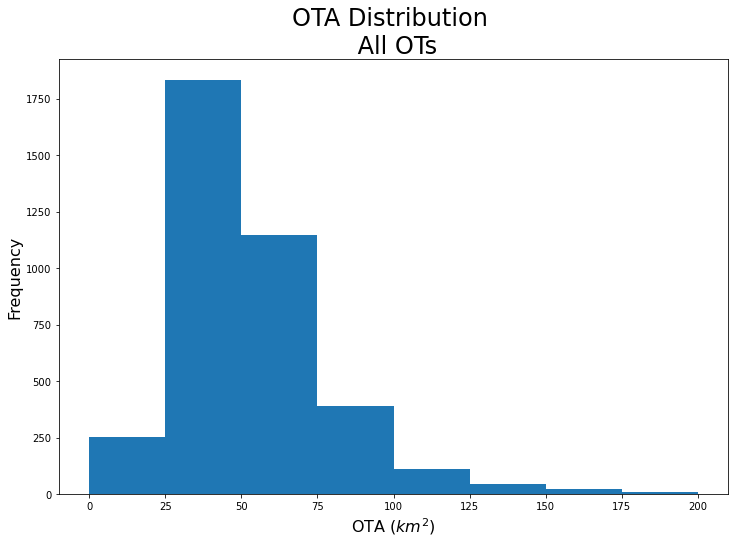

In [13]:
fig = plt.figure(figsize=(12,8))
plt.hist(df.area_polygon, bins=ota_bins)

plt.title('OTA Distribution \n All OTs', fontsize=24)

plt.xlabel('OTA ($km^2$)', fontsize=16)
plt.ylabel('Frequency', fontsize=16)

In [25]:
u_core_bins = np.arange(0, 5.25, .25)

In [26]:
np.median(calc_r(df_max.area_polygon)) * 2

5.498395714122815

In [30]:
np.median(calc_r(df.area_polygon)) * 2

4.769737992345483

/data/keeling/a/mgrover4/a/miniconda3/envs/xesmf_env/lib/python3.7/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  """Entry point for launching an IPython kernel.


<BarContainer object of 10 artists>

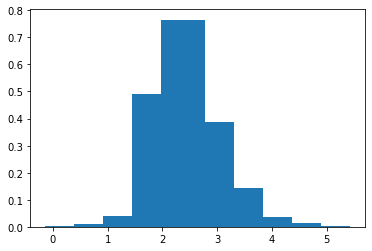

In [32]:
hist, bins = np.histogram(calc_r(df.area_polygon), bins=10, normed=True)
bin_centers = (bins[1:]+bins[:-1])*0.5
plt.bar(bin_centers, hist)

Text(0, 0.5, 'Frequency')

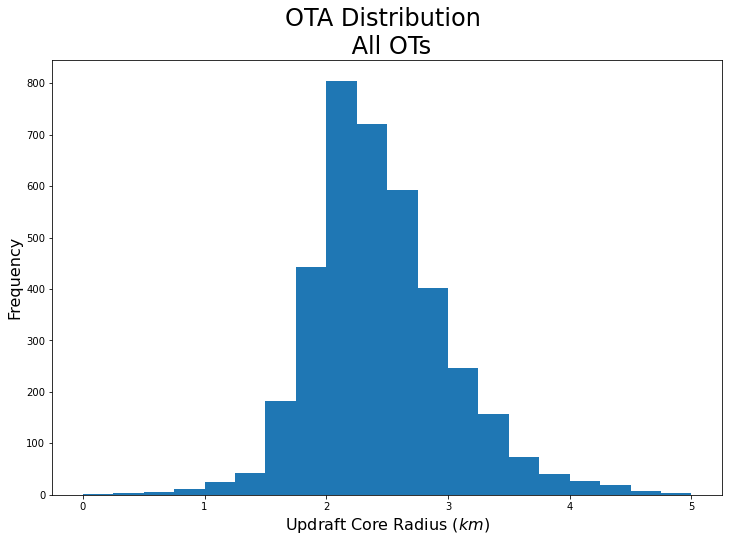

In [33]:
fig = plt.figure(figsize=(12,8))
plt.hist(calc_r(df.area_polygon), u_core_bins)

plt.title('OTA Distribution \n All OTs', fontsize=24)

plt.xlabel('Updraft Core Radius ($km$)', fontsize=16)
plt.ylabel('Frequency', fontsize=16)

Text(0, 0.5, 'Frequency')

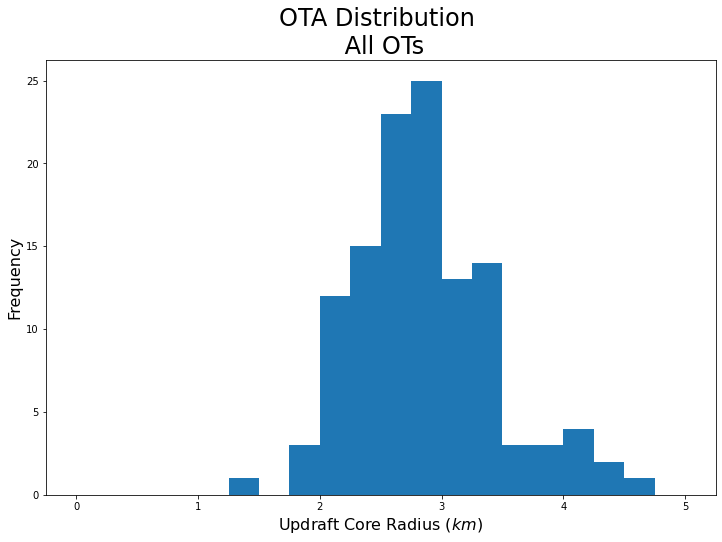

In [34]:
fig = plt.figure(figsize=(12,8))
plt.hist(calc_r(nov_10.area_polygon), u_core_bins)

plt.title('OTA Distribution \n All OTs', fontsize=24)

plt.xlabel('Updraft Core Radius ($km$)', fontsize=16)
plt.ylabel('Frequency', fontsize=16)

Text(0, 0.5, 'Frequency')

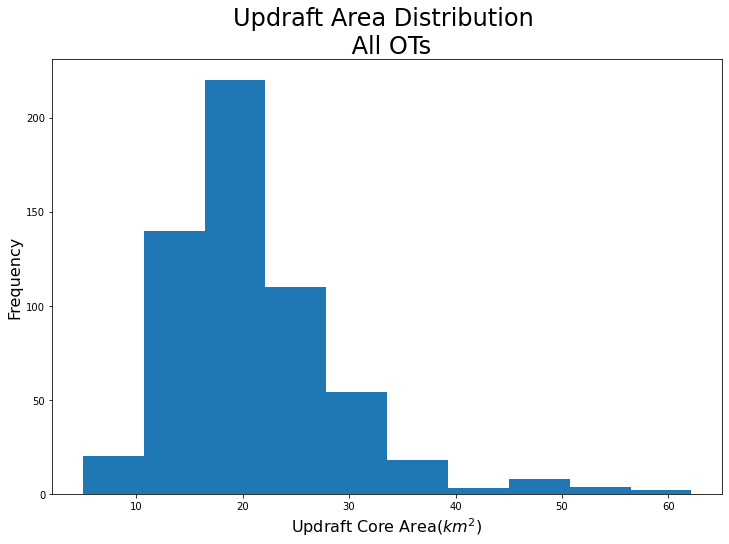

In [44]:
fig = plt.figure(figsize=(12,8))
plt.hist(df_max.area_polygon * 0.4032)

plt.title('Updraft Area Distribution \n All OTs', fontsize=24)

plt.xlabel('Updraft Core Area($km^2$)', fontsize=16)
plt.ylabel('Frequency', fontsize=16)


Text(0, 0.5, 'Frequency')

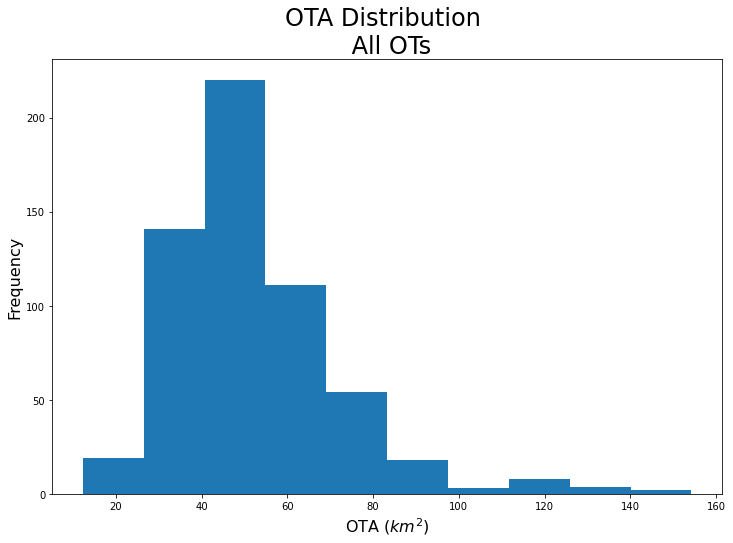

In [216]:
fig = plt.figure(figsize=(12,8))
plt.hist(df_max.area_polygon)

plt.title('OTA Distribution \n All OTs', fontsize=24)

plt.xlabel('OTA ($km^2$)', fontsize=16)
plt.ylabel('Frequency', fontsize=16)

In [102]:
slope, intercept, r, p, stderr = scipy.stats.linregress(df_max.mid_ur, df_max.ot_depth)

line = f'r={r:.2f}'

plt.figure(figsize=(10,8))
ax = plt.subplot(111)
#max_depth_nov_10 = max_depth[max_depth.day == 10]
ax.scatter(dec_14.mid_ur, dec_14.ot_depth, color='tab:blue', label='14 December 2018')
ax.scatter(nov_12.mid_ur, nov_12.ot_depth, color='tab:green', label='12 November 2018')
ax.scatter(nov_10.mid_ur, nov_10.ot_depth, color='tab:red', label='10 November 2018')

ax.scatter(np.median(dec_14.mid_ur), np.median(dec_14.ot_depth), color='blue', s=100)
ax.scatter(np.median(nov_10.mid_ur), np.median(nov_10.ot_depth), color='red', s=100)
ax.scatter(np.median(nov_12.mid_ur), np.median(nov_12.ot_depth), color='green', s=100)

ax.plot(np.array(df_max.mid_ur), intercept + slope * np.array(df_max.mid_ur), label=line, color='black')

plt.xlabel('Midlevel Updraft Radius ($km$)', fontsize=12)
plt.ylabel('OT Depth $(km)$', fontsize=12)

plt.legend(loc='upper right', fontsize=12)

plt.title('OT Duration All OTs  \n 10 November, 12 November, 14 December 2018 UTC (Count = 1022)', fontsize=16)

AttributeError: 'DataFrame' object has no attribute 'mid_ur'

Text(0.5, 1.0, 'OT Duration All OTs  \n 10 November, 12 November, 14 December 2018 UTC (Count = 1022)')

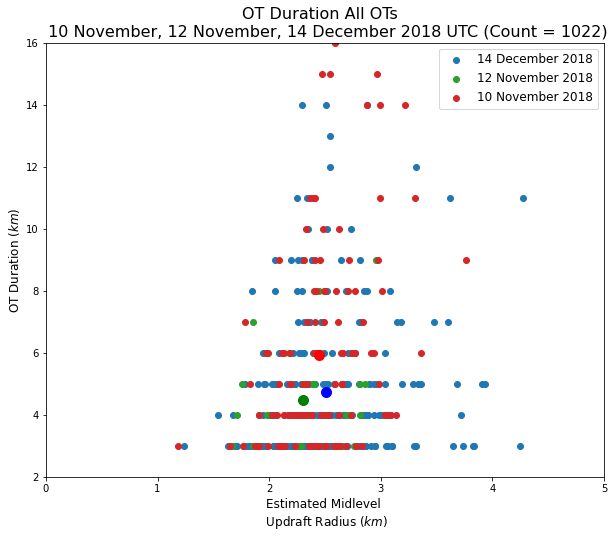

In [67]:
plt.figure(figsize=(10,8))
ax = plt.subplot(111)
#max_depth_nov_10 = max_depth[max_depth.day == 10]
ax.scatter(dec_14.mid_ur, dec_14.duration, color='tab:blue', label='14 December 2018')
ax.scatter(nov_12.mid_ur, nov_12.duration, color='tab:green', label='12 November 2018')
ax.scatter(nov_10.mid_ur, nov_10.duration, color='tab:red', label='10 November 2018')

ax.scatter(np.mean(dec_14.mid_ur), np.mean(dec_14.duration), color='blue', s=100)
ax.scatter(np.mean(nov_10.mid_ur), np.mean(nov_10.duration), color='red', s=100)
ax.scatter(np.mean(nov_12.mid_ur), np.mean(nov_12.duration), color='green', s=100)

#ax.plot(np.array(df_max.mid_ur), intercept + slope * np.array(df_max.mid_ur), label=line, color='black')

plt.xlabel('Estimated Midlevel \n Updraft Radius ($km$)', fontsize=12)
plt.ylabel('OT Duration $(km)$', fontsize=12)

plt.legend(loc='upper right', fontsize=12)

plt.xlim(0,5)
plt.ylim(2,16)

plt.title('OT Duration All OTs  \n 10 November, 12 November, 14 December 2018 UTC (Count = 1022)', fontsize=16)

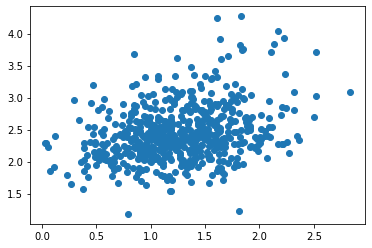

In [55]:
plt.scatter(df_max.ot_depth, df_max.mid_ur)

In [106]:
uar_dec14 = calc_r(dec_14.area_polygon)
uar_nov10 = calc_r(nov_10.area_polygon)
uar_nov12 = calc_r(nov_10.area_polygon)

In [107]:
ota = df_max.area_polygon
u_r = calc_r(ota)
ot_r = calc_r(ota, 1)

In [108]:
np.percentile(u_r, 90)

3.0136419031378203

In [115]:
slope, intercept, r, p, stderr = scipy.stats.linregress(u_r, df_max.ot_depth)

In [151]:
df_max['u_diam'] = np.round(u_r* 2, 0)
df_max['round_area'] = np.round(df_max.area_polygon, -1)

<AxesSubplot:title={'center':'ot_depth'}, xlabel='u_diam'>

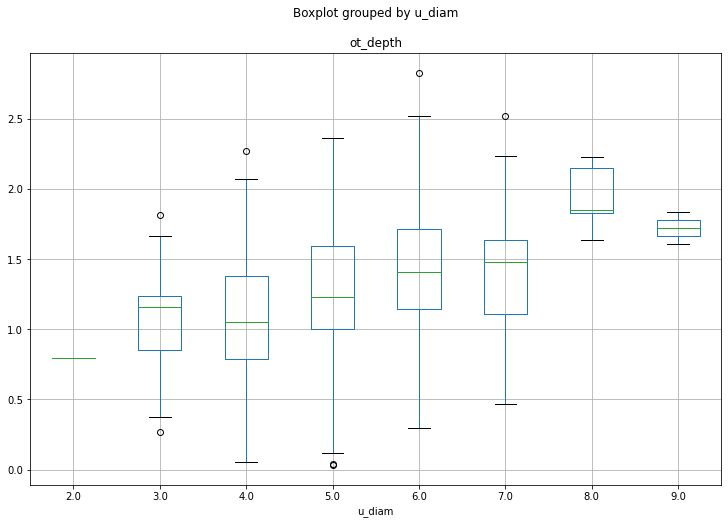

In [152]:
fig = plt.figure(figsize=(12,8))

ax = plt.subplot(111)
df_max.boxplot('ot_depth', by='u_diam', ax=ax)

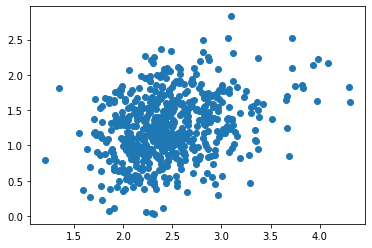

In [209]:
plt.scatter(u_r, df_max.ot_depth)

In [156]:
np.median(calc_r(dec_14.area_polygon)) * 2

4.894120115882311

In [178]:
np.median(calc_r(dec_14.area_polygon))

2.4470600579411554

In [106]:
mean_nov10 = np.mean(calc_r(nov_10.area_polygon) * 2)
mean_nov12 = np.mean(calc_r(nov_12.area_polygon) * 2)
mean_dec14 = np.mean(calc_r(dec_14.area_polygon) * 2)

std_nov10 = np.std(calc_r(nov_10.area_polygon) * 2)
std_nov12 = np.std(calc_r(nov_12.area_polygon) * 2)
std_dec14 = np.std(calc_r(dec_14.area_polygon) * 2)

(4.0, 6.0)

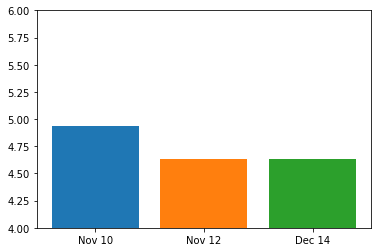

In [107]:
plt.bar('Nov 10', mean_nov10)
plt.bar('Nov 12', mean_nov12)
plt.bar('Dec 14', mean_nov12)



plt.ylim(4,6)

(array([0., 0., 0., 0., 0., 0., 2., 6., 4., 7., 3., 5., 0., 0., 0., 0., 0.,
        0., 0., 0.]),
 array([0.  , 0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 ,
        2.75, 3.  , 3.25, 3.5 , 3.75, 4.  , 4.25, 4.5 , 4.75, 5.  ]),
 <BarContainer object of 20 artists>)

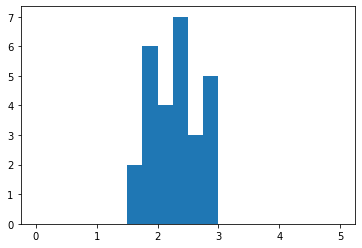

In [206]:
plt.hist(calc_r(nov_12.area_polygon), u_core_bins, label='12 Nov')

(array([ 0.,  0.,  0.,  0.,  1.,  0.,  1., 11., 19., 35., 28., 10., 10.,
         3.,  0.,  1.,  0.,  0.,  0.,  0.]),
 array([0.  , 0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 ,
        2.75, 3.  , 3.25, 3.5 , 3.75, 4.  , 4.25, 4.5 , 4.75, 5.  ]),
 <BarContainer object of 20 artists>)

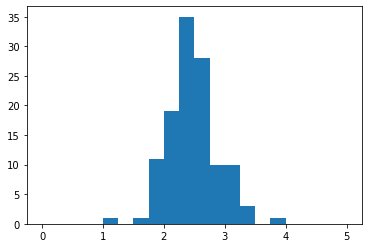

In [207]:
plt.hist(calc_r(nov_10.area_polygon), u_core_bins, label='12 Nov')

(array([ 0.,  0.,  0.,  0.,  0.,  1.,  5., 22., 42., 68., 49., 35., 15.,
         7.,  6.,  5.,  0.,  2.,  0.,  0.]),
 array([0.  , 0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 ,
        2.75, 3.  , 3.25, 3.5 , 3.75, 4.  , 4.25, 4.5 , 4.75, 5.  ]),
 <BarContainer object of 20 artists>)

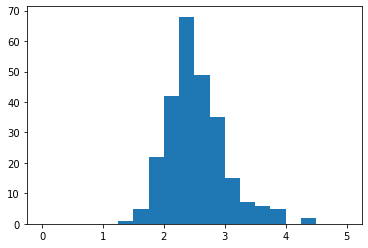

In [208]:
plt.hist(calc_r(dec_14.area_polygon), u_core_bins, label='14 Dec')

In [17]:
ot_core_bins = np.arange(0, 10, .25)

NameError: name 'ot_core_bins' is not defined

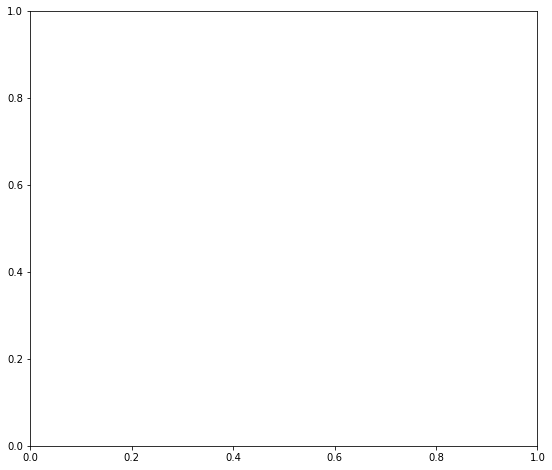

In [33]:
fig = plt.figure(figsize=(20,8))

ax = plt.subplot(121)
ax.hist(calc_r(dec_14.area_polygon, 1), ot_core_bins, label='14 Dec')
ax.hist(calc_r(nov_10.area_polygon, 1), ot_core_bins, label='10 Nov')
ax.hist(calc_r(nov_12.area_polygon, 1), ot_core_bins, label='12 Nov')


plt.title('OT Effective Radius \n All Cases', fontsize=24)

plt.xlabel('OT Radius ($km$)', fontsize=16)
plt.ylabel('Frequency', fontsize=16)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc='upper right', fontsize=16)

ax2 = plt.subplot(122)
#plt.hist(df_max.area_polygon * 0.4032)



ax2.hist(dec_14.area_polygon, bins=ota_bins, label='14 Dec')
ax2.hist(nov_10.area_polygon, bins=ota_bins, label='10 Nov')
ax2.hist(nov_12.area_polygon, bins=ota_bins, label='12 Nov')


plt.title('OTA \n All Cases', fontsize=24)

plt.xlabel('OTA ($km^2$)', fontsize=16)
plt.ylabel('Frequency', fontsize=16)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.legend(loc='upper right', fontsize=16)

plt.savefig('OT_Radius_Duration.png', dpi=400)

NameError: name 'calc_r' is not defined

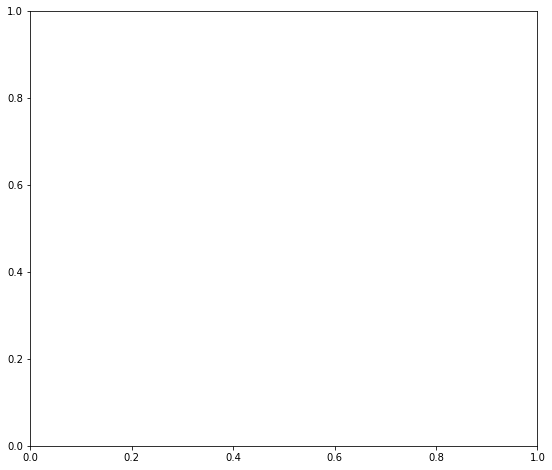

In [14]:
fig = plt.figure(figsize=(20,8))

ax = plt.subplot(121)
ax.hist(calc_r(df_max.area_polygon, 1), ot_core_bins, label='14 Dec')


plt.title('OT Effective Radius \n All Cases', fontsize=24)

plt.xlabel('OT Radius ($km$)', fontsize=16)
plt.ylabel('Frequency', fontsize=16)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
#plt.legend(loc='upper right', fontsize=16)

ax2 = plt.subplot(122)
#plt.hist(df_max.area_polygon * 0.4032)



ax2.hist(df_max.area_polygon, bins=ota_bins, label='14 Dec')


plt.title('OTA \n All Cases', fontsize=24)

plt.xlabel('OTA ($km^2$)', fontsize=16)
plt.ylabel('Frequency', fontsize=16)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

#plt.legend(loc='upper right', fontsize=16)

plt.savefig('OT_Radius_Duration.png', dpi=400)

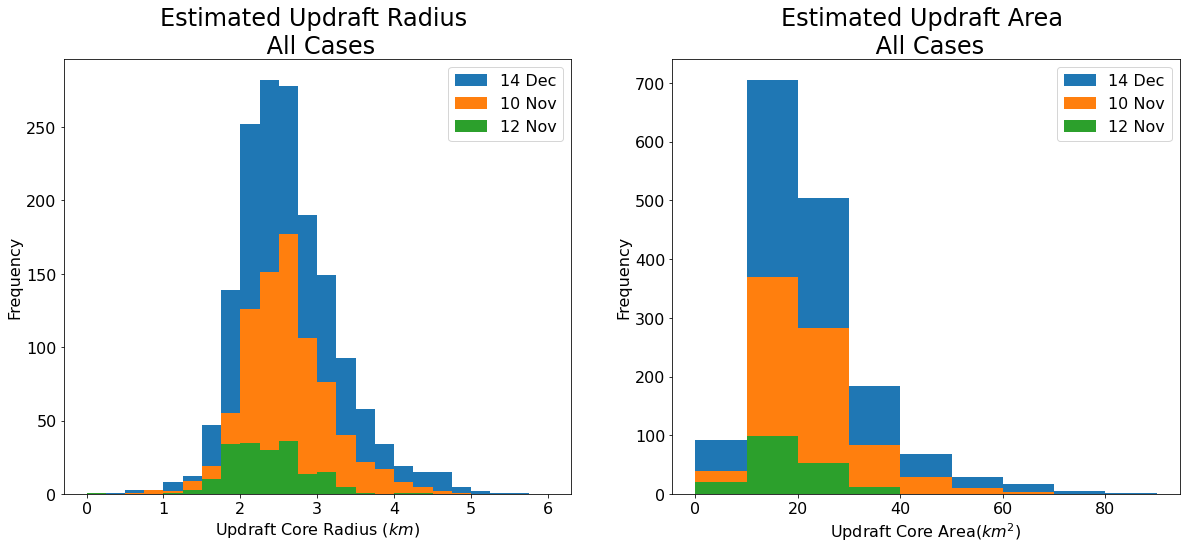

In [57]:
nov_10 = df[df.day == 10]
nov_12 = df[df.day == 12]
dec_14 = df[df.day == 14]

nov_10_mean = nov_10.groupby('cell').mean()
nov_12_mean = nov_12.groupby('cell').mean()
dec_14_mean = dec_14.groupby('cell').mean()

nov_10_max = nov_10.groupby('cell').max()
nov_12_max = nov_12.groupby('cell').max()
dec_14_max = dec_14.groupby('cell').max()

u_core_bins = np.arange(0, 6.25, .25)
ua_bins = np.arange(0, 100, 10)
fig = plt.figure(figsize=(20,8))

ax = plt.subplot(121)
ax.hist(calc_r(dec_14.area_polygon), u_core_bins, label='14 Dec')
ax.hist(calc_r(nov_10.area_polygon), u_core_bins, label='10 Nov')
ax.hist(calc_r(nov_12.area_polygon), u_core_bins, label='12 Nov')


plt.title('Estimated Updraft Radius \n All Cases', fontsize=24)

plt.xlabel('Updraft Core Radius ($km$)', fontsize=16)
plt.ylabel('Frequency', fontsize=16)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc='upper right', fontsize=16)

ax2 = plt.subplot(122)
#plt.hist(df_max.area_polygon * 0.4032)



ax2.hist(dec_14.area_polygon * 0.4032, ua_bins, label='14 Dec')
ax2.hist(nov_10.area_polygon * 0.4032, ua_bins, label='10 Nov')
ax2.hist(nov_12.area_polygon * 0.4032, ua_bins, label='12 Nov')


plt.title('Estimated Updraft Area \n All Cases', fontsize=24)

plt.xlabel('Updraft Core Area($km^2$)', fontsize=16)
plt.ylabel('Frequency', fontsize=16)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.legend(loc='upper right', fontsize=16)

plt.savefig('Updraft_Radius_Area.png', dpi=400)

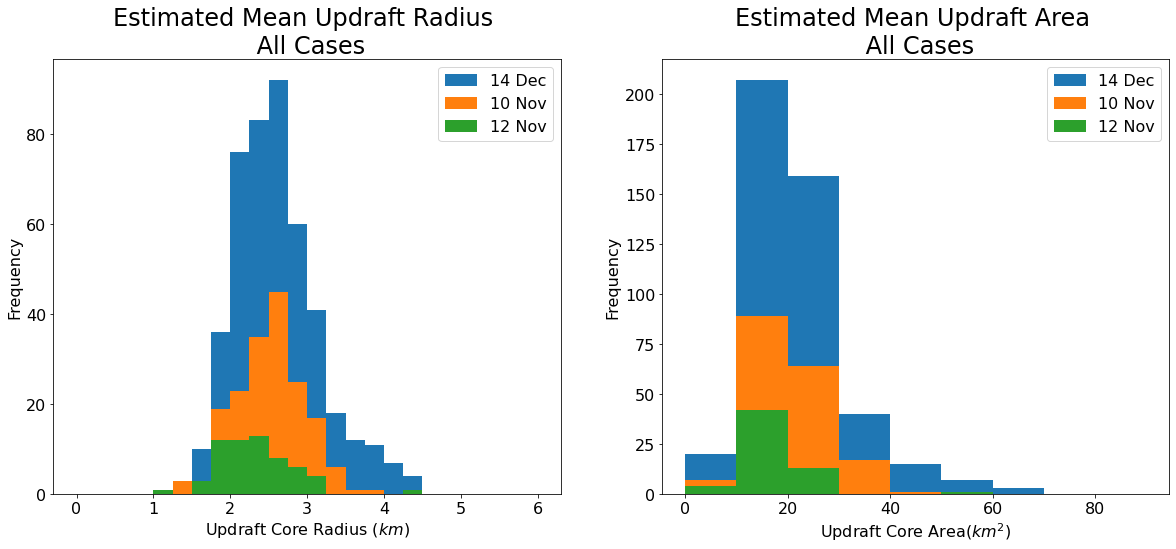

In [56]:
u_core_bins = np.arange(0, 6.25, .25)
ua_bins = np.arange(0, 100, 10)
fig = plt.figure(figsize=(20,8))

ax = plt.subplot(121)
ax.hist(calc_r(dec_14_mean.area_polygon), u_core_bins, label='14 Dec')
ax.hist(calc_r(nov_10_mean.area_polygon), u_core_bins, label='10 Nov')
ax.hist(calc_r(nov_12_mean.area_polygon), u_core_bins, label='12 Nov')


plt.title('Estimated Mean Updraft Radius \n All Cases', fontsize=24)

plt.xlabel('Updraft Core Radius ($km$)', fontsize=16)
plt.ylabel('Frequency', fontsize=16)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc='upper right', fontsize=16)

ax2 = plt.subplot(122)
#plt.hist(df_max.area_polygon * 0.4032)



ax2.hist(dec_14_mean.area_polygon * 0.4032, ua_bins, label='14 Dec')
ax2.hist(nov_10_mean.area_polygon * 0.4032, ua_bins, label='10 Nov')
ax2.hist(nov_12_mean.area_polygon * 0.4032, ua_bins, label='12 Nov')


plt.title('Estimated Mean Updraft Area \n All Cases', fontsize=24)

plt.xlabel('Updraft Core Area($km^2$)', fontsize=16)
plt.ylabel('Frequency', fontsize=16)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.legend(loc='upper right', fontsize=16)

plt.savefig('Updraft_Radius_Area_mean.png', dpi=400)

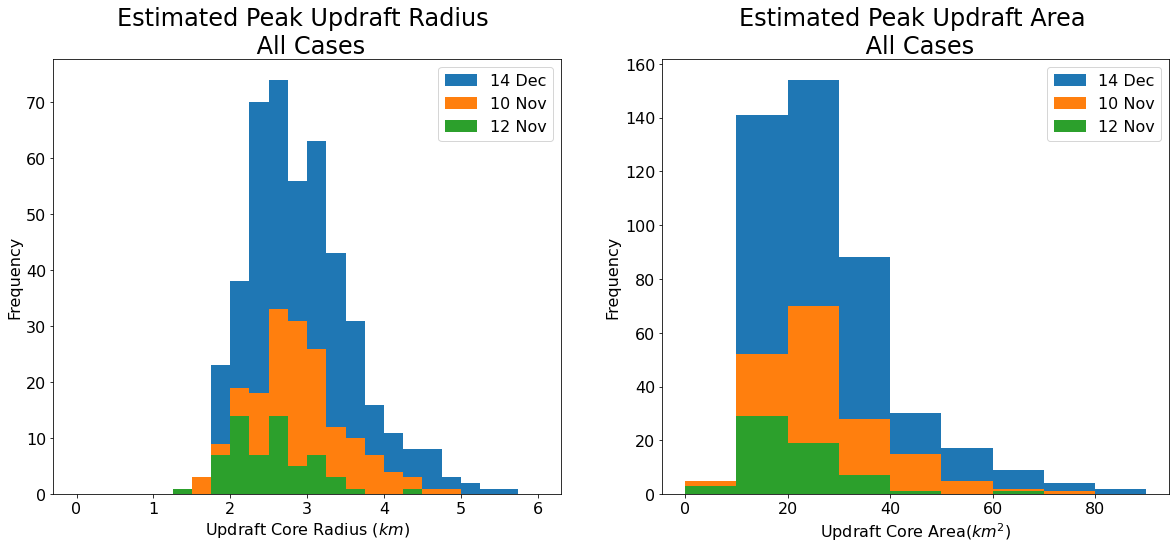

In [58]:
u_core_bins = np.arange(0, 6.25, .25)
ua_bins = np.arange(0, 100, 10)
fig = plt.figure(figsize=(20,8))

ax = plt.subplot(121)
ax.hist(calc_r(dec_14_max.area_polygon), u_core_bins, label='14 Dec')
ax.hist(calc_r(nov_10_max.area_polygon), u_core_bins, label='10 Nov')
ax.hist(calc_r(nov_12_max.area_polygon), u_core_bins, label='12 Nov')


plt.title('Estimated Peak Updraft Radius \n All Cases', fontsize=24)

plt.xlabel('Updraft Core Radius ($km$)', fontsize=16)
plt.ylabel('Frequency', fontsize=16)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc='upper right', fontsize=16)

ax2 = plt.subplot(122)
#plt.hist(df_max.area_polygon * 0.4032)



ax2.hist(dec_14_max.area_polygon * 0.4032, ua_bins, label='14 Dec')
ax2.hist(nov_10_max.area_polygon * 0.4032, ua_bins, label='10 Nov')
ax2.hist(nov_12_max.area_polygon * 0.4032, ua_bins, label='12 Nov')


plt.title('Estimated Peak Updraft Area \n All Cases', fontsize=24)

plt.xlabel('Updraft Core Area($km^2$)', fontsize=16)
plt.ylabel('Frequency', fontsize=16)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.legend(loc='upper right', fontsize=16)

plt.savefig('Updraft_Radius_Area_max.png', dpi=400)

In [46]:
u_core_bins = np.arange(0, 6.25, .25)
ua_bins = np.arange(0, 90, 10)
fig = plt.figure(figsize=(20,8))

ax = plt.subplot(121)
ax.hist(calc_r(dec_14.area_polygon, u_core_bins, label='14 Dec')
ax.hist(nov_10.area_polygon, u_core_bins, label='10 Nov')
ax.hist(nov_12.area_polygon, u_core_bins, label='12 Nov')


plt.title('OT Radius \n All Cases', fontsize=24)

plt.xlabel('OT Radius ($km$)', fontsize=16)
plt.ylabel('Frequency', fontsize=16)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc='upper right', fontsize=16)

ax2 = plt.subplot(122)
#plt.hist(df_max.area_polygon * 0.4032)



ax2.hist(dec_14.area_polygon, ua_bins, label='14 Dec')
ax2.hist(nov_10.area_polygon, ua_bins, label='10 Nov')
ax2.hist(nov_12.area_polygon, ua_bins, label='12 Nov')


plt.title('OT Area \n All Cases', fontsize=24)

plt.xlabel('OTA ($km^2$)', fontsize=16)
plt.ylabel('Frequency', fontsize=16)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.legend(loc='upper right', fontsize=16)

plt.savefig('OT_r_OTA_Duration.png', dpi=400)

cell
963     1.841556
971     1.036429
974     1.212000
975     1.747834
977     1.369286
          ...   
1937    0.566249
1940    0.558000
1941    1.128167
1946    1.026000
1949    0.437749
Name: ot_depth, Length: 257, dtype: float64

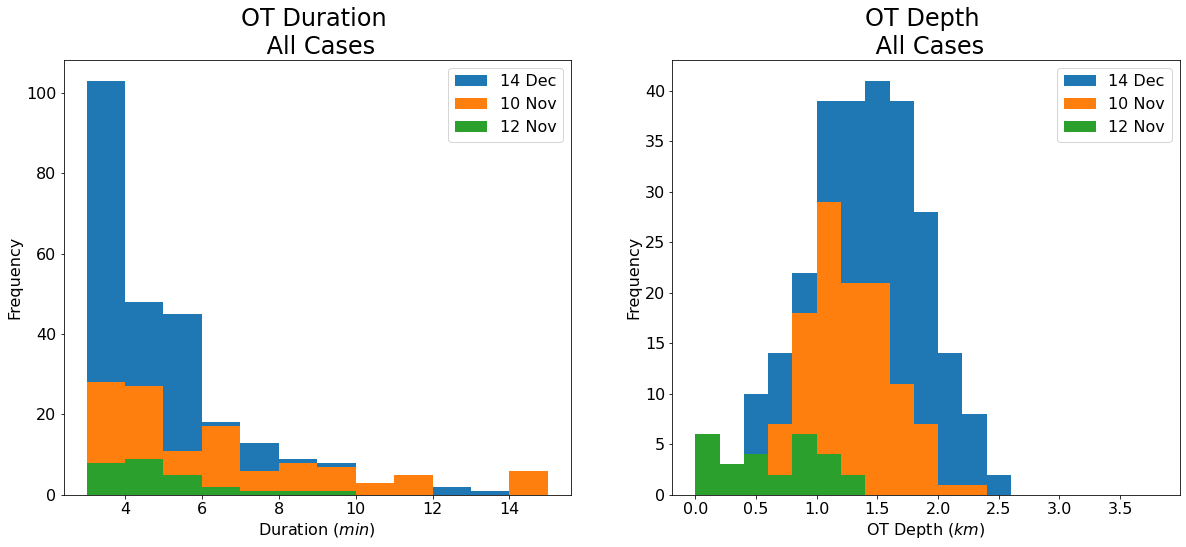

In [47]:
fig = plt.figure(figsize=(20,8))

ax = plt.subplot(121)
ax.hist(dec_14.duration, dur_bins, label='14 Dec')
ax.hist(nov_10.duration, dur_bins, label='10 Nov')
ax.hist(nov_12.duration, dur_bins, label='12 Nov')


plt.title('OT Duration \n All Cases', fontsize=24)

plt.xlabel('Duration ($min$)', fontsize=16)
plt.ylabel('Frequency', fontsize=16)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc='upper right', fontsize=16)

ax2 = plt.subplot(122)
#plt.hist(df_max.area_polygon * 0.4032)



ax2.hist(dec_14.ot_depth, otd_bins, label='14 Dec')
ax2.hist(nov_10.ot_depth, otd_bins, label='10 Nov')
ax2.hist(nov_12.ot_depth, otd_bins, label='12 Nov')


plt.title('OT Depth \n All Cases', fontsize=24)

plt.xlabel('OT Depth ($km$)', fontsize=16)
plt.ylabel('Frequency', fontsize=16)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.legend(loc='upper right', fontsize=16)

plt.savefig('OT_Duration_OT_Depth.png', dpi=400)

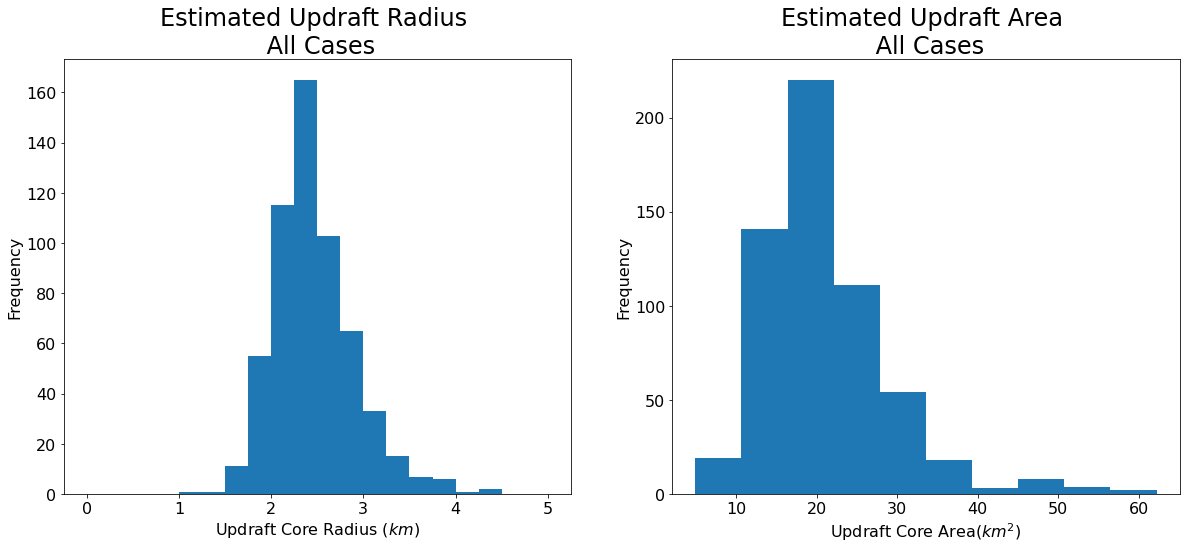

In [227]:

fig = plt.figure(figsize=(20,8))

ax = plt.subplot(121)
ax.hist(calc_r(df_max.area_polygon), u_core_bins, label='14 Dec')


plt.title('Estimated Updraft Radius \n All Cases', fontsize=24)

plt.xlabel('Updraft Core Radius ($km$)', fontsize=16)
plt.ylabel('Frequency', fontsize=16)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

ax2 = plt.subplot(122)
#plt.hist(df_max.area_polygon * 0.4032)



ax2.hist(df_max.area_polygon * 0.4032, label='14 Dec')


plt.title('Estimated Updraft Area \n All Cases', fontsize=24)

plt.xlabel('Updraft Core Area($km^2$)', fontsize=16)
plt.ylabel('Frequency', fontsize=16)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.savefig('Updraft_Radius_Duration_all.png', dpi=400)

Text(0, 0.5, 'Frequency')

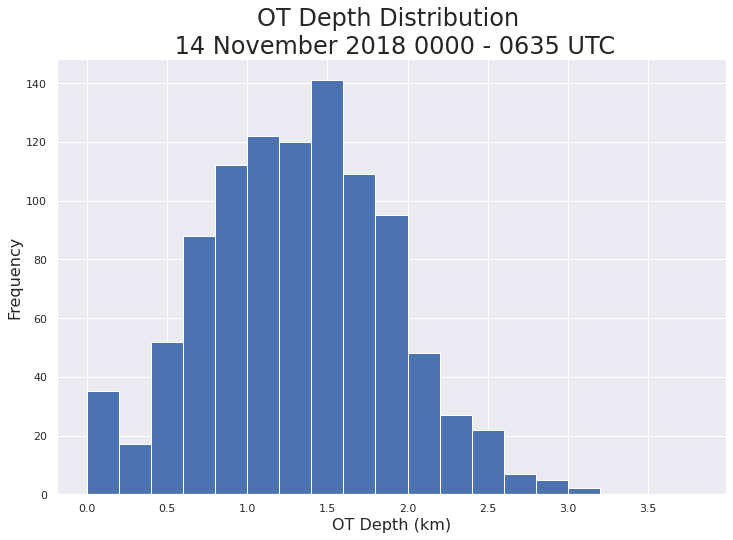

In [435]:
fig = plt.figure(figsize=(12,8))
plt.hist(max_depth, bins=otd_bins)

plt.title('OT Depth Distribution \n 14 November 2018 0000 - 0635 UTC', fontsize=24)

plt.xlabel('OT Depth (km)', fontsize=16)
plt.ylabel('Frequency', fontsize=16)

Text(0, 0.5, 'Frequency')

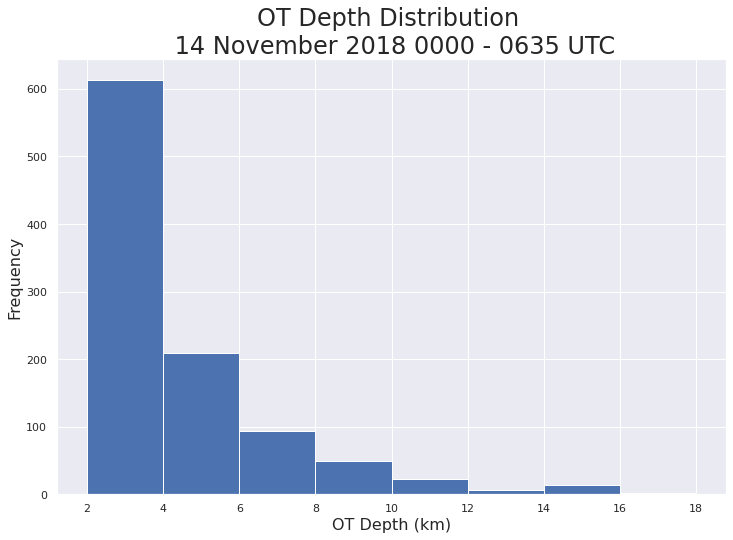

In [357]:
fig = plt.figure(figsize=(12,8))
plt.hist(duration, np.arange(2,20, 2))

plt.title('OT Depth Distribution \n 14 November 2018 0000 - 0635 UTC', fontsize=24)

plt.xlabel('OT Depth (km)', fontsize=16)
plt.ylabel('Frequency', fontsize=16)

In [297]:
df = pd.DataFrame({'duration':duration,
              'max_ota':max_otarea,
              'mean_ota':mean_otarea})

In [308]:
df['round_ota'] = np.around(df.max_ota,-1)

<AxesSubplot:>

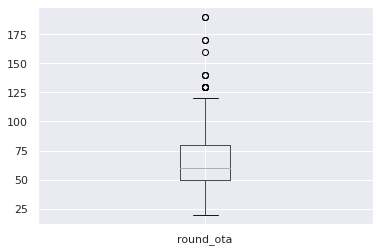

In [312]:
df.boxplot('round_ota')

In [283]:
len(duration[np.where(duration > 2)])

939

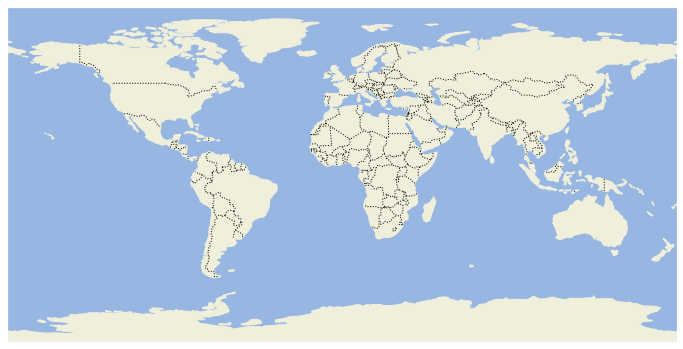

In [322]:
import cartopy.feature as cfeature 
fig = plt.figure(figsize=(12,8))
ax = plt.subplot(111, projection=ccrs.PlateCarree())

ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.BORDERS, linestyle=':')

In [ ]:
cells_grouped = trajectories_filtered.groupby('cell')



duration = cells_grouped.count().area_polygon.values
max_otarea = cells_grouped.max().area_polygon.values
mean_otarea = cells_grouped.mean().area_polygon.values

slope, intercept, r, p, stderr = scipy.stats.linregress(duration, max_otarea)

line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

plt.figure(figsize=(10,8))
ax = plt.subplot(111)
ax.scatter(duration, max_otarea)
ax.plot(np.array(duration), intercept + slope * np.array(duration), label=line, color='black')

plt.ylabel('OT Area ($km^{2}$)', fontsize=12)
plt.xlabel('OT Duration (minutes)', fontsize=12)

plt.legend(loc='upper right', fontsize=12)

plt.title('OT Duration All OTs  \n 10 November, 12 November, 14 December 2018 UTC (Count = 5967)', fontsize=16)

Text(0.5, 1.0, 'Overshooting top tracks\n All Cases')

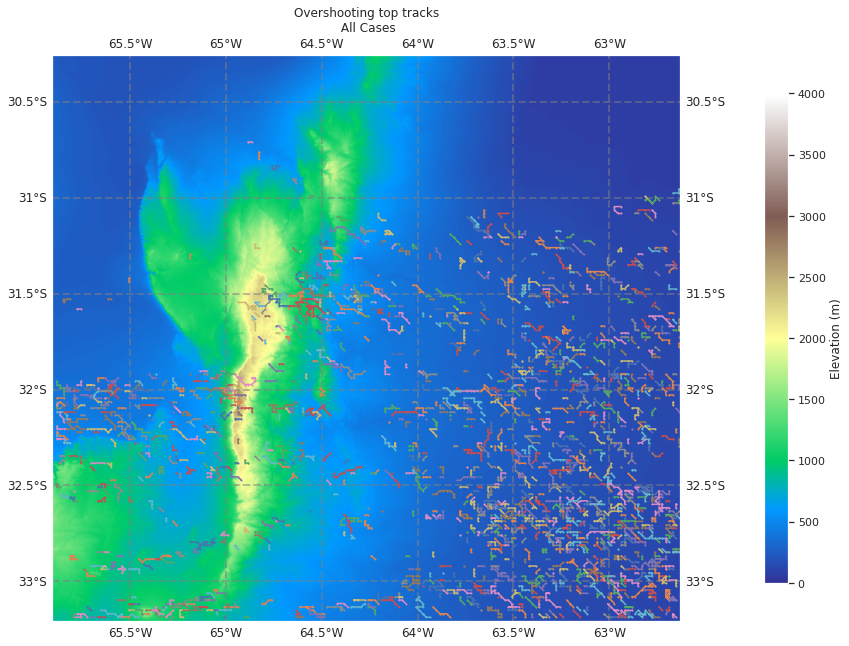

In [288]:
llcrnr=[-33.206342, -65.906586]
urcrnr=[-30.255825, -62.630553]

# Set extent of maps created in the following cells:
axis_extent=[llcrnr[1],urcrnr[1],llcrnr[0],urcrnr[0]]    

# Plot map with all individual tracks:
import cartopy.crs as ccrs
fig_map,ax_map=plt.subplots(figsize=(15,15),subplot_kw={'projection': ccrs.PlateCarree()})

ax_map.coastlines()

ax_map.set_extent(axis_extent)

for ds in ds_list:
#    cm = ax.contourf(ds.x.values[::5], ds.y.values[::5], ds.values[::5,::5], levs, cmap='terrain', transform=ccrs.PlateCarree())
    cm = ax_map.imshow(ds.values, extent =[ds.x.min(),ds.x.max(),ds.y.min(),ds.y.max()], transform=ccrs.PlateCarree(), vmin=0, vmax=4000, cmap='terrain')

gl = ax_map.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')

for name, group in cells_grouped:
#    print(group.x,group.y)
    plt.plot(group.lon,group.lat,"-o",markersize=1)

plt.colorbar(cm,label='Elevation (m)',shrink=0.6, pad=0.1)

ax_map.set_title('Overshooting top tracks\n All Cases')

Text(0.5, 1.0, 'Overshooting top tracks\n All Cases')

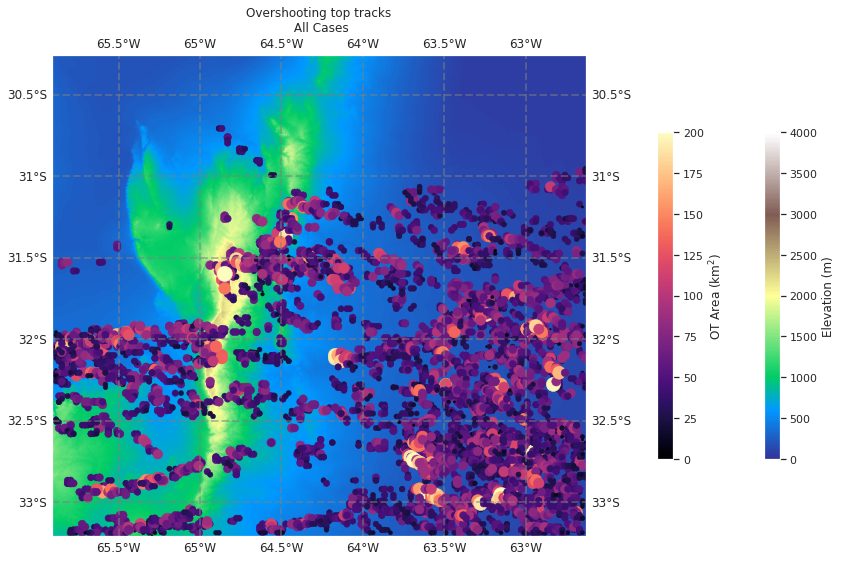

In [290]:
llcrnr=[-33.206342, -65.906586]
urcrnr=[-30.255825, -62.630553]

# Set extent of maps created in the following cells:
axis_extent=[llcrnr[1],urcrnr[1],llcrnr[0],urcrnr[0]]    

# Plot map with all individual tracks:
import cartopy.crs as ccrs
fig_map,ax_map=plt.subplots(figsize=(15,15),subplot_kw={'projection': ccrs.PlateCarree()})

ax_map.coastlines()

ax_map.set_extent(axis_extent)

for ds in ds_list:
#    cm = ax.contourf(ds.x.values[::5], ds.y.values[::5], ds.values[::5,::5], levs, cmap='terrain', transform=ccrs.PlateCarree())
    cm = ax_map.imshow(ds.values, extent =[ds.x.min(),ds.x.max(),ds.y.min(),ds.y.max()], transform=ccrs.PlateCarree(), vmin=0, vmax=4000, cmap='terrain')

gl = ax_map.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')

for name, group in cells_grouped:
#    print(group.x,group.y)
    cm2 = plt.scatter(group.lon,group.lat,c=group.area_polygon,vmin=0.,vmax=200.,s=group.area_polygon,
                     facecolors='none',cmap='magma',linewidth=0.5)

plt.colorbar(cm,label='Elevation (m)',shrink=0.4, pad=0.0)
plt.colorbar(cm2,label='OT Area (km$^2$)',shrink=0.4, pad=0.1)



ax_map.set_title('Overshooting top tracks\n All Cases')

In [262]:
import seaborn as sns

In [263]:
sns.set()

(array([936., 317., 148.,  61.,  20.,  21.,  15.,   9.,   4.,   3.]),
 array([ 2. ,  3.8,  5.6,  7.4,  9.2, 11. , 12.8, 14.6, 16.4, 18.2, 20. ]),
 <BarContainer object of 10 artists>)

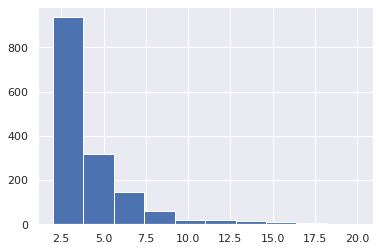

In [278]:
plt.hist(duration)

(array([ 48., 524., 517., 279.,  85.,  43.,  21.,  13.,   2.,   2.,   0.]),
 array([  0,  25,  50,  75, 100, 125, 150, 175, 200, 225, 250, 275]),
 <BarContainer object of 11 artists>)

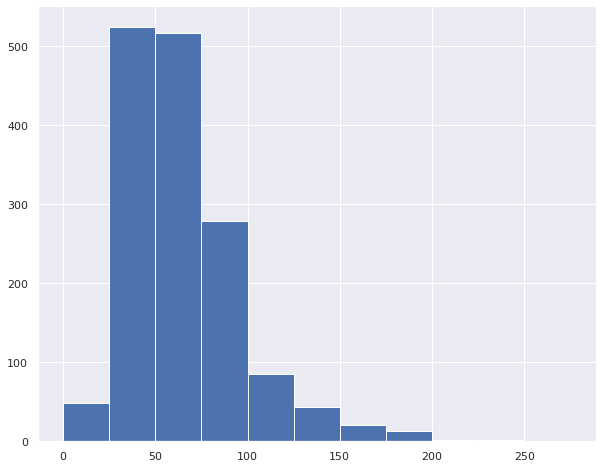

In [270]:
plt.figure(figsize=(10,8))
plt.hist(max_otarea, bins=np.arange(0, 300, 25))

In [99]:
df_track= pd.read_csv('test.csv')

In [149]:
v_max=60.
stubs=2
order=1
extrapolate=1
memory=1
adaptive_stop=0.01
adaptive_step=0.99
subnetwork_size=100
method_linking= 'predict'
cell_number_start=1
dt = 60.
dxy = 2000.

search_range=dt*v_max

features_linking=deepcopy(df_track)

pred = tp.predict.NearestVelocityPredict(span=1)
trajectories_unfiltered = pred.link_df(features_linking, search_range=search_range, memory=memory,
                                 pos_columns=['x','y'],
                                 t_column='frame',
                                 neighbor_strategy='KDTree', link_strategy='auto',
                                 adaptive_step=adaptive_step,adaptive_stop=adaptive_stop
#                                 copy_features=False, diagnostics=False,
#                                 hash_size=None, box_size=None, verify_integrity=True,
#                                 retain_index=False
                                 )

trajectories_unfiltered['cell']=None
for i_particle,particle in enumerate(pd.Series.unique(trajectories_unfiltered['particle'])):
    cell=int(i_particle+cell_number_start)
    trajectories_unfiltered.loc[trajectories_unfiltered['particle']==particle,'cell']=cell
trajectories_unfiltered.drop(columns=['particle'],inplace=True)

trajectories_bycell=trajectories_unfiltered.groupby('cell')

num_stubs = 0

for cell,trajectories_cell in trajectories_bycell:
#    logging.debug("cell: "+str(cell))
#    logging.debug("feature: "+str(trajectories_cell['feature'].values))
#    logging.debug("trajectories_cell.shape[0]: "+ str(trajectories_cell.shape[0]))


    if trajectories_cell.shape[0] < stubs:
#        print("cell" + str(cell)+ "  is a stub ("+str(trajectories_cell.shape[0])+ "), setting cell number to Nan..")
        trajectories_unfiltered.loc[trajectories_unfiltered['cell']==cell,'cell']=np.nan
        num_stubs = num_stubs + 1

print('found this many stubs: {}'.format(num_stubs))

trajectories_filtered=trajectories_unfiltered.dropna()

Frame 15780: 1 trajectories present.
found this many stubs: 183


In [182]:
def test_prob(df, prob_thresh=.7, min_duration=2, max_prob_thresh=.7):
    test = df[df.prob > prob_thresh]
    
    cells_grouped = test.groupby('cell')
    
    max_vals = cells_grouped.max()
    duration = cells_grouped.count().area_polygon.values
    
    print(duration)
    max_prob_thresh = .7
    
    max_vals = max_vals[duration > min_duration]
    
    max_otarea = max_vals.area_polygon.values
    duration = duration[duration > min_duration]
    
    
    print(max_otarea)
    #mean_otarea = cells_grouped.mean()[duration > min_duration].area_polygon.values
    
    max_prob = max_vals.prob.values

    slope, intercept, r, p, stderr = scipy.stats.linregress(duration, max_otarea)

    line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

    plt.figure(figsize=(10,8))
    ax = plt.subplot(111)
    s = ax.scatter(duration, max_otarea, s=50, c=max_prob, cmap='viridis_r')
    plt.colorbar(s, label='Max OT Probability')
    ax.plot(np.array(duration), intercept + slope * np.array(duration), label=line, color='black')

    plt.ylabel('OT Area ($km^{2}$)', fontsize=12)
    plt.xlabel('OT Duration (minutes)', fontsize=12)

    plt.legend(loc='upper right', fontsize=12)

    plt.title(f'OT Duration 14 December 2018 Prob Thresh: {prob_thresh} \n 1500 - 2359 UTC (Count = {len(max_prob)})', fontsize=16)
    
    plt.show()
    
    plt.close()

In [183]:
trajectories_filtered.groupby('cell')[trajectories_filtered.groupby('cell').count().area_polygon.values > 2]

KeyError: 'Columns not found: False, True'

In [174]:
duration = cells_grouped.count().area_polygon.values

[ 5  2  2  2  4  2  4  5  3  2  4  3  7  5  2  2  3  2  4  9  8  2  3  4
  3  3  2  4  3  2  4  4  6  4  2  2  4  2  2  2  3  2  6  3  3  2  7  6
  4  4 11 12  2  9  3 11  2  7  7  3  2  2  3  3  2  4  3  2  2  3  5  6
  2 10  5  5  5  3  2  5  2  2  2  3  3  2  3  4  3  7  3  5  5  2  3  2
  7  6  5  2  3  4  2  2  2  8  3  5  6  7  4  2  7  2  2  6  4  2  2  6
  5  3  2  5  2  2  2  3  4  4  3  3  5  2  5  5  6  2  2  3  2  2  4  2
  3  3  3  7]
[ 53.04495093  74.95417576  37.22169946  36.22672045  50.61187799
  51.4434505   49.73851352  41.60106836  47.97494253  99.33966763
  37.05978449  62.73190927  37.34097974  98.73006191  54.95093377
  33.80301911  49.73551538  57.66338334  43.04843349  43.15796459
  61.58380279  47.34810358  56.40235019  35.98703749  71.76936767
  42.77964004  89.923258    26.88437875  42.40980711  53.30652372
  40.19559012  40.76121201  82.6356979   91.5173871   74.16442957
  27.1494529   91.64322272  49.21365175  55.84471987  63.73875001
  74.47165467  59.17

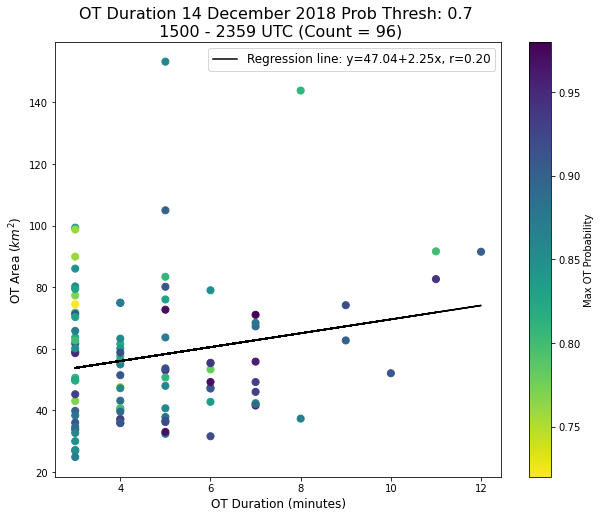

In [188]:
test_prob(trajectories_filtered, .7, 2)

Text(0.5, 1.0, 'OT Duration 14 December 2018 \n 1500 - 2359 UTC (Count = 2353)')

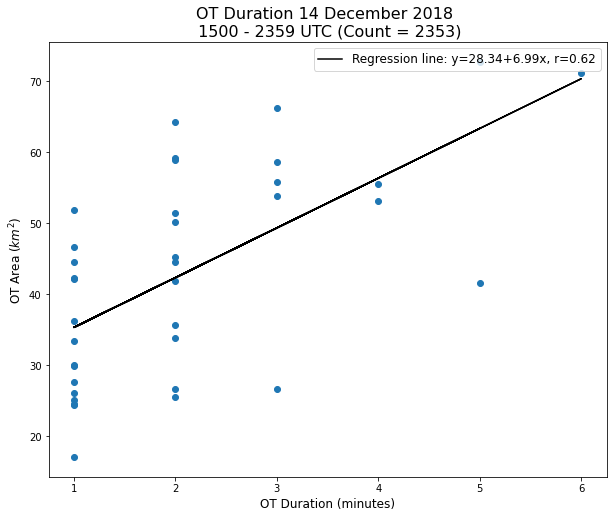

In [107]:
cells_grouped = test.groupby('cell')

duration = cells_grouped.count().area_polygon.values
max_otarea = cells_grouped.max().area_polygon.values
mean_otarea = cells_grouped.mean().area_polygon.values

slope, intercept, r, p, stderr = scipy.stats.linregress(duration, max_otarea)

line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

plt.figure(figsize=(10,8))
ax = plt.subplot(111)
ax.scatter(duration, max_otarea)
ax.plot(np.array(duration), intercept + slope * np.array(duration), label=line, color='black')

plt.ylabel('OT Area ($km^{2}$)', fontsize=12)
plt.xlabel('OT Duration (minutes)', fontsize=12)

plt.legend(loc='upper right', fontsize=12)

plt.title('OT Duration 14 December 2018 \n 1500 - 2359 UTC (Count = 2353)', fontsize=16)